# Predicting the Genetic Disorder

### Context
As per reports, as a consequence of the unsustainable increase in population and a lack of access to adequate health care, food, and shelter, the number of genetic disorder ailments have increased. Hereditary illnesses are becoming more common due to a lack of understanding about the need for genetic testing. Often kids die as a result of these illnesses, thus genetic testing during pregnancy is critical.

<center>
    <img src = ../images/dna.png width = 35%/>
</center>

#### CRISP-DM (Cross-Industry Standard Process for Data Mining) Framework
- Using CRISP-DM framework to predict genetic disorders and their subclasses.
- CRISP-DM consists of six phases: Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, and Deployment.

## Business Understanding

#### Objective:
Predict the genetic disorder and its subclass in children based on various medical and genetic attributes.

#### Goals:
- Develop a model to accurately classify the type of genetic disorder and its subclass.
    - Genetic Disorders -> Disorder Subclass
        - Mitochondrial genetic inheritance disorders
            - Leigh syndrome
            - Mitochondrial myopathy
            - Leber's hereditary optic neuropathy 
        - Single-gene inheritance diseases
            - Cystic fibrosis
            - Tay-Sachs
            - Hemochromatosis 
        - Multifactorial genetic inheritance disorders
            - Diabetes
            - Alzheimer's
            - Cancer
- Provide insights to aid healthcare professionals in early diagnosis and treatment planning.

In [245]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
import graphviz
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from itertools import cycle

import joblib

## Data Understanding

#### Overview:
The dataset, sourced from Kaggle, contains medical information about 22,083 children with genetic disorders with genetic disorders, aimed at predicting the type of genetic disorder and its subclass. There are 45 columns, each representing different attributes related to the patients' genetic, parental, and medical conditions, including 2 columns of target outputs - genetic disoder and its subclass.

- DataSet URL: https://www.kaggle.com/datasets/mukund23/predict-the-genetic-disorder/data

#### Data Collection
- Load the DataSet

In [4]:
# Load the data set
gene = pd.read_csv('../data/train.csv')

In [5]:
# Display DataSet
gene

Patient Id  Patient Age Genes in mother's side Inherited from father  \
0      PID0x6418          2.0                    Yes                    No   
1      PID0x25d5          4.0                    Yes                   Yes   
2      PID0x4a82          6.0                    Yes                    No   
3      PID0x4ac8         12.0                    Yes                    No   
4      PID0x1bf7         11.0                    Yes                    No   
...          ...          ...                    ...                   ...   
22078  PID0x5598          4.0                    Yes                   Yes   
22079  PID0x19cb          8.0                     No                   Yes   
22080  PID0x3c4f          8.0                    Yes                    No   
22081   PID0x13a          7.0                    Yes                    No   
22082  PID0x9332         11.0                    Yes                    No   

      Maternal gene Paternal gene  Blood cell count (mcL) Patient First Name  \
0               Yes            No                4.760603            Richard   
1                No            No                4.910669               Mike   
2                No            No                4.893297           Kimberly   
3               Yes            No                4.705280            Jeffery   
4               NaN           Yes                4.720703            Johanna   
...             ...           ...                     ...                ...   
22078           Yes            No                5.258298               Lynn   
22079            No           Yes                4.974220            Matthew   
22080           Yes            No                5.186470               John   
22081           Yes           Yes                4.858543             Sharon   
22082            No            No                4.738067             Andrew   

      Family Name Father's name  ...  Birth defects  \
0             NaN         Larre  ...            NaN   
1             NaN        Brycen  ...       Multiple   
2             NaN        Nashon  ...       Singular   
3       Hoelscher        Aayaan  ...       Singular   
4        Stutzman         Suave  ...       Multiple   
...           ...           ...  ...            ...   
22078         NaN     Alhassane  ...       Multiple   
22079      Farley     Dartanion  ...       Multiple   
22080         NaN        Cavani  ...       Singular   
22081         NaN         Bomer  ...       Multiple   
22082        Mose          Eban  ...       Singular   

       White Blood cell count (thousand per microliter) Blood test result  \
0                                              9.857562               NaN   
1                                              5.522560            normal   
2                                                   NaN            normal   
3                                              7.919321      inconclusive   
4                                              4.098210               NaN   
...                                                 ...               ...   
22078                                          6.584811      inconclusive   
22079                                          7.041556      inconclusive   
22080                                          7.715464            normal   
22081                                          8.437670          abnormal   
22082                                         11.188371            normal   

      Symptom 1 Symptom 2 Symptom 3 Symptom 4  Symptom 5  \
0           1.0       1.0       1.0       1.0        1.0   
1           1.0       NaN       1.0       1.0        0.0   
2           0.0       1.0       1.0       1.0        1.0   
3           0.0       0.0       1.0       0.0        0.0   
4           0.0       0.0       0.0       0.0        NaN   
...         ...       ...       ...       ...        ...   
22078       0.0       0.0       1.0       0.0        0.0   
22079       1.0       1.0       1.0       

#### Data Description:

1. **Patient Id**: A unique identifier for each patient.
2. **Patient Age**: The age of the patient (child) in years.
3. **Genes in mother's side**: Information on whether there are genetic conditions in the maternal family.
4. **Inherited from father**: Information on genetic traits inherited from the father.
5. **Maternal gene**: Whether genes inherited from the mother.
6. **Paternal gene**: Whether genes inherited from the father.
7. **Blood cell count (mcL)**: Blood cell count measured in microliters.
8. **Patient First Name**: First name of the patient.
9. **Family Name**: Family name of the patient.
10. **Father's name**: Name of the patient's father.
11. **Mother's age**: Age of the mother at the time of the child's birth.
12. **Father's age**: Age of the father at the time of the child's birth.
13. **Institute Name**: Name of the medical institute where the patient is being treated.
14. **Location of Institute**: Geographical location of the medical institute. 
15. **Status**: The current health status of the patient (e.g., alive, deceased).
16. **Respiratory Rate**: The respiratory rate of the patient (Normal or abnormal).
17. **Heart Rate**: The heart rate of the patient (Normal or abnormal).
18. **Test 1**: Results from unspecified medical test.
19. **Test 2**: Results from unspecified medical test.
20. **Test 3**: Results from unspecified medical test.
21. **Test 4**: Results from unspecified medical test.
22. **Test 5**: Results from unspecified medical test.
23. **Parental consent**: Whether parental consent was obtained for genetic testing.
24. **Follow-up**: Follow-ups after initial diagnosis or treatment.
25. **Gender**: Gender of the patient (e.g., male, female).
26. **Birth asphyxia**: Information on whether the patient experienced birth asphyxia.
27. **Autopsy shows birth defect (if applicable)**: Whether autopsy revealed any birth defects.
28. **Place of birth**: The location where the patient was born (Institute or Home).
29. **Folic acid details (peri-conceptional)**: Details about folic acid intake during the peri-conceptional period.
30. **H/O serious maternal illness**: History of serious maternal illness during pregnancy.
31. **H/O radiation exposure (x-ray)**: History of maternal radiation exposure (e.g., X-rays) during pregnancy.
32. **H/O substance abuse**: History of maternal substance abuse during pregnancy.
33. **Assisted conception IVF/ART**: Whether the child was conceived via assisted reproductive technologies like IVF.
34. **History of anomalies in previous pregnancies**: Information on any anomalies in previous pregnancies.
35. **No. of previous abortions**: Number of abortions the mother had before this pregnancy.
36. **Birth defects**: Presence of any birth defects in the patient.
37. **White Blood cell count (thousand per microliter)**: White blood cell count in thousands per microliter.
38. **Blood test result**: Results of unspecified blood tests.
39. **Symptom 1**: Result from unspecified symptom observed in the patient.
40. **Symptom 2**: Result from unspecified symptom observed in the patient.
41. **Symptom 3**: Result from unspecified symptom observed in the patient.
42. **Symptom 4**: Result from unspecified symptom observed in the patient.
43. **Symptom 5**: Result from unspecified symptom observed in the patient.
44. **Genetic Disorder**: The type of genetic disorder diagnosed in the patient (target variable).
45. **Disorder Subclass**: The subclass of the genetic disorder diagnosed in the patient (target variable).

In [10]:
gene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        22083 non-null  object 
 1   Patient Age                                       20656 non-null  float64
 2   Genes in mother's side                            22083 non-null  object 
 3   Inherited from father                             21777 non-null  object 
 4   Maternal gene                                     19273 non-null  object 
 5   Paternal gene                                     22083 non-null  object 
 6   Blood cell count (mcL)                            22083 non-null  float64
 7   Patient First Name                                22083 non-null  object 
 8   Family Name                                       12392 non-null  object 
 9   Father's name    

In [12]:
# Identify numerical columns
numerical_cols = gene.select_dtypes(include=['int','float']).columns.tolist()
print(numerical_cols)

['Patient Age', 'Blood cell count (mcL)', "Mother's age", "Father's age", 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'No. of previous abortion', 'White Blood cell count (thousand per microliter)', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']


In [14]:
# Identify categorical columns and value counts for each category
categorical_cols = gene.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

['Patient Id', "Genes in mother's side", 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Patient First Name', 'Family Name', "Father's name", 'Institute Name', 'Location of Institute', 'Status', 'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia', 'Autopsy shows birth defect (if applicable)', 'Place of birth', 'Folic acid details (peri-conceptional)', 'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse', 'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies', 'Birth defects', 'Blood test result', 'Genetic Disorder', 'Disorder Subclass']


#### Data Summary:
- **12 Numerical Columns**: 'Patient Age', 'Blood cell count (mcL)', "Mother's age", "Father's age", 'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'No. of previous abortion', 'White Blood cell count (thousand per microliter)', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'.
- **23 Categorical Columns**: 'Patient Id', "Genes in mother's side", 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Patient First Name', 'Family Name', "Father's name", 'Institute Name', 'Location of Institute', 'Status', 'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia', 'Autopsy shows birth defect (if applicable)', 'Place of birth', 'Folic acid details (peri-conceptional)', 'H/O serious maternal illness', 'H/O radiation exposure (x-ray)', 'H/O substance abuse', 'Assisted conception IVF/ART', 'History of anomalies in previous pregnancies', 'Birth defects', 'Blood test result', 'Genetic Disorder', 'Disorder Subclass'.

#### Data Considerations

**Missing Values:**
- Several columns contain missing values, notably in maternal and paternal ages, certain medical tests, and specific genetic information.
- It is crucial to address these missing values through imputation or other suitable methods to ensure robust model training.

**Data Types:**
- The dataset includes both numerical (float64) and categorical (object) data types.
- Conversion and encoding of categorical variables will be necessary for machine learning model training.

**Initial Observations:**
- The dataset provides comprehensive medical and genetic information which can be leveraged to predict genetic disorders.
- The presence of symptoms, medical test results, and parental genetic information are likely to be key predictors for the target variables.
- Handling missing values, identifying outliers, data cleaning, data balancing and feature engineering are critical preprocessing steps to ensure the effectiveness of the predictive models.

#### Potential Challenges
- **Complex Interactions:** Genetic factors can interact with environmental and other factors in complex ways.
- **Data Privacy:** Handling sensitive patient data requires appropriate privacy measures. Remove such columns.
- **Interpretability:** Understanding the reasons behind model predictions can be challenging due to the complexity of genetic data.

By thoroughly understanding and preparing the data, we can build accurate and reliable models to predict genetic disorders and their subclasses, ultimately aiding in early diagnosis and treatment planning.

## Data Preparation

The data preparation phase is crucial for ensuring that the dataset is clean, consistent, and suitable for model training. This involves handling missing values, encoding categorical variables, scaling numerical features, and potentially feature engineering. Here are the detailed steps for data preparation:

#### Data Cleaning:

**Drop Irrelavent columns**
- Remove columns that do not contribute to the prediction of genetic disorders, ensuring a more focused dataset.
- Following columns are identified irrelavent: 'Patient Id', 'Patient First Name', 'Family Name', 'Father's name', 'Test 1', 'Test 2', 'Test 3', 'Test 5' (Test 1-3 and 5 have all values = 0)

In [19]:
# Drop 'Patient Id', 'Patient First Name', 'Family Name', 'Father's name' deemed irrelavent for predicting the target variables
gene.drop(columns = ['Patient Id', 'Patient First Name', 'Family Name', "Father's name", 'Institute Name', 'Location of Institute', 'Test 1', 'Test 2', 'Test 3', 'Test 5'], inplace = True)

**Find and Remove Duplicates (if any)**:
No Duplicates found.

In [22]:
# Find Duplicate rows
gene[gene.duplicated()]

Empty DataFrame
Columns: [Patient Age, Genes in mother's side, Inherited from father, Maternal gene, Paternal gene, Blood cell count (mcL), Mother's age, Father's age, Status, Respiratory Rate (breaths/min), Heart Rate (rates/min, Test 4, Parental consent, Follow-up, Gender, Birth asphyxia, Autopsy shows birth defect (if applicable), Place of birth, Folic acid details (peri-conceptional), H/O serious maternal illness, H/O radiation exposure (x-ray), H/O substance abuse, Assisted conception IVF/ART, History of anomalies in previous pregnancies, No. of previous abortion, Birth defects, White Blood cell count (thousand per microliter), Blood test result, Symptom 1, Symptom 2, Symptom 3, Symptom 4, Symptom 5, Genetic Disorder, Disorder Subclass]
Index: []

[0 rows x 35 columns]

In [24]:
# No Duplicate rows found

**Rename Columns**
- Rename columns with appropriate short names for clarity and ease of use.

In [27]:
# Dictionary to map old column names to new names
new_column_names = {
    "Genes in mother's side": 'Inherited from mother',
    "Blood cell count (mcL)":'Blood cell count',
    "Mother's age":"Mother age",
    "Father's age":"Father age",
    'Respiratory Rate (breaths/min)':'Respiratory Rate',
    'Heart Rate (rates/min':'Heart Rate',
    'Autopsy shows birth defect (if applicable)':'Birth defect',
    'Folic acid details (peri-conceptional)':'Folic acid',
    'H/O serious maternal illness':'Serious maternal illness',
    'H/O radiation exposure (x-ray)': 'Radiation exposure',
    'H/O substance abuse': 'Substance abuse',
    'Assisted conception IVF/ART': 'Assisted conception',
    'No. of previous abortion' : 'Previous abortion count',
    'White Blood cell count (thousand per microliter)':'WBC count',
    'History of anomalies in previous pregnancies':'Anomalies in previous pregnancies'
}

# Rename columns
gene.rename(columns=new_column_names, inplace=True)

In [29]:
# Updated gene df
gene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient Age                        20656 non-null  float64
 1   Inherited from mother              22083 non-null  object 
 2   Inherited from father              21777 non-null  object 
 3   Maternal gene                      19273 non-null  object 
 4   Paternal gene                      22083 non-null  object 
 5   Blood cell count                   22083 non-null  float64
 6   Mother age                         16047 non-null  float64
 7   Father age                         16097 non-null  float64
 8   Status                             22083 non-null  object 
 9   Respiratory Rate                   19934 non-null  object 
 10  Heart Rate                         19970 non-null  object 
 11  Test 4                             19943 non-null  flo

### Exploratory Data Analysis (EDA)

In the Data Exploration phase, conducted a thorough analysis to uncover patterns, relationships, and insights within the dataset. 
Key activities included:
- Missing Values Analysis
- Descriptive Statistics
- Distribution Analysis
    - Numerical variables
        - Outlier Detection
    - Categorical variables
- Bivariate Analysis
    - Numerical vs. Numerical
    - Categorical vs. Categorical
    - Numerical vs. Categorical

#### Missing Values Analysis

In [33]:
gene.isnull().sum()

Patient Age                          1427
Inherited from mother                   0
Inherited from father                 306
Maternal gene                        2810
Paternal gene                           0
Blood cell count                        0
Mother age                           6036
Father age                           5986
Status                                  0
Respiratory Rate                     2149
Heart Rate                           2113
Test 4                               2140
Parental consent                     2125
Follow-up                            2166
Gender                               2173
Birth asphyxia                       2139
Birth defect                         4392
Place of birth                       2124
Folic acid                           2117
Serious maternal illness             2152
Radiation exposure                   2153
Substance abuse                      2195
Assisted conception                  2122
Anomalies in previous pregnancies 

In [38]:
# Identify columns with missing values
columns_with_missing = gene.columns[gene.isnull().any()]

# Calculate percentage of missing values for each column
missing_percentage = (gene[columns_with_missing].isnull().mean() * 100)
print("Percentage of missing values in each column:")

for col, percentage in missing_percentage.items():
    print(f"{col}: {percentage:.2f}%")

Percentage of missing values in each column:
Patient Age: 6.46%
Inherited from father: 1.39%
Maternal gene: 12.72%
Mother age: 27.33%
Father age: 27.11%
Respiratory Rate: 9.73%
Heart Rate: 9.57%
Test 4: 9.69%
Parental consent: 9.62%
Follow-up: 9.81%
Gender: 9.84%
Birth asphyxia: 9.69%
Birth defect: 19.89%
Place of birth: 9.62%
Folic acid: 9.59%
Serious maternal illness: 9.75%
Radiation exposure: 9.75%
Substance abuse: 9.94%
Assisted conception: 9.61%
Anomalies in previous pregnancies: 9.84%
Previous abortion count: 9.79%
Birth defects: 9.75%
WBC count: 9.73%
Blood test result: 9.71%
Symptom 1: 9.76%
Symptom 2: 10.06%
Symptom 3: 9.51%
Symptom 4: 9.57%
Symptom 5: 9.75%
Genetic Disorder: 9.72%
Disorder Subclass: 9.82%


#### **Missing Values Analysis:** 
Most columns have a missing rate of around 9-10%, with a few columns having more substantial gaps.
- **Low Missing Values (1% - 10%)**: *Inherited from father* (1.39%), *Patient Age* (6.46%).
- **Moderate Missing Values (9% - 10%)**: Many columns, such as *Respiratory Rate*, *Heart Rate*, *Parental Consent*, *Gender*, *Birth Asphyxia*, *WBC Count*, *Test 4* and *Genetic Disorder*, have around 9-10% missing data.
- **High Missing Values (Above 10%)**: *Maternal gene* (12.72%), *Birth Defect* (19.89%).
- **Very High Missing Values (Above 20%)**: *Mother's Age* (27.33%) and *Father's Age* (27.11%). 

#### Descriptive Statistics

In [43]:
gene.describe()

Patient Age  Blood cell count    Mother age    Father age   Test 4  \
count  20656.000000      22083.000000  16047.000000  16097.000000  19943.0   
mean       6.974148          4.898871     34.526454     41.972852      1.0   
std        4.319475          0.199663      9.852598     13.035501      0.0   
min        0.000000          4.092727     18.000000     20.000000      1.0   
25%        3.000000          4.763109     26.000000     31.000000      1.0   
50%        7.000000          4.899399     35.000000     42.000000      1.0   
75%       11.000000          5.033830     43.000000     53.000000      1.0   
max       14.000000          5.609829     51.000000     64.000000      1.0   

       Previous abortion count     WBC count     Symptom 1     Symptom 2  \
count             19921.000000  19935.000000  19928.000000  19861.000000   
mean                  2.003062      7.486224      0.592483      0.551886   
std                   1.411919      2.653393      0.491385      0.497313   
min                   0.000000      3.000000      0.000000      0.000000   
25%                   1.000000      5.424703      0.000000      0.000000   
50%                   2.000000      7.477132      1.000000      1.000000   
75%                   3.000000      9.526152      1.000000      1.000000   
max                   4.000000     12.000000      1.000000      1.000000   

          Symptom 3     Symptom 4     Symptom 5  
count  19982.000000  19970.000000  19930.000000  
mean       0.536233      0.497747      0.461917  
std        0.498698      0.500007      0.498560  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        1.000000      0.000000      0.000000  
75%        1.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

##### **Descriptive Statistics Summary:**

- **Patient Age**: Average of 6.97 years, ranging from 0 to 14 years.
- **Blood Cell Count**: Average of 4.90 mcL, with values between 4.09 and 5.61 mcL.
- **Mother's Age**: Average of 34.53 years, ranging from 18 to 51 years.
- **Father's Age**: Average of 41.97 years, ranging from 20 to 64 years.
- **Test 4**: Uniform value of 1.0 across all records with ~10% missing values.
- **Previous Abortion Count**: Average of 2.0, ranging from 0 to 4.
- **WBC Count**: Average of 7.49 (thousand per microliter), ranging from 3.0 to 12.0.
- **Symptoms 1-5**: Binary indicators (0 or 1) for the presence of symptoms.

#### Distribution Analysis: 
Visualized the distributions of key variables using histograms, density plots and box plots to understand their spread and identify any skewness or kurtosis. This helped in detecting potential outliers and understanding the general data shape.

##### **Distribution of Numerical Variables**

In [48]:
# Identify numerical columns
numerical_cols = gene.select_dtypes(include=['int','float']).columns.tolist()
print(numerical_cols)

['Patient Age', 'Blood cell count', 'Mother age', 'Father age', 'Test 4', 'Previous abortion count', 'WBC count', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']


In [50]:
for var in numerical_cols:
    print(gene[var].value_counts(), '\nlenght:', len(gene[var].unique()), '\n\n')

Patient Age
4.0     1435
12.0    1435
9.0     1415
2.0     1396
5.0     1394
0.0     1386
13.0    1384
3.0     1383
6.0     1374
1.0     1364
11.0    1353
7.0     1351
8.0     1340
14.0    1333
10.0    1313
Name: count, dtype: int64 
lenght: 16 


Blood cell count
4.738067    1
4.760603    1
4.910669    1
4.892811    1
5.058498    1
           ..
4.901080    1
4.964816    1
5.209058    1
4.752272    1
4.750824    1
Name: count, Length: 22083, dtype: int64 
lenght: 22083 


Mother age
23.0    525
19.0    516
40.0    515
28.0    508
47.0    508
48.0    507
41.0    502
45.0    490
44.0    489
21.0    488
35.0    484
24.0    480
49.0    479
50.0    476
30.0    473
27.0    471
29.0    469
32.0    465
38.0    465
42.0    464
37.0    463
22.0    463
46.0    460
31.0    457
26.0    457
20.0    451
51.0    449
34.0    447
18.0    443
33.0    441
43.0    437
36.0    436
25.0    435
39.0    434
Name: count, dtype: int64 
lenght: 35 


Father age
20.0    414
49.0    400
29.0    399
61.0    396
57.

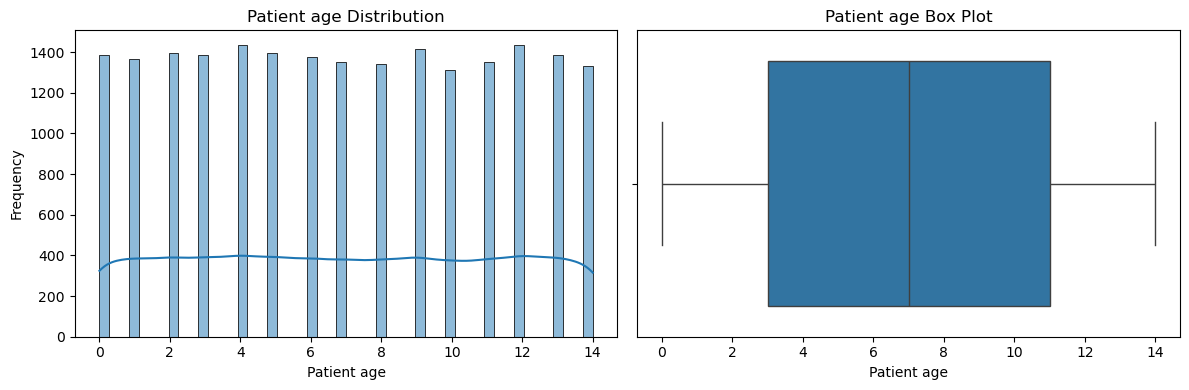

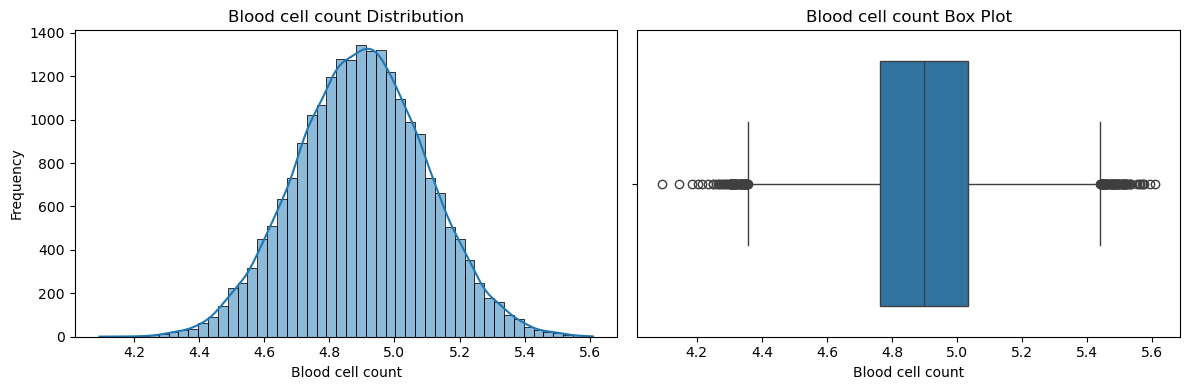

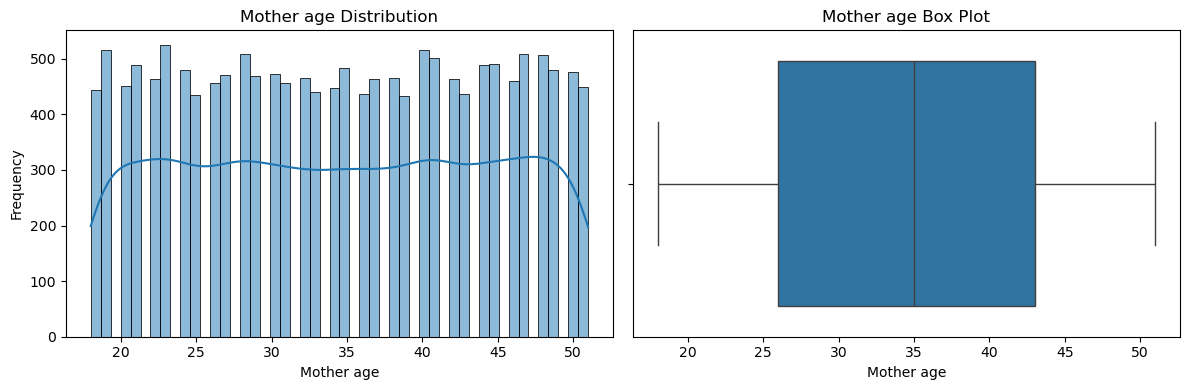

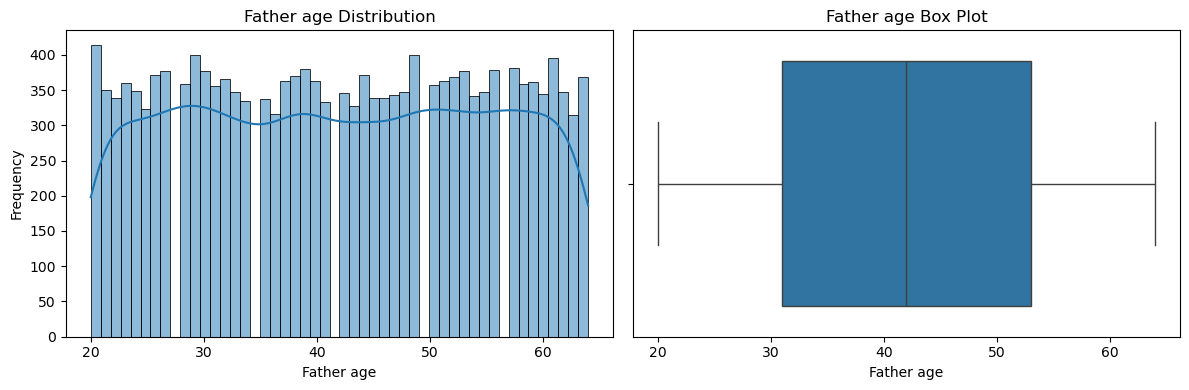

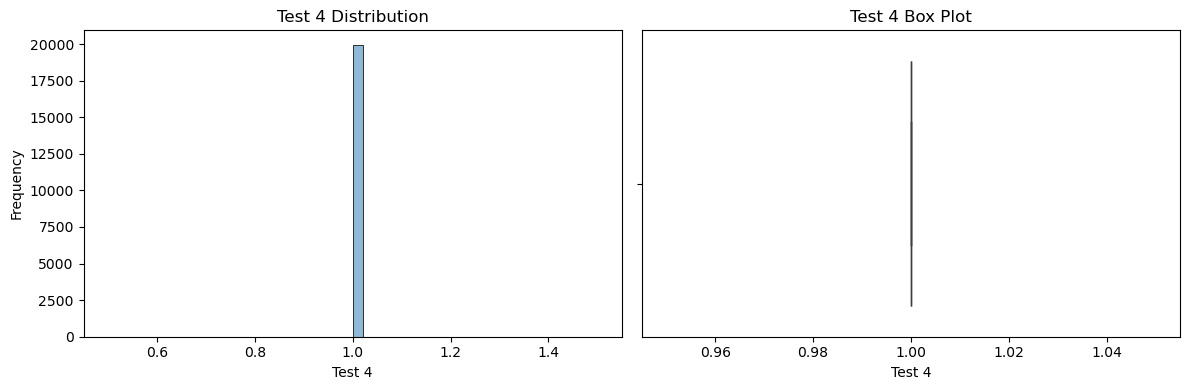

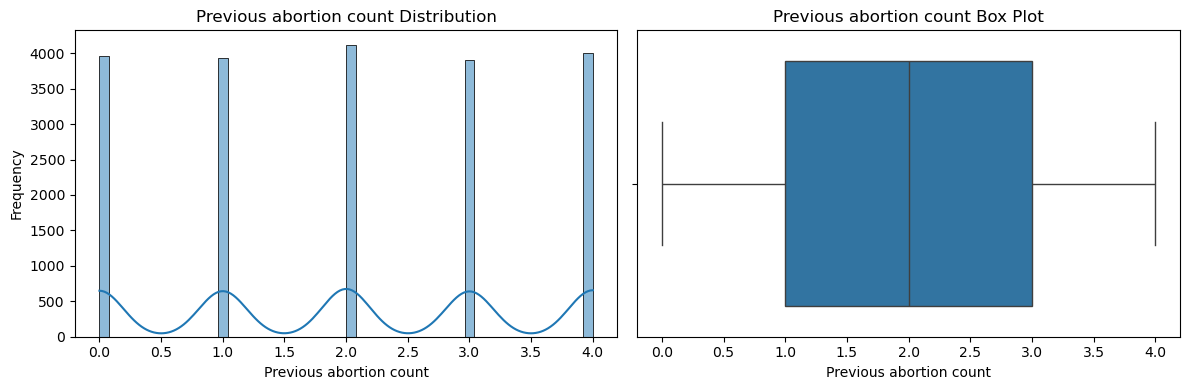

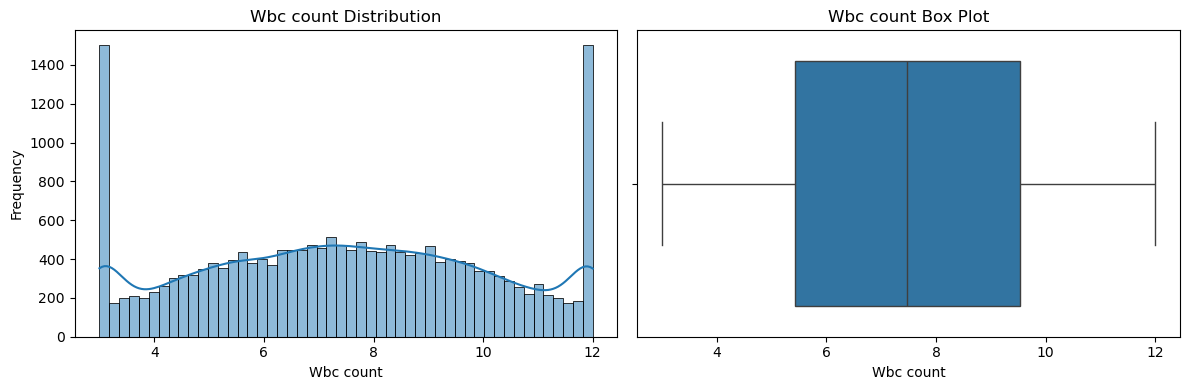

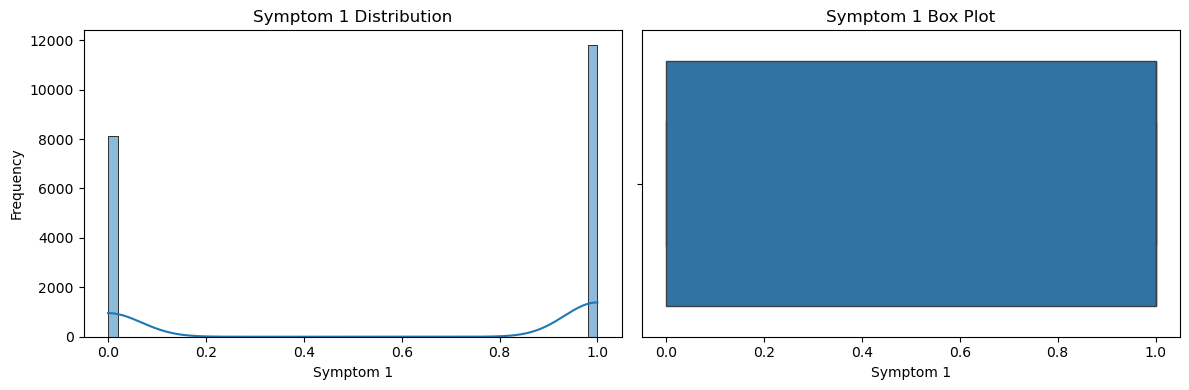

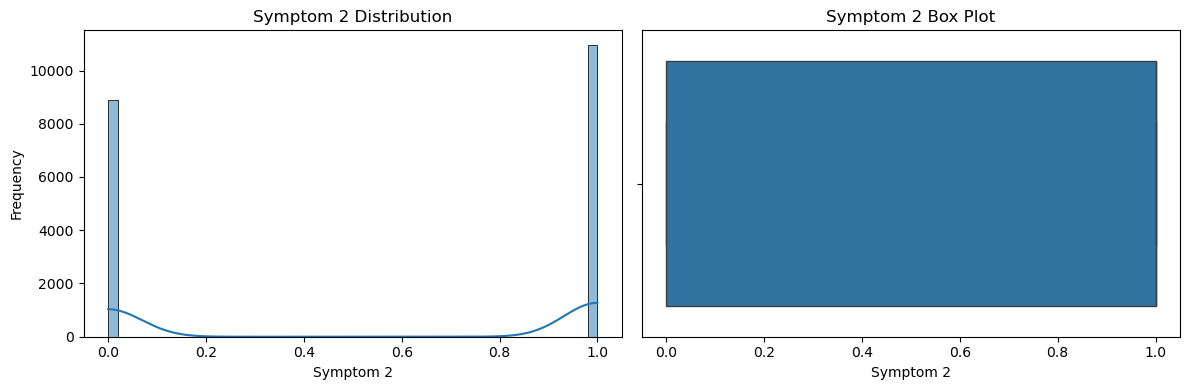

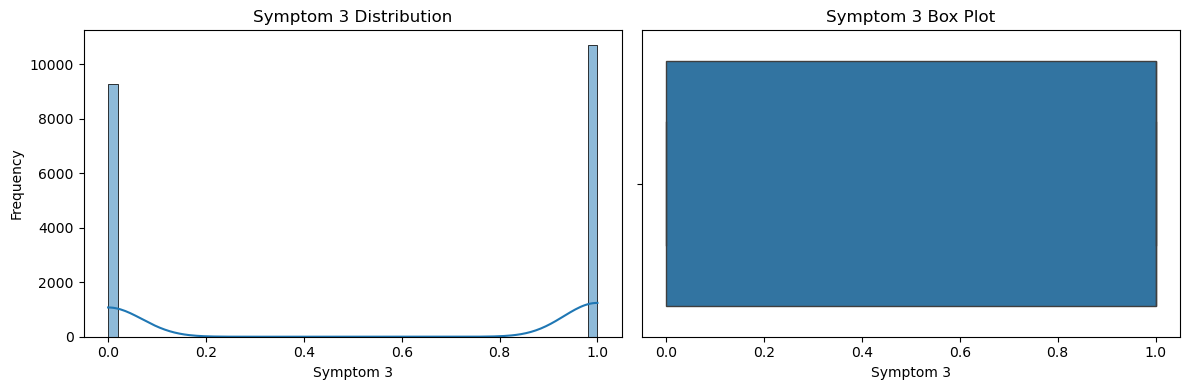

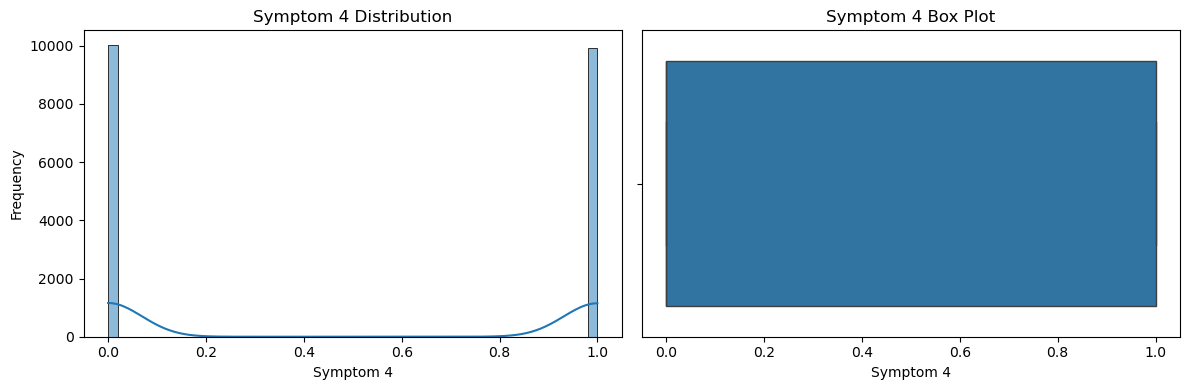

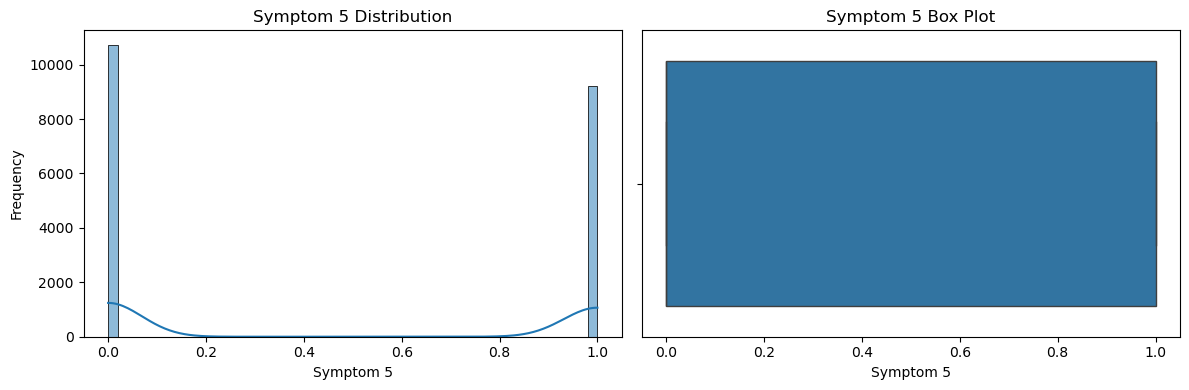

In [52]:
# Loop through each numerical variable and create histograms and density plots
for col in numerical_cols:
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(gene[col].dropna(), kde=True, bins=50)
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    
    # Density plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=gene[col].dropna())
    plt.title(f'{col.capitalize()} Box Plot')
    plt.xlabel(col.capitalize())
    
    plt.tight_layout()
    plt.show()

**Summary of the Distribution Analysis for Numerical Variables:**

- **patient age** shows a median of 7 years, with the majority of patients falling between 3 and 11 years. The whiskers extend from 0 to 14 years, indicating the full range of data, with no significant outliers beyond these whiskers.
- **Blood Cell Count** shows a normal distribution centered around an average of 4.90 mcL, with the majority of values between 4.75 mcL and 5.25 mcL. The full range spans from 4.4 mcL to 5.4 mcL, with some outliers extending to 4.09 mcL and 5.61 mcL.
- **Mother age** shows a median of 35 years, with majority of mothers falling between 25 to 45 years. The whiskers extend from 18 to 51, with no significant outliers.
- **Father age** shows a median of 42 years, with majority of fathers falling between 30 to 53 years. The whiskers extend from 20 to 64, with no significant outliers.
- **Test 4** shows all data has a value of 1 excluding the ones missing.
- **Previous Abortion Count** shows a median of 2 years, with majority of data falling between 1 to 3. The whiskers extend from 0 to 4, with no significant outliers.
- **WBC Count** shows a normal distribution centered around an average of 7.49 (thousand per microliter), with the majority of values between 5.5 and 9.5. The full range spans from from 3.0 to 12.0, with no outliers.

##### **Outlier Detection**
`Blood Cell Count` shows some outliers in the box plot, may require handling (if required).

##### **Distribution of categorical Variables**

In [59]:
# Identify categorical columns and value counts for each category
categorical_cols = gene.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

['Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Status', 'Respiratory Rate', 'Heart Rate', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia', 'Birth defect', 'Place of birth', 'Folic acid', 'Serious maternal illness', 'Radiation exposure', 'Substance abuse', 'Assisted conception', 'Anomalies in previous pregnancies', 'Birth defects', 'Blood test result', 'Genetic Disorder', 'Disorder Subclass']


In [61]:
for var in categorical_cols:
    print(gene[var].value_counts(), '\nlenght:', len(gene[var].unique()), '\n\n')

Inherited from mother
Yes    13143
No      8940
Name: count, dtype: int64 
lenght: 2 


Inherited from father
No     13133
Yes     8644
Name: count, dtype: int64 
lenght: 3 


Maternal gene
Yes    10647
No      8626
Name: count, dtype: int64 
lenght: 3 


Paternal gene
No     12508
Yes     9575
Name: count, dtype: int64 
lenght: 2 


Status
Alive       11083
Deceased    11000
Name: count, dtype: int64 
lenght: 2 


Respiratory Rate
Normal (30-60)    10065
Tachypnea          9869
Name: count, dtype: int64 
lenght: 3 


Heart Rate
Normal         10187
Tachycardia     9783
Name: count, dtype: int64 
lenght: 3 


Parental consent
Yes    19958
Name: count, dtype: int64 
lenght: 2 


Follow-up
Low     10040
High     9877
Name: count, dtype: int64 
lenght: 3 


Gender
Ambiguous    6695
Male         6666
Female       6549
Name: count, dtype: int64 
lenght: 4 


Birth asphyxia
Yes              5106
No record        5008
Not available    4986
No               4844
Name: count, dtype: int64 
leng

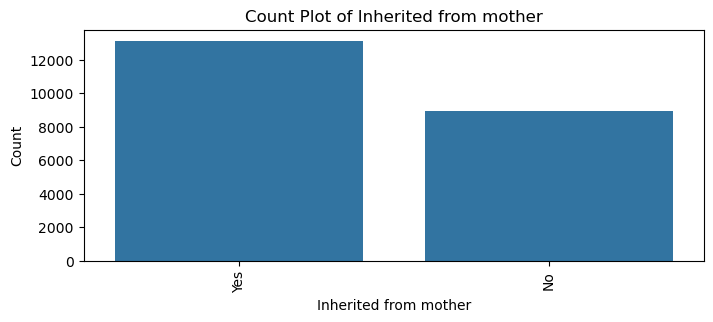

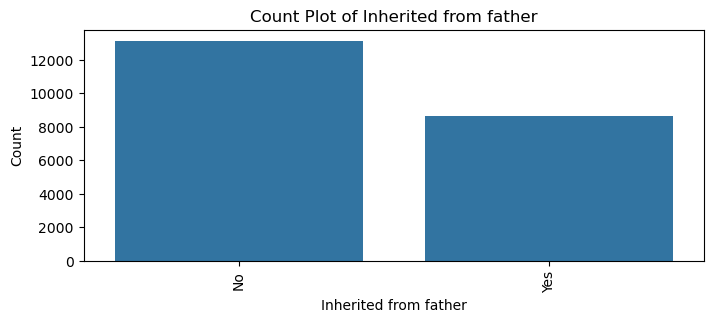

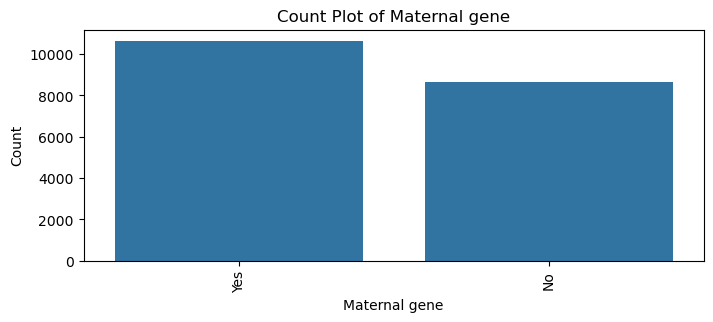

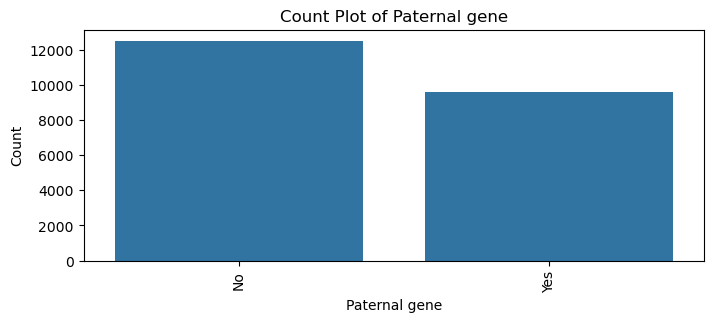

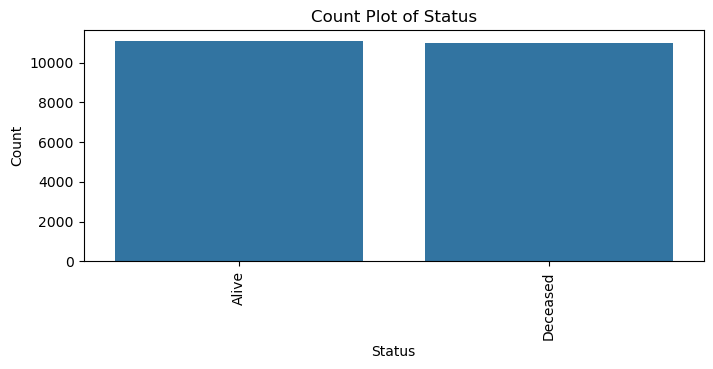

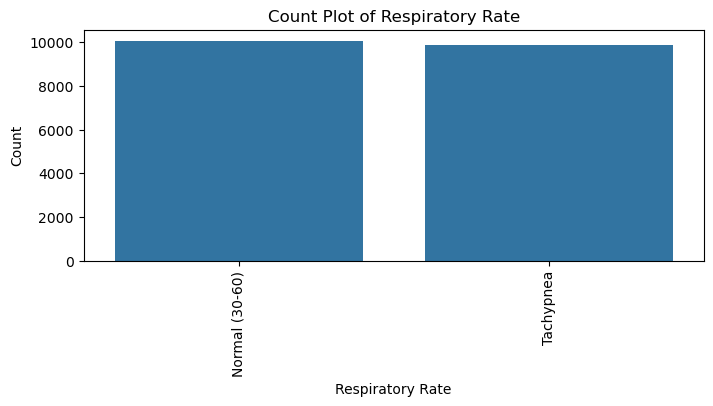

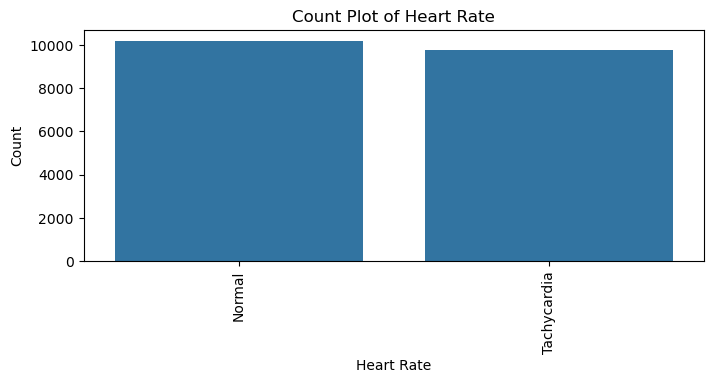

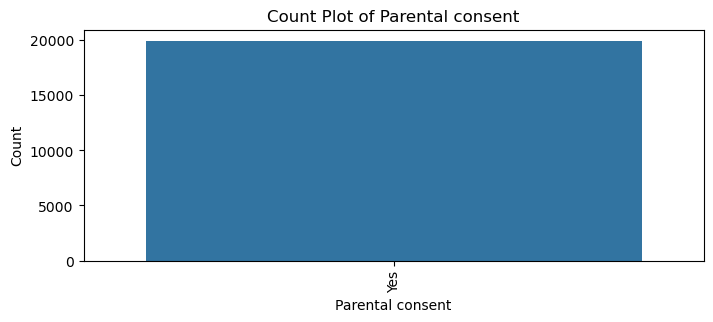

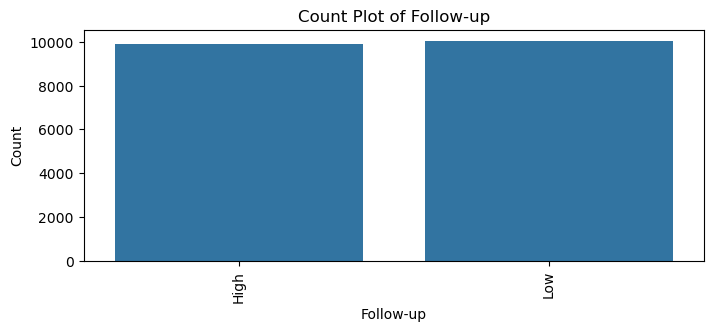

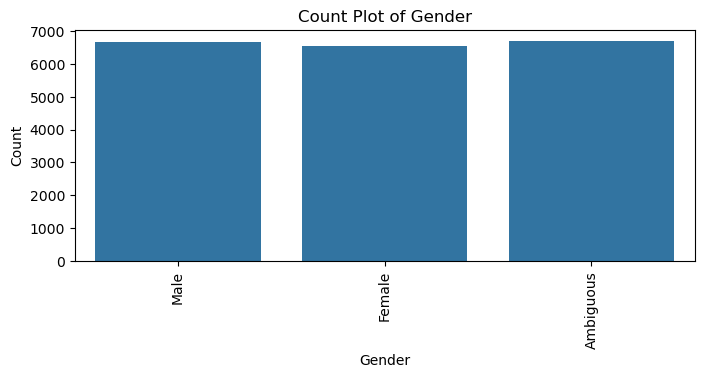

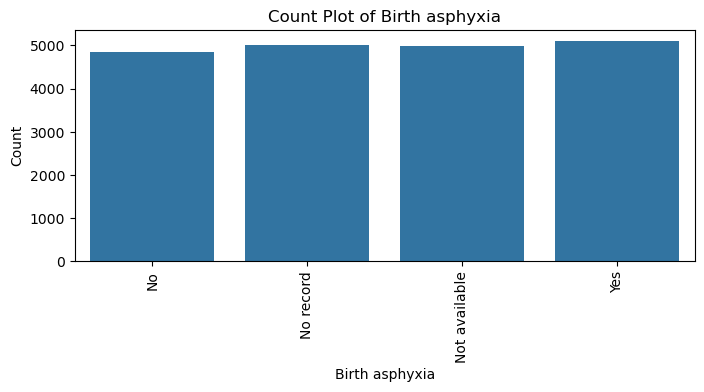

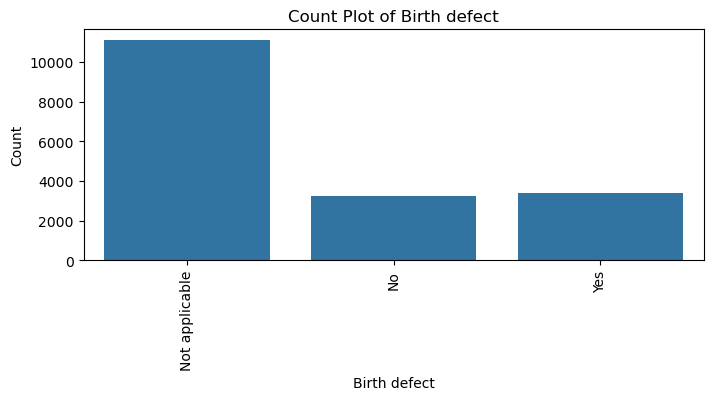

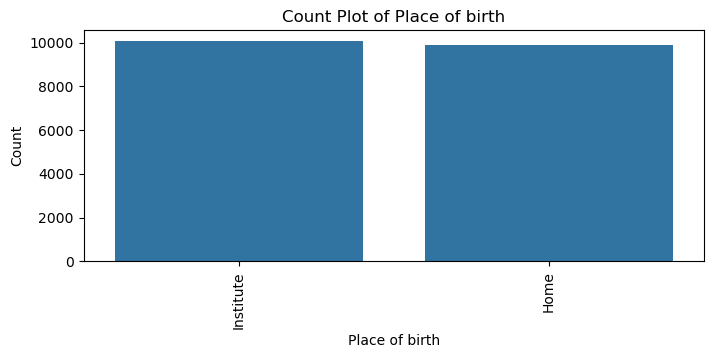

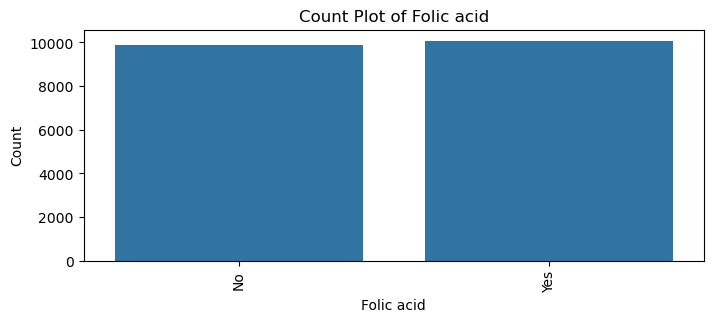

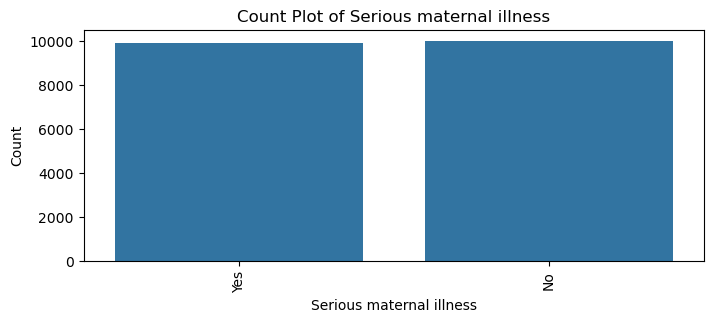

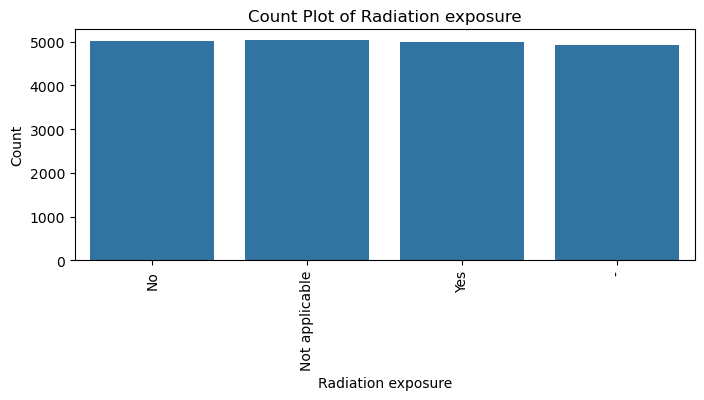

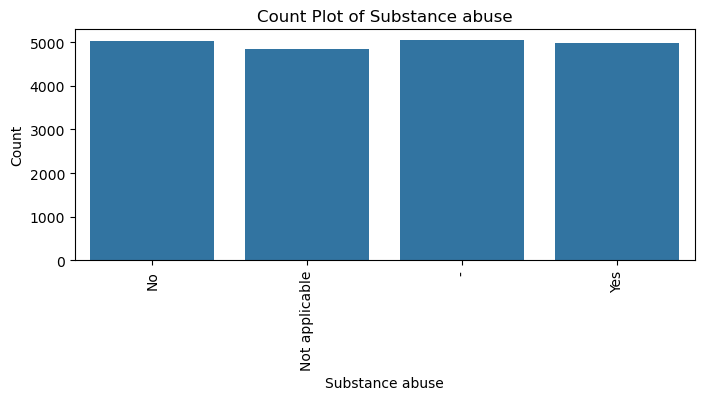

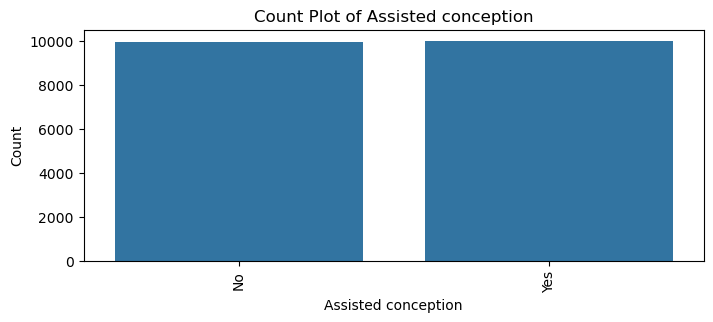

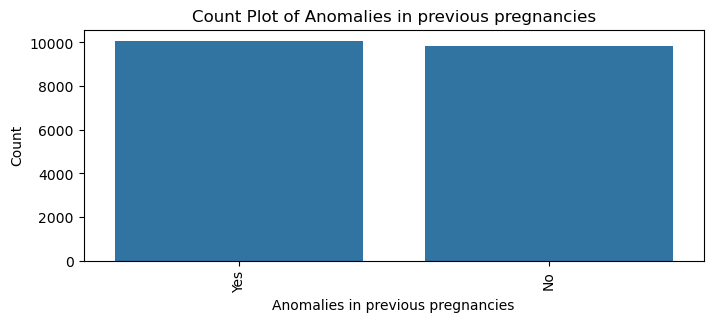

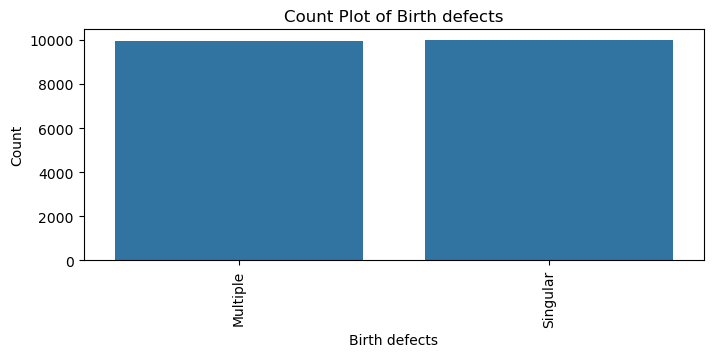

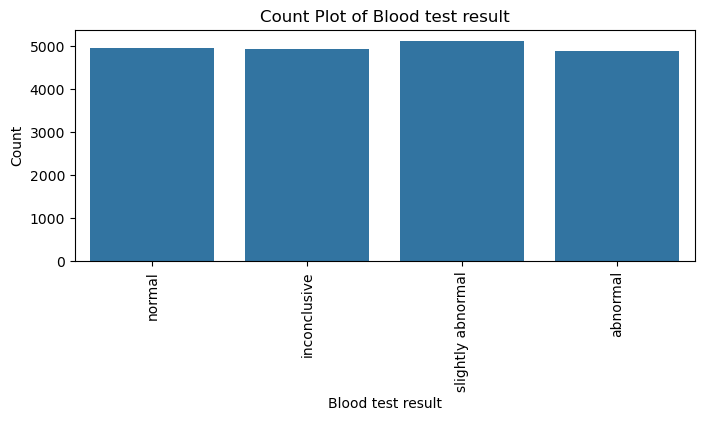

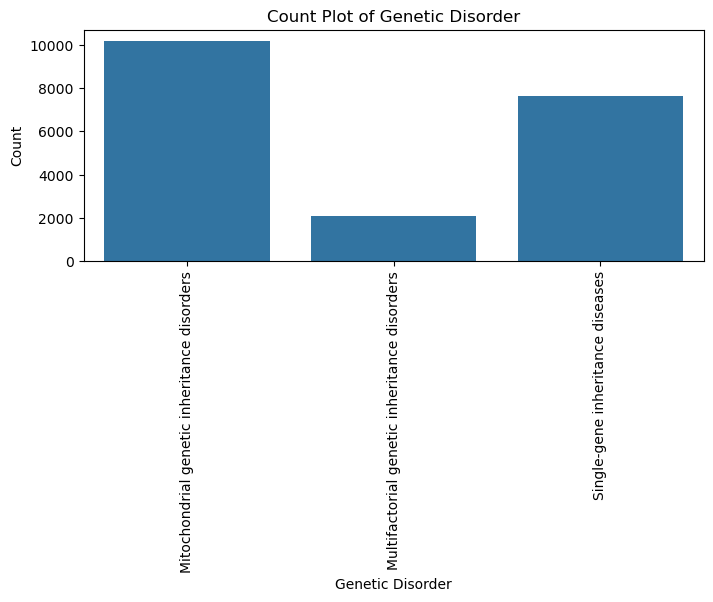

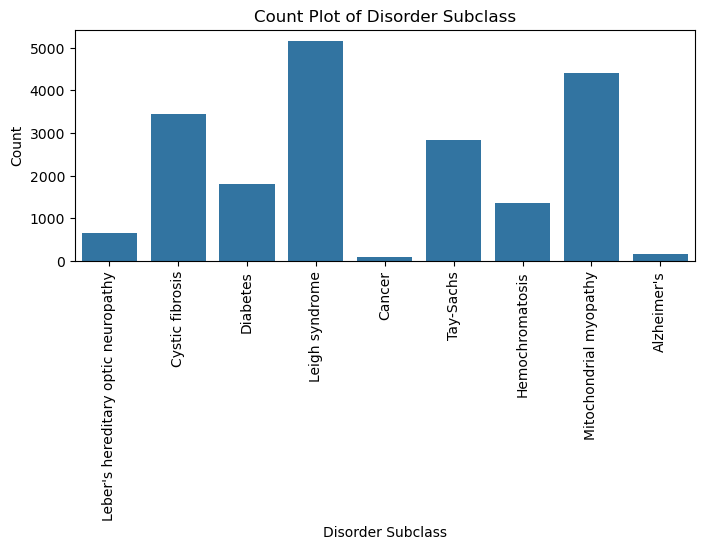

In [63]:
# Loop through each categorical variable and plot histograms to view most popular categories and categorical col distributions
for col in categorical_cols:
    plt.figure(figsize=(8, 3))
    sns.countplot(data=gene, x=col)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=90)
    plt.show()

#### **Data Categorization and Distribution Analysis**: 
To effectively analyze and model this data, we can categorize the features into several groups, this categorization can help in understanding the relationships between different features and their impact on predicting genetic disorders:
- **Patient Demographics**:
    - Patient Age
    - Gender (Ambiguous, male, female) - distribution is quite balanced, slightly higher for ambiguous
- **Patient Birth History**:
    - Birth defect (Yes, No) - **strong skew** towards no birth defects
    - Birth defects (Singular, Multiple) - equal distribution, no significant skew
    - Birth asphyxia (Yes, No) - majority: **strong skew** towards no birth asphyxia
    - Autopsy shows birth defect (Yes, No)
    - Place of birth (Institute or Home)
- **Patient Current Health Status:**
    - Status (alive, deceased) - no significant skew in this category, equal distribution
    - Respiratory Rate (Normal, Tachypnea) - no strong skew, nearly equal distribution
    - Heart Rate (Normal, Tachycardia) - occurrence of a normal heart rate is slightly higher but the difference is not substantial
    - Blood cell count (mcL)
    - White Blood cell count (thousand per microliter)
    - Blood test result (Slightly abnormal, normal, Inconclusive, abnormal) - relatively balanced, no strong skew
    - Test 1 - Test 5 (1, 0)
    - Symptom 1 - Symptom 5 (1, 0)
- **Parents Demographics**
    - Mother's age
    - Father's age
- **Genetic Information**
    - Genes in mother's side (Yes, No) - skew towards maternal inheritance
    - Inherited from father (Yes, No) - skew towards no paternal inheritance
    - Maternal gene (Yes, No) - higher occurrence of maternal gene, difference is less pronounced
    - Paternal gene (Yes, No) - higher occurrence of no paternal gene
- **Pregnancy related factors**
    - H/O serious maternal illness (Yes, No) - equal distribution, no significant skew
    - Folic acid details (peri-conceptional) (Yes, No) - equal distribution, no significant skew
    - Assisted conception IVF/ART (Yes, No) - equal distribution, no significant skew
- **Environmental factors**
    - H/O radiation exposure (x-ray) (Yes, No) - strong skew towards no radiation exposure
    - H/O substance abuse (Yes, No) - strong skew towards no substance abuse
- **Previous Pregnancies**
    - History of anomalies in previous pregnancies (Yes, No) - nearly even distribution, no strong skew
    - No. of previous abortions
- **Consents & Follow-ups**
    - Parental consent - all cases have parental consent
    - Follow-up (Low, High) - no significant skew in this category, equal distribution
- **Target Variables**
    - Genetic Disorder (target variable) - a skew towards mitochondrial disorders
    - Disorder Subclass (target variable) -  skewed towards a few dominant subclasses

### Bivariate Analysis

##### **Correlation Analysis - Numerical vs. Numerical variables**
- Compute the correlation matrix for numeric features using .corr().
- Visualize correlations using a heatmap.
- Explore relationships between features, especially between features and the target variable.
    - Use pair plots or scatter plots for this purpose.

In [68]:
gene.corr(numeric_only=True)

Patient Age  Blood cell count  Mother age  \
Patient Age                 1.000000          0.010819   -0.007588   
Blood cell count            0.010819          1.000000   -0.007163   
Mother age                 -0.007588         -0.007163    1.000000   
Father age                 -0.009797          0.003303   -0.000336   
Test 4                           NaN               NaN         NaN   
Previous abortion count    -0.007281         -0.005995    0.007844   
WBC count                  -0.008489         -0.001037    0.015443   
Symptom 1                   0.003335          0.005793   -0.006920   
Symptom 2                   0.007506         -0.003913   -0.012243   
Symptom 3                  -0.018755          0.006519    0.008079   
Symptom 4                  -0.007470          0.005341   -0.009321   
Symptom 5                  -0.014463          0.002281    0.011743   

                         Father age  Test 4  Previous abortion count  \
Patient Age               -0.009797     NaN                -0.007281   
Blood cell count           0.003303     NaN                -0.005995   
Mother age                -0.000336     NaN                 0.007844   
Father age                 1.000000     NaN                 0.000539   
Test 4                          NaN     NaN                      NaN   
Previous abortion count    0.000539     NaN                 1.000000   
WBC count                  0.012954     NaN                 0.003807   
Symptom 1                  0.005452     NaN                -0.007495   
Symptom 2                 -0.003314     NaN                 0.007169   
Symptom 3                  0.012519     NaN                -0.000746   
Symptom 4                 -0.001118     NaN                 0.003735   
Symptom 5                  0.011630     NaN                -0.004264   

                         WBC count  Symptom 1  Symptom 2  Symptom 3  \
Patient Age              -0.008489   0.003335   0.007506  -0.018755   
Blood cell count         -0.001037   0.005793  -0.003913   0.006519   
Mother age                0.015443  -0.006920  -0.012243   0.008079   
Father age                0.012954   0.005452  -0.003314   0.012519   
Test 4                         NaN        NaN        NaN        NaN   
Previous abortion count   0.003807  -0.007495   0.007169  -0.000746   
WBC count                 1.000000   0.000442   0.008489   0.008472   
Symptom 1                 0.000442   1.000000   0.002014   0.005559   
Symptom 2                 0.008489   0.002014   1.000000   0.008689   
Symptom 3                 0.008472   0.005559   0.008689   1.000000   
Symptom 4                 0.001592  -0.000530   0.014627   0.002794   
Symptom 5                -0.013023   0.015840   0.011601   0.028203   

                         Symptom 4  Symptom 5  
Patient Age              -0.007470  -0.014463  
Blood cell count          0.005341   0.002281  
Mother age               -0.009321   0.011743  
Father age               -0.001118   0.011630  
Test 4                         NaN        NaN  
Previous abortion count   0.003735  -0.004264  
WBC count                 0.001592  -0.013023  
Symptom 1                -0.000530   0.015840  
Symptom 2                 0.014627   0.011601  
Symptom 3                 0.002794   0.028203  
Symptom 4                 1.000000   0.036785  
Symptom 5                 0.036785   1.000000

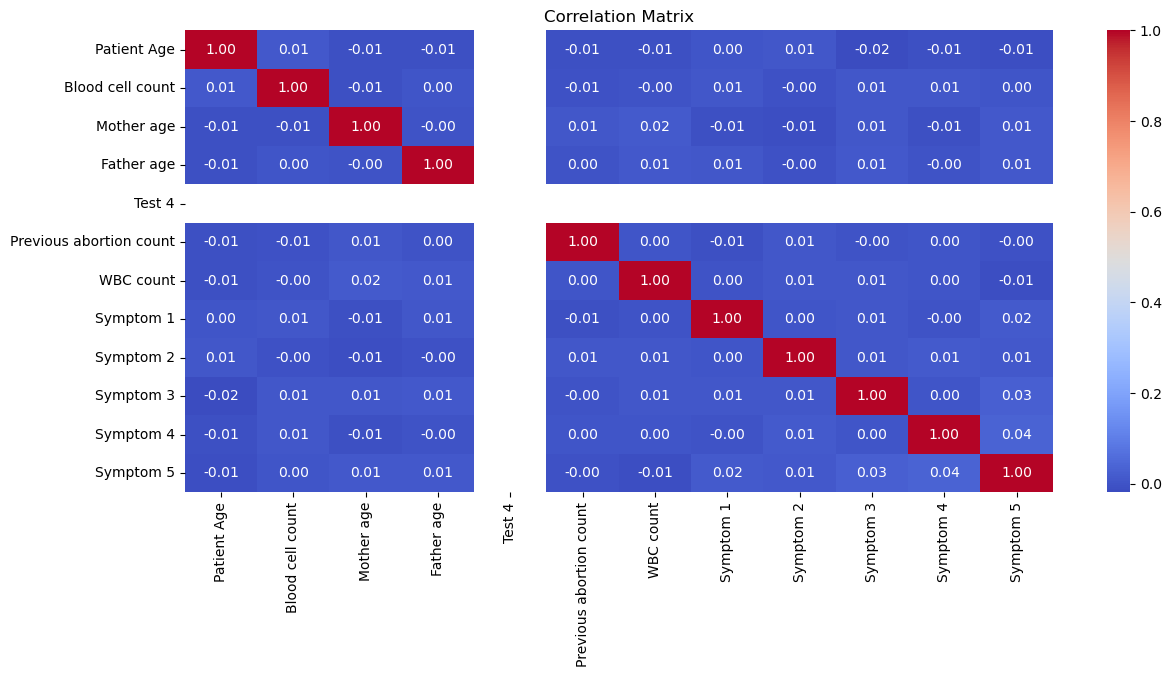

In [70]:
# Visualize correlations
plt.figure(figsize=(14, 6))
sns.heatmap(gene.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Correlation Summary:**
- The correlation matrix shows how each feature in the dataset is related to the others. 
- Most correlations are close to zero, indicating weak or no linear relationships between the variables.
- The strongest positive correlation is seen between Symptom 4 and Symptom 5 (0.0368)
- Patient Age has minimal correlations with other features.
- The NaN values for Test 4 suggest there was no data available for this feature, leading to undefined correlations.

#### Explore relationships between features, especially between features and the target variable.
- Use pair plots or scatter plots for this purpose.

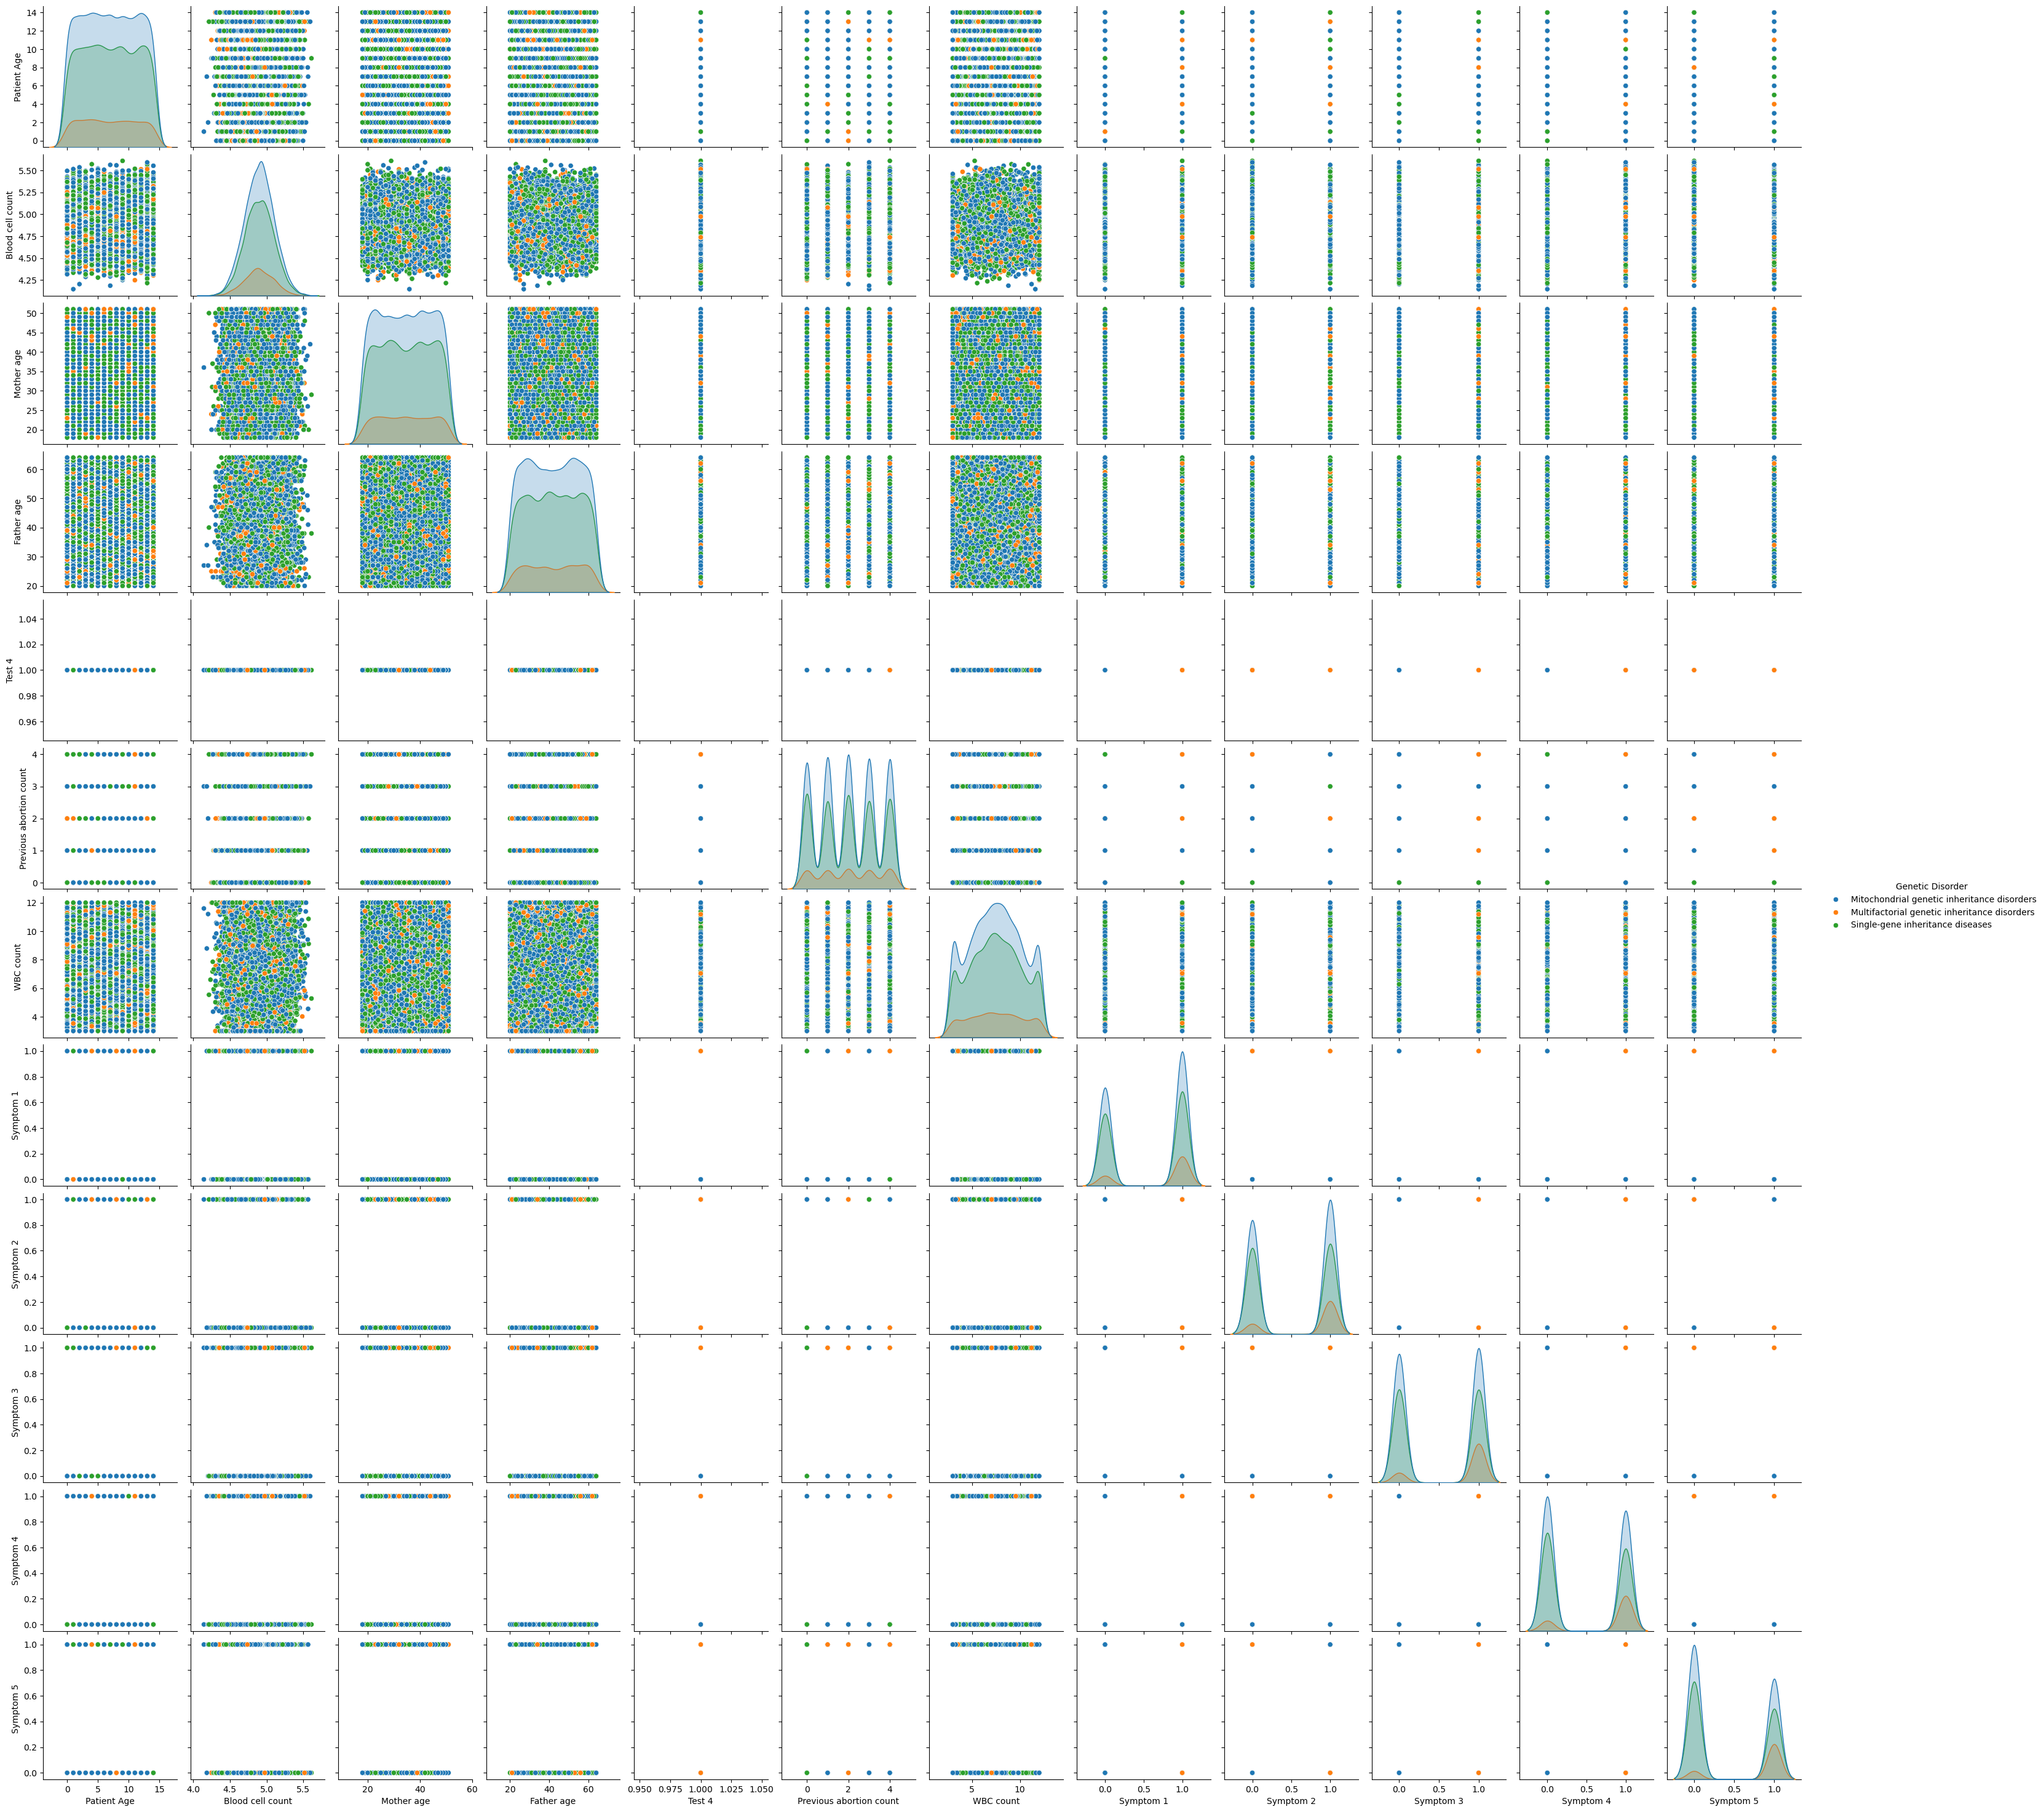

In [74]:
sns.pairplot(gene, hue='Genetic Disorder')
plt.show()

##### **Categorical Vs. Categorical Variables**
- Histograms for all categorical variable to visualize the distribution by target variable (Genetic Disorder)

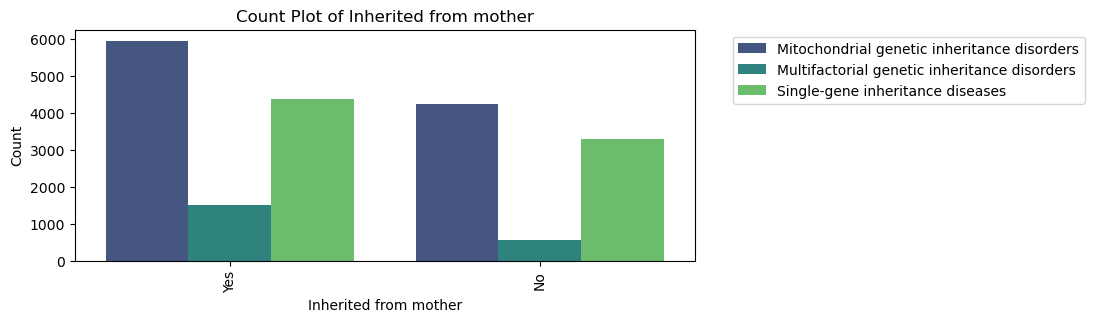

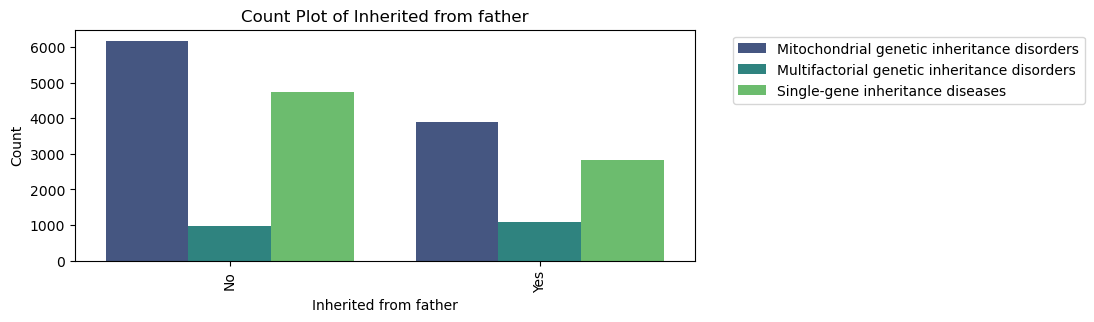

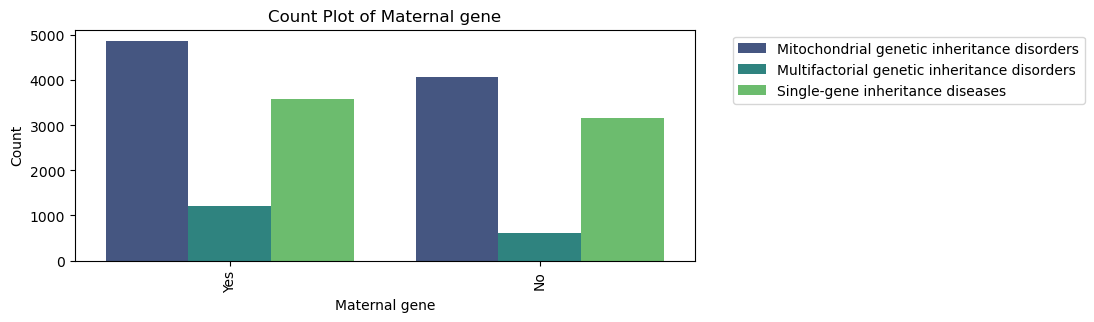

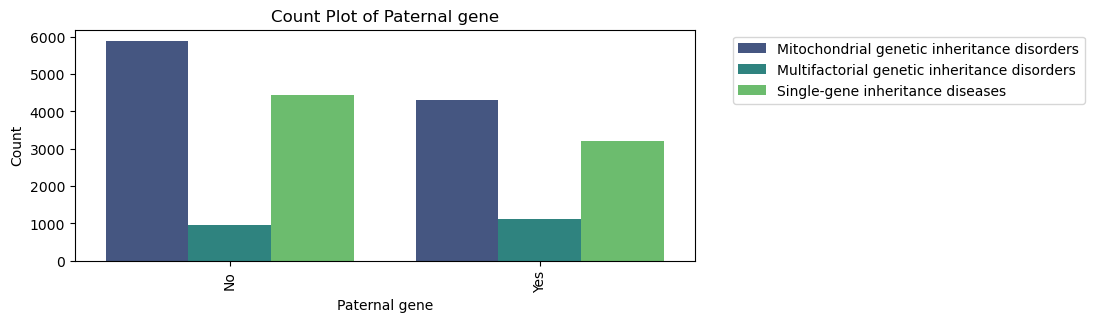

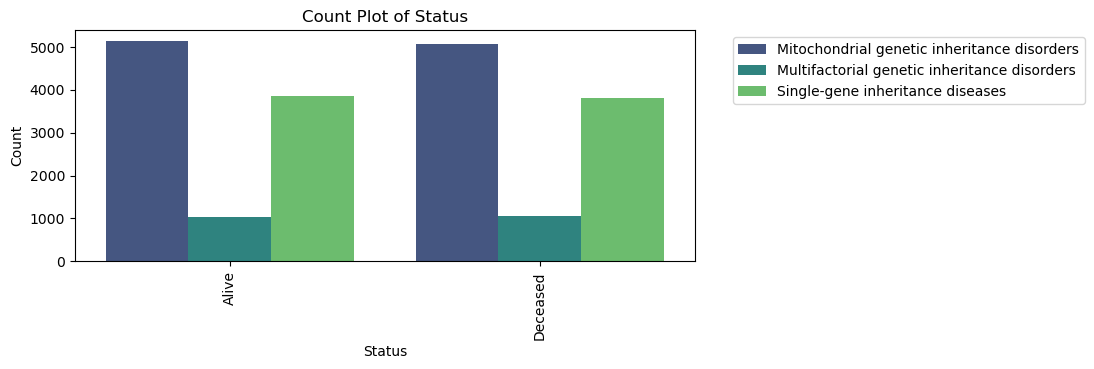

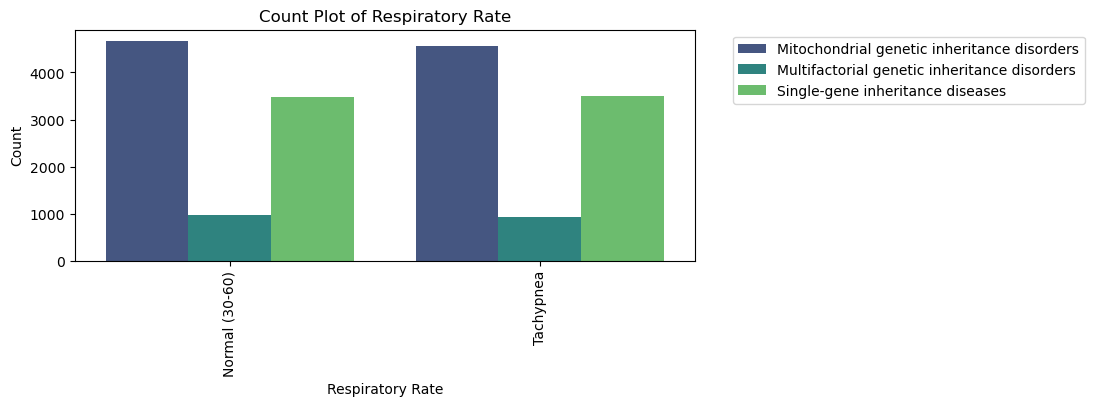

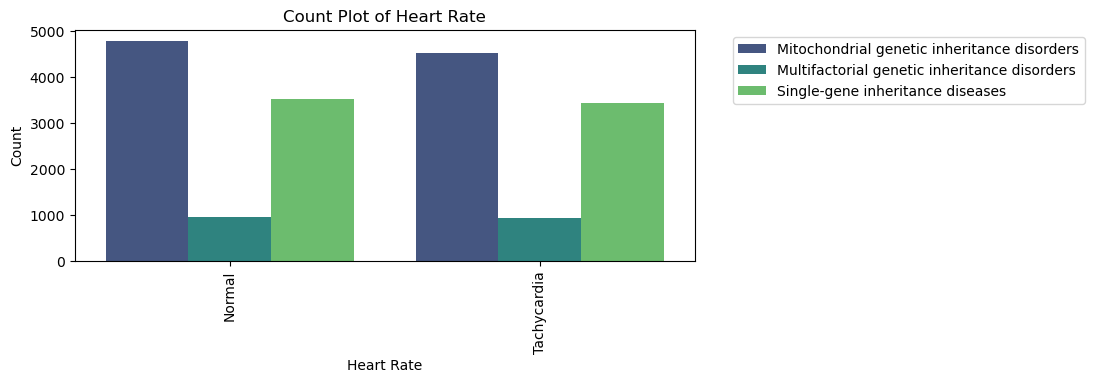

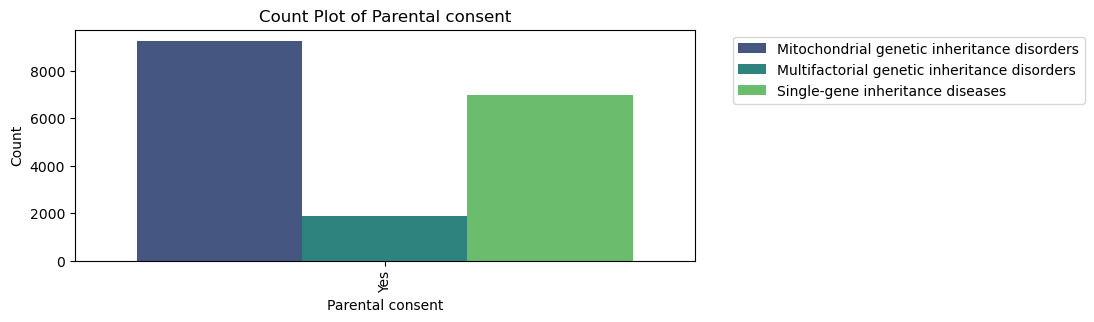

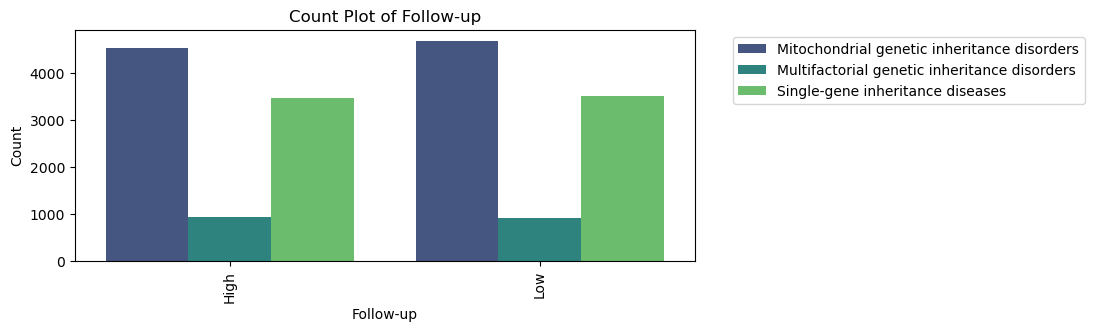

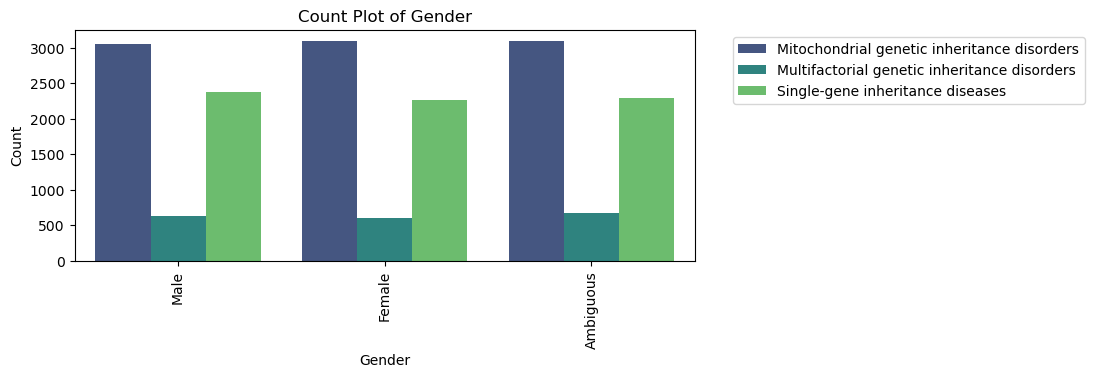

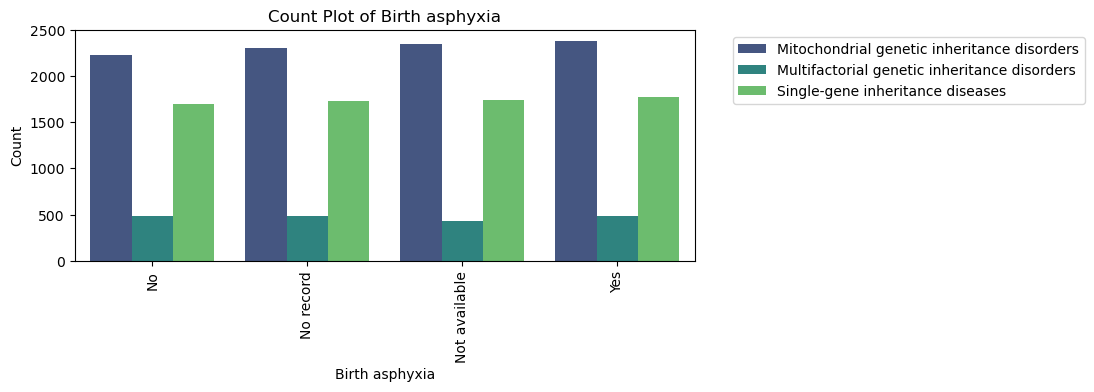

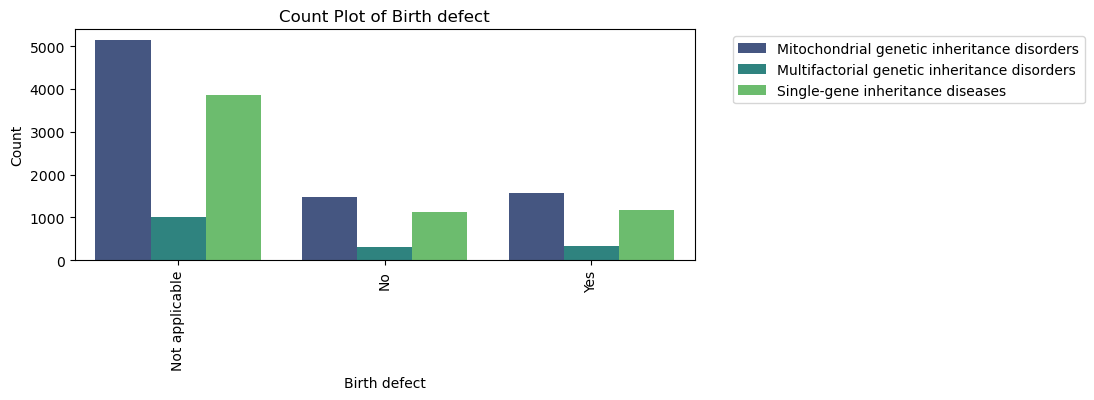

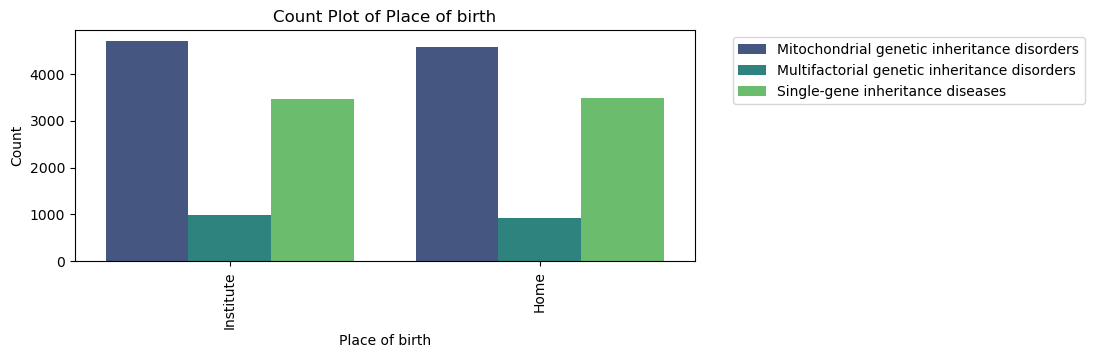

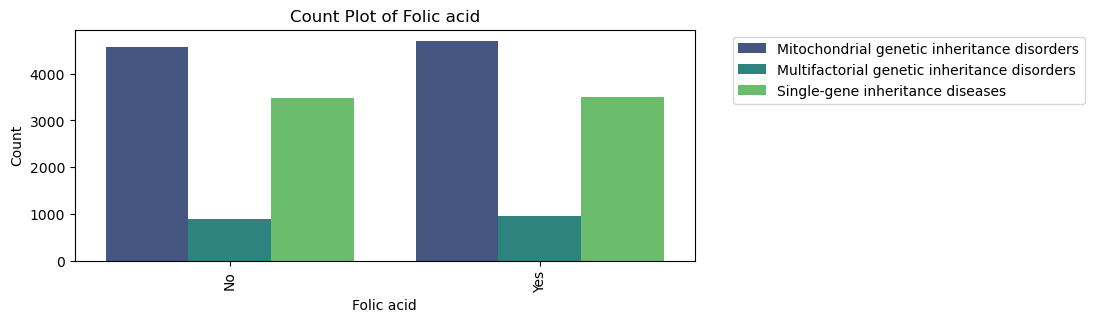

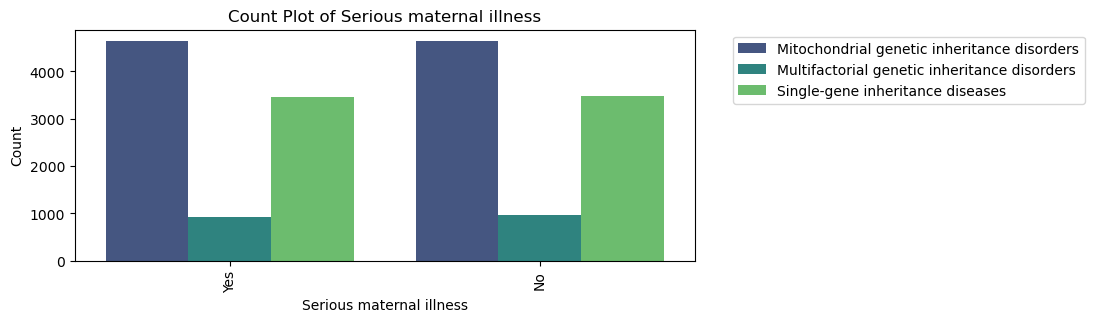

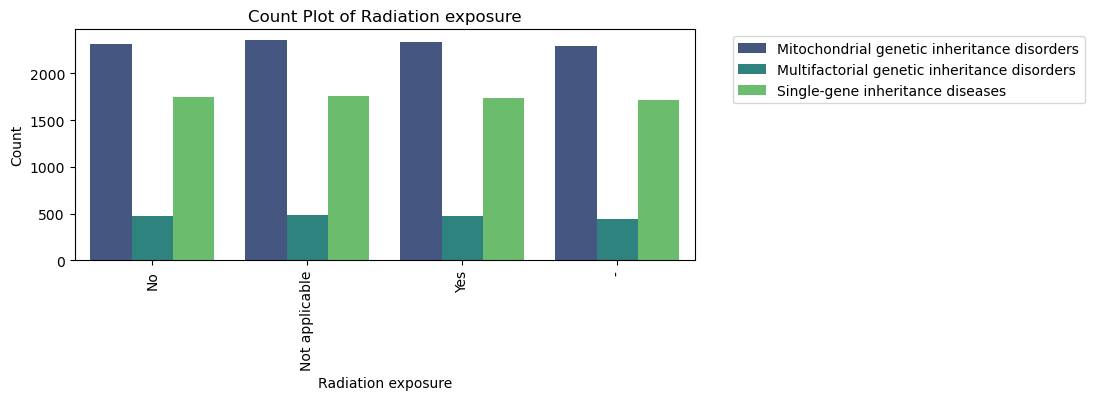

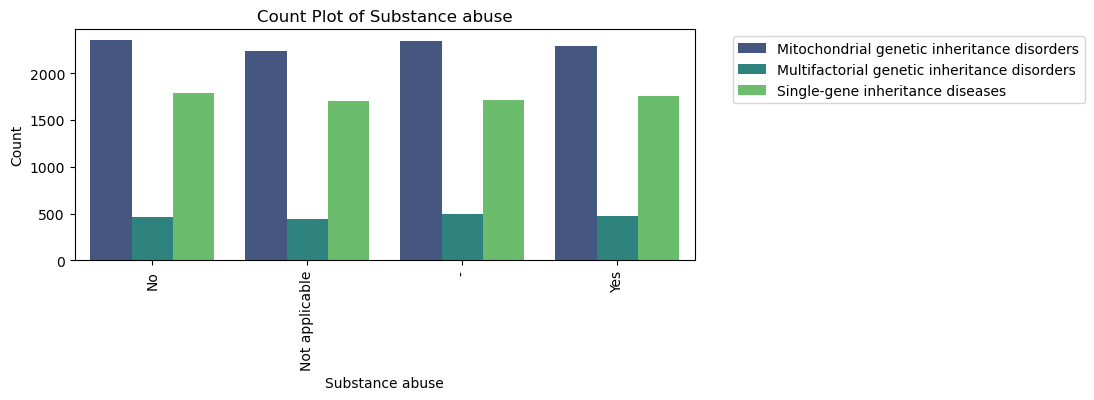

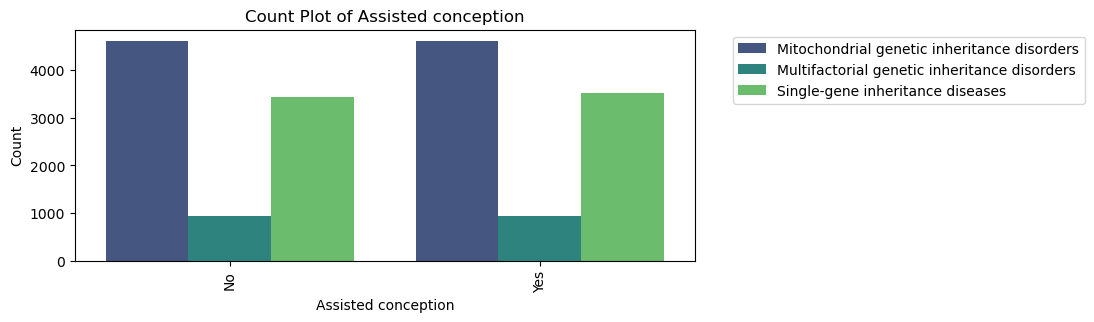

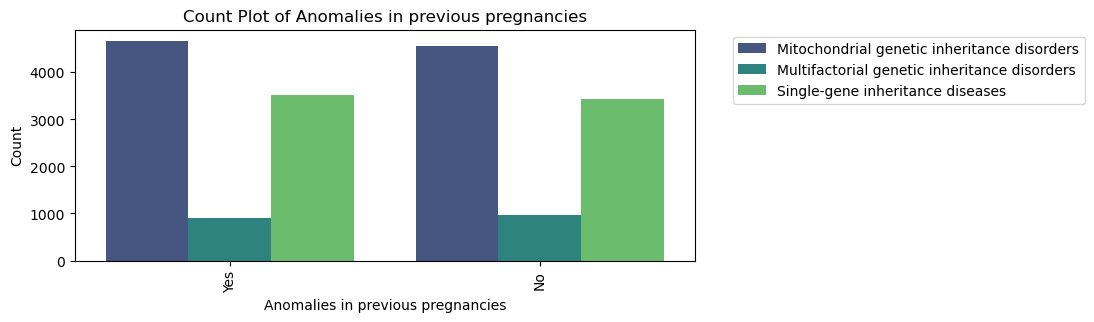

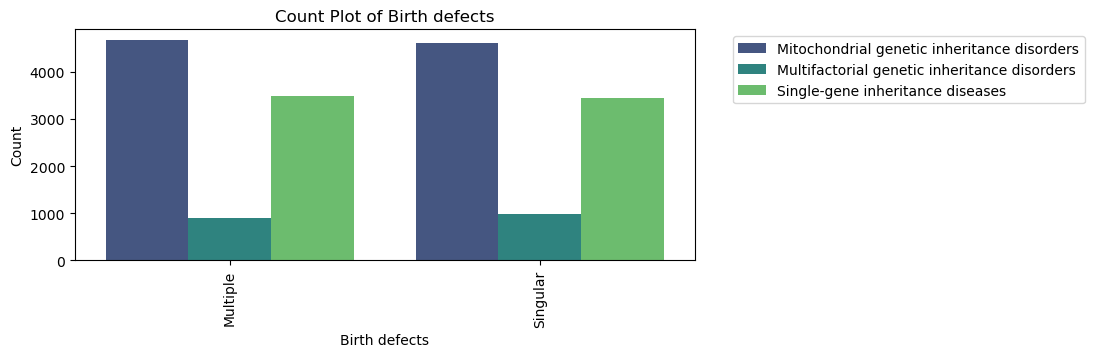

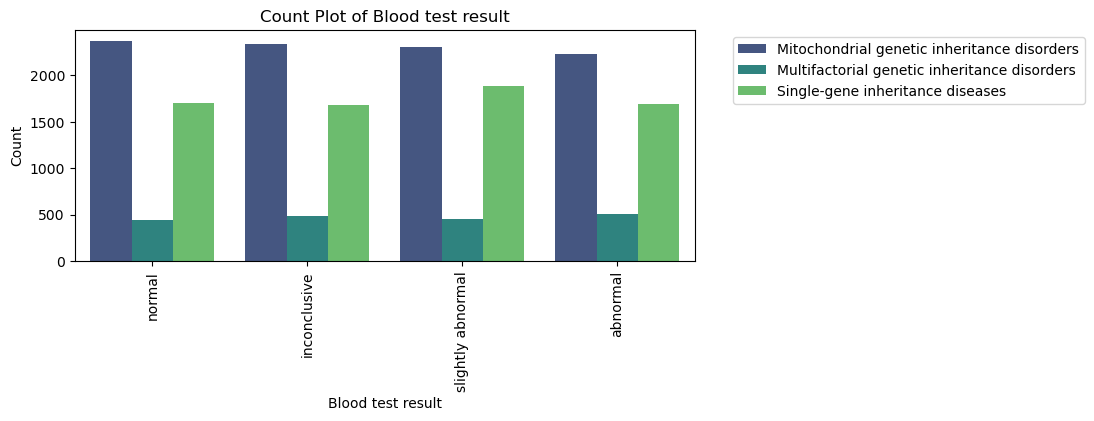

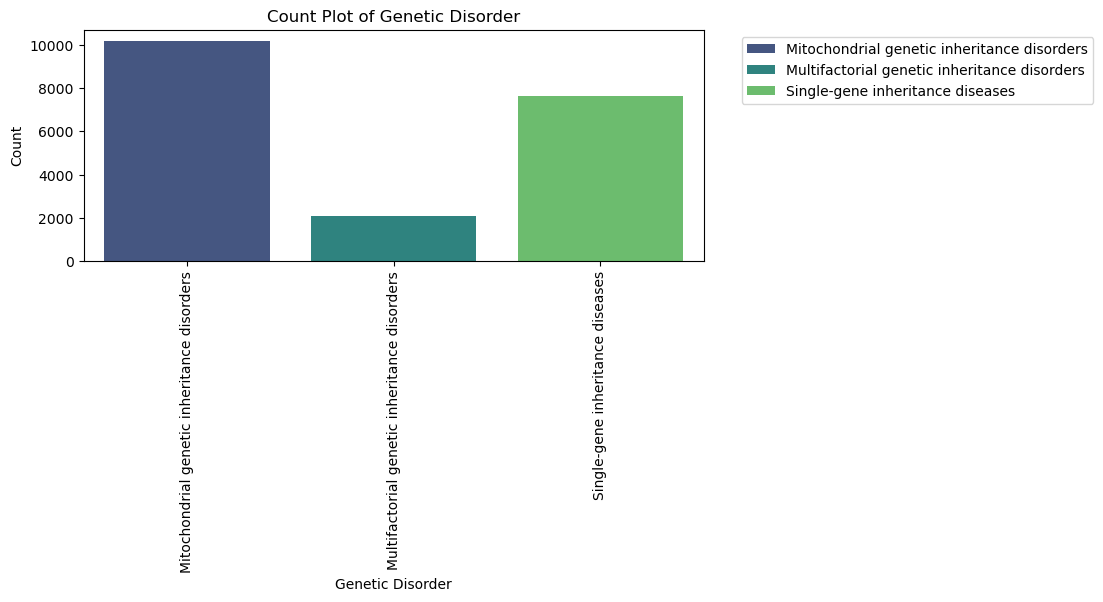

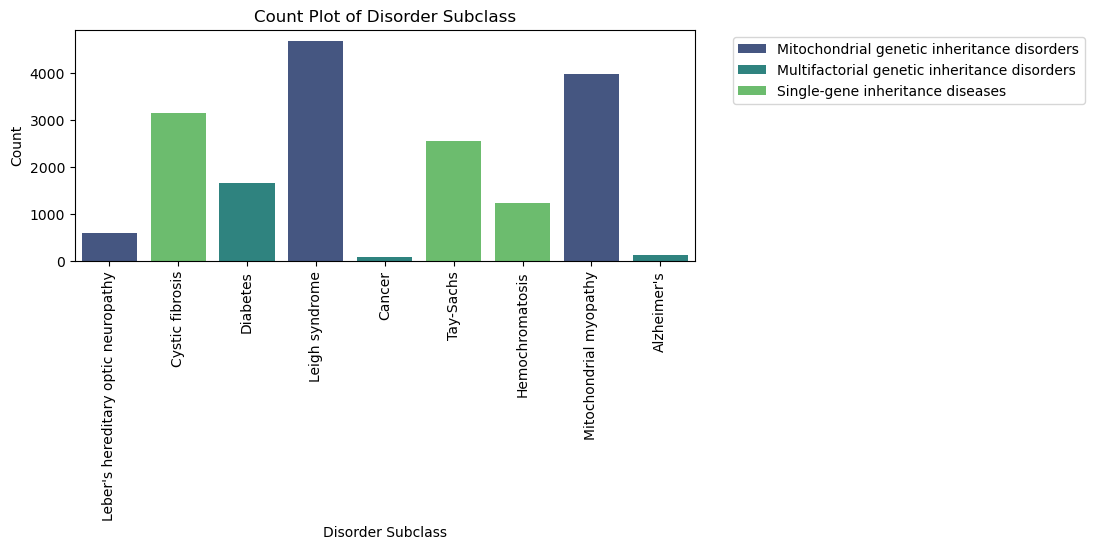

In [76]:
# Loop through each categorical variable and plot histograms to visualizes the distribution by the target variable (Genetic Disorder)
for col in categorical_cols:
    plt.figure(figsize=(8, 3))
    sns.countplot(data=gene, x=col, hue='Genetic Disorder', palette='viridis')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=90)
    plt.show()

##### **Numerical vs. Categorical:** 
Box plots and  bar plots to explore how a numerical variable impacts target variable.

**Box plots, bar plots for Numerical Vs. Target cols**

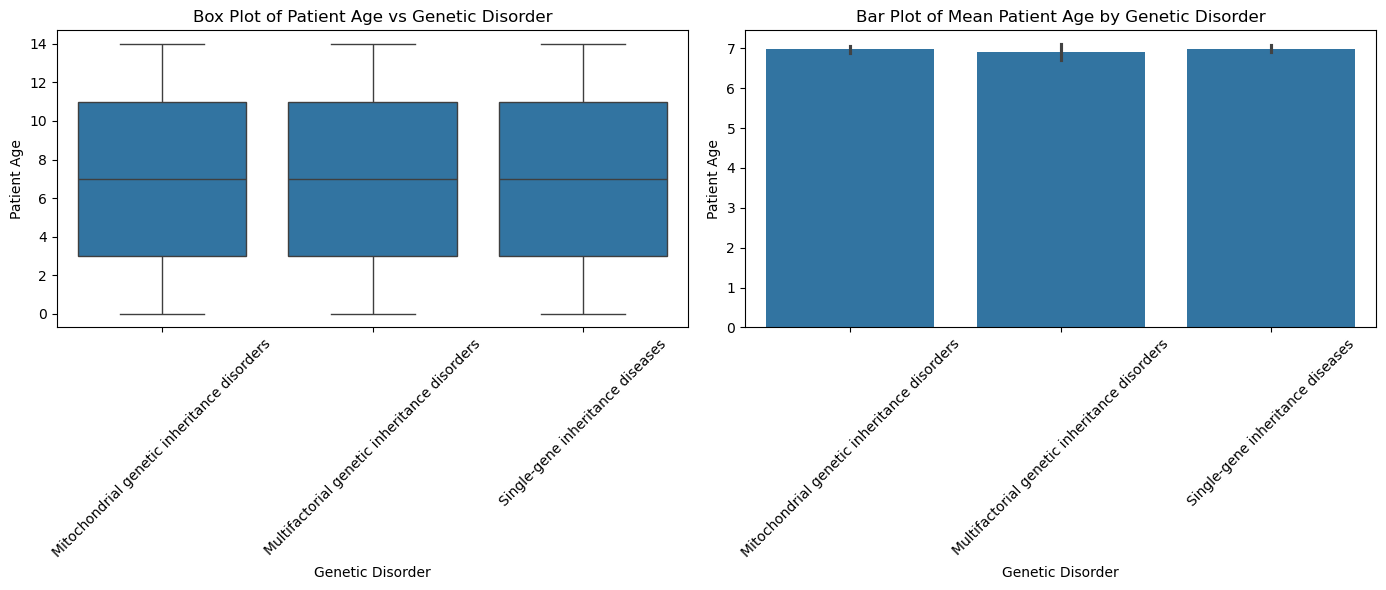

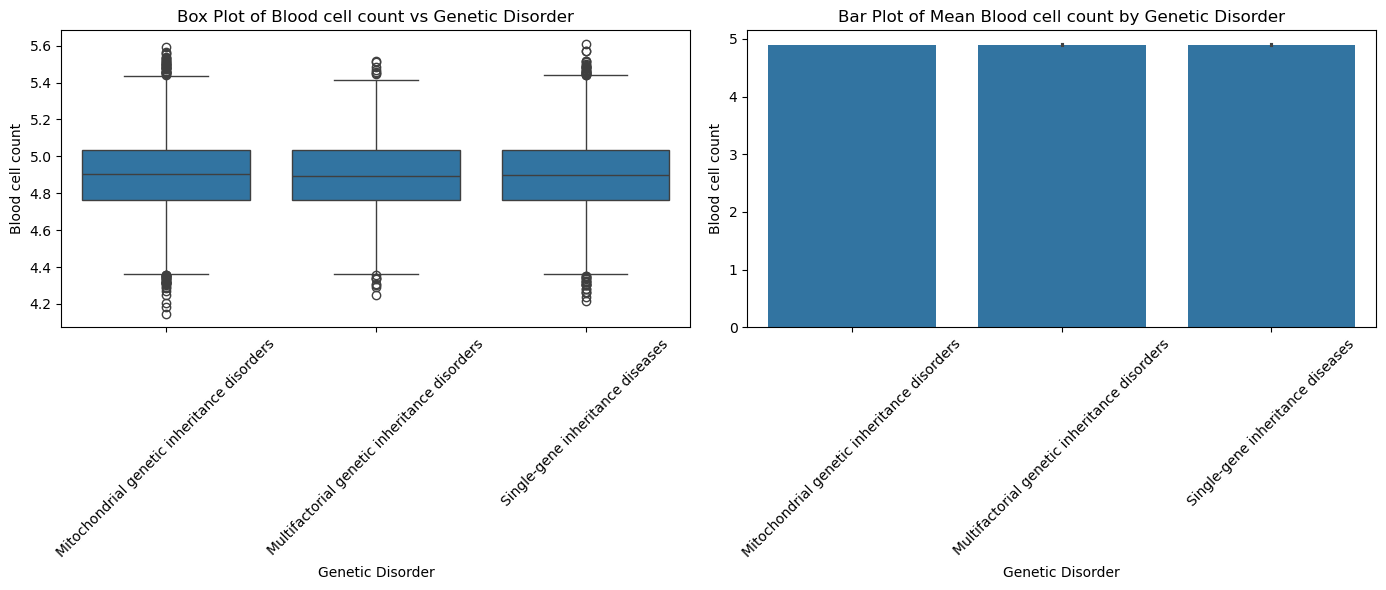

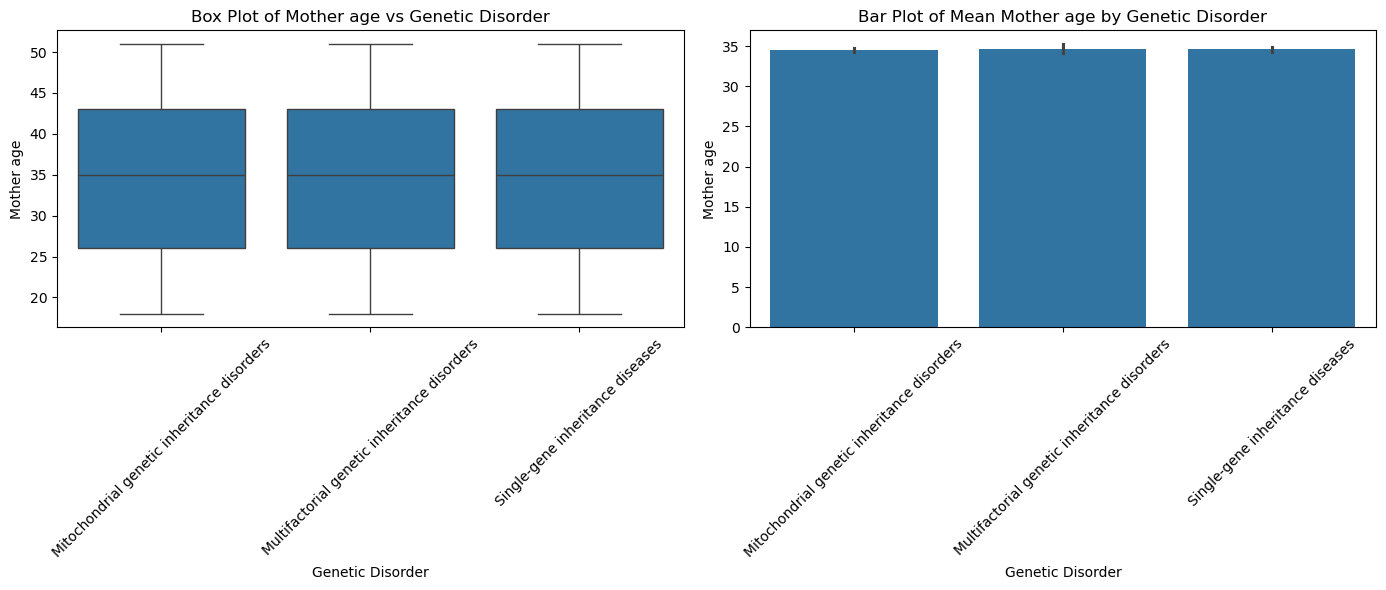

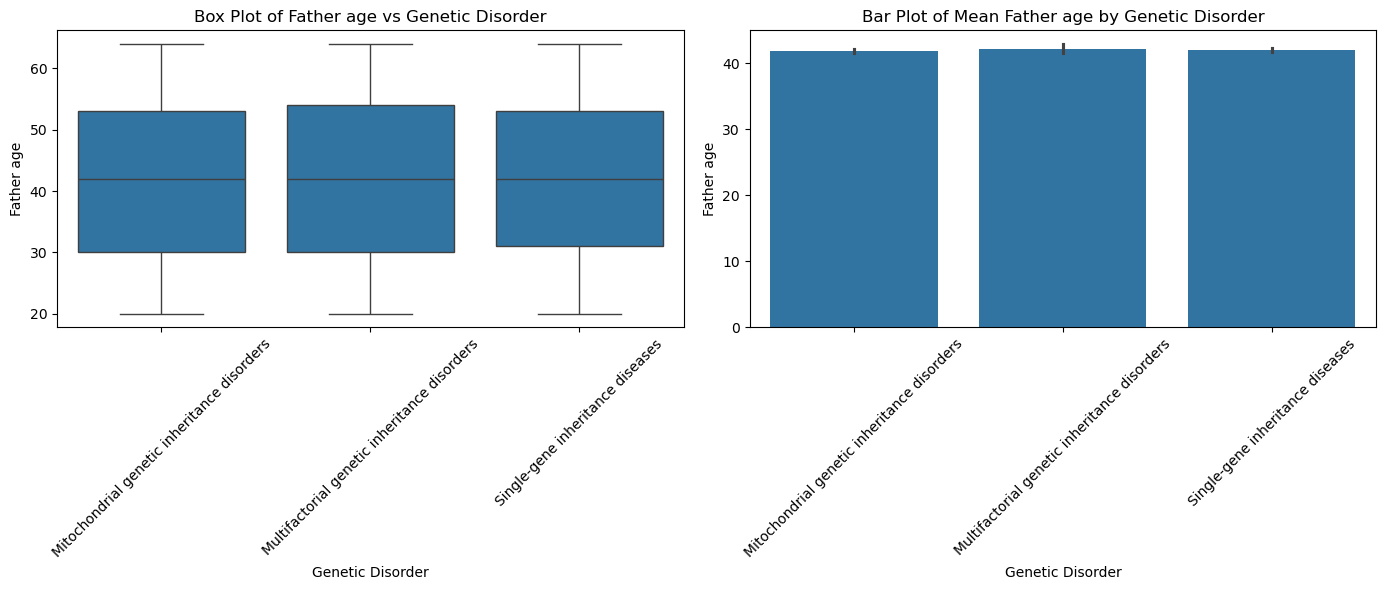

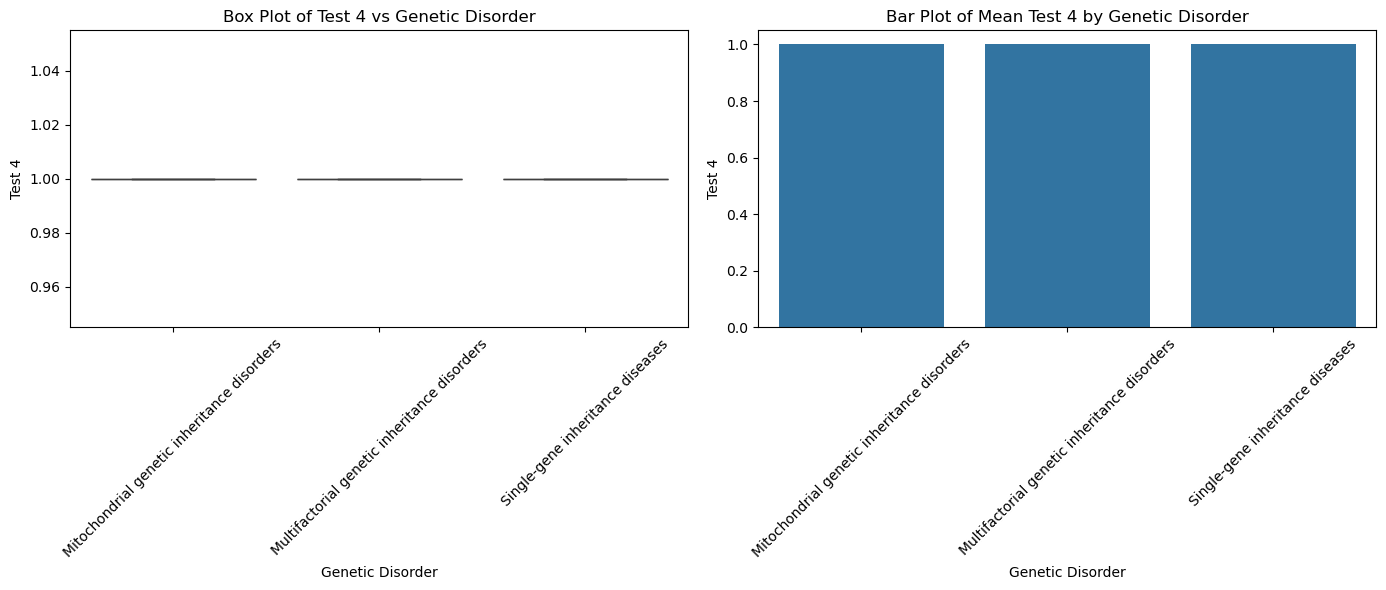

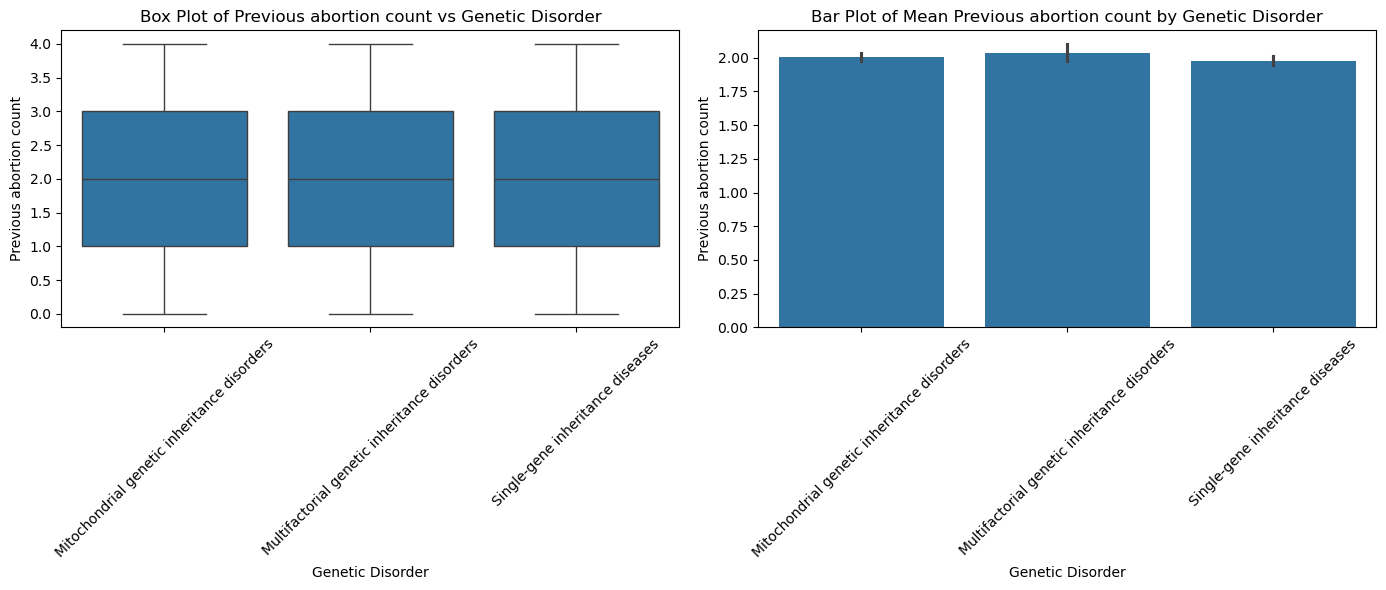

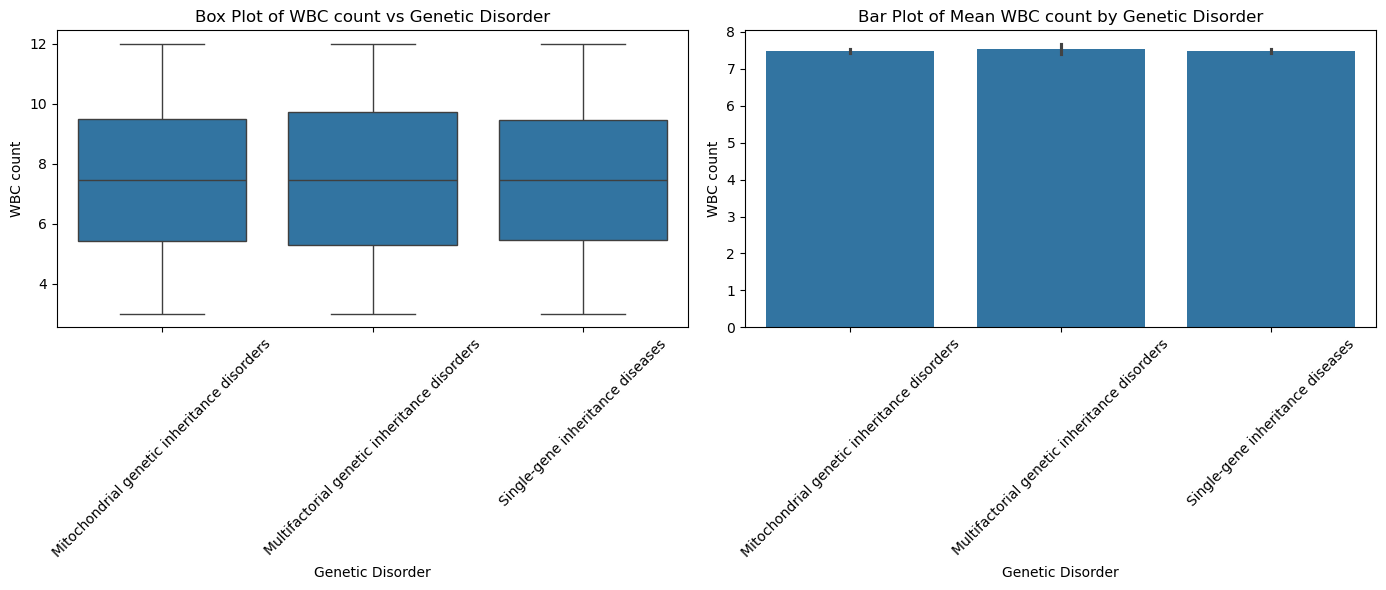

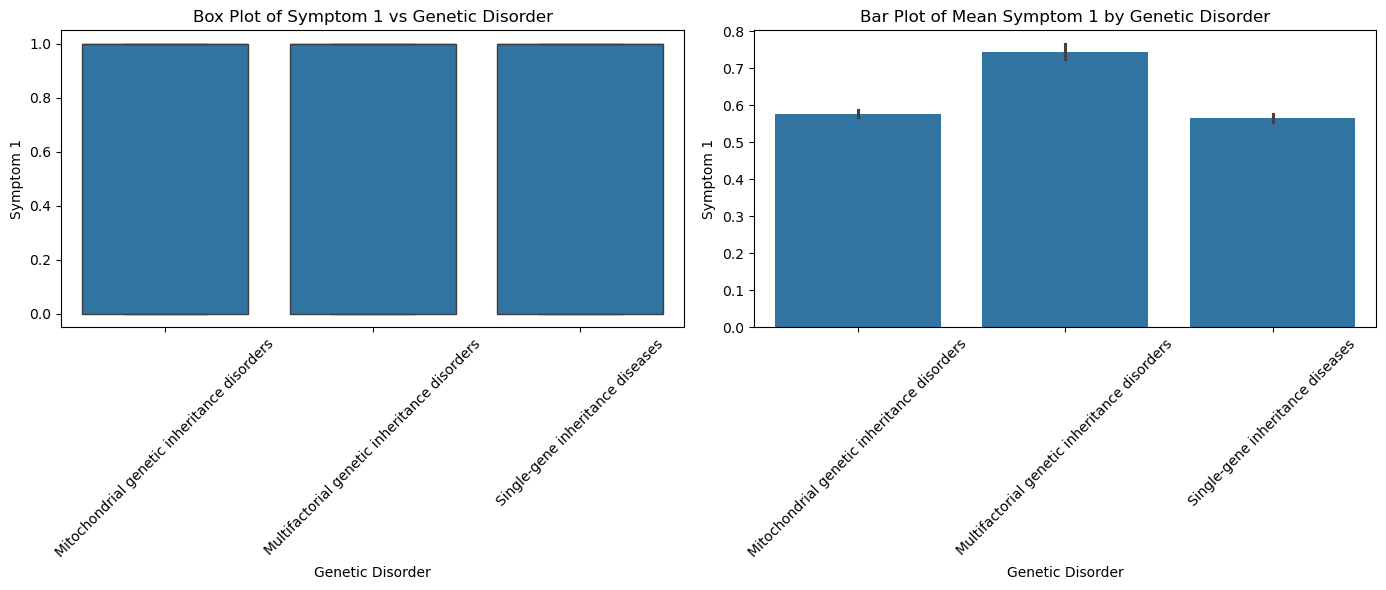

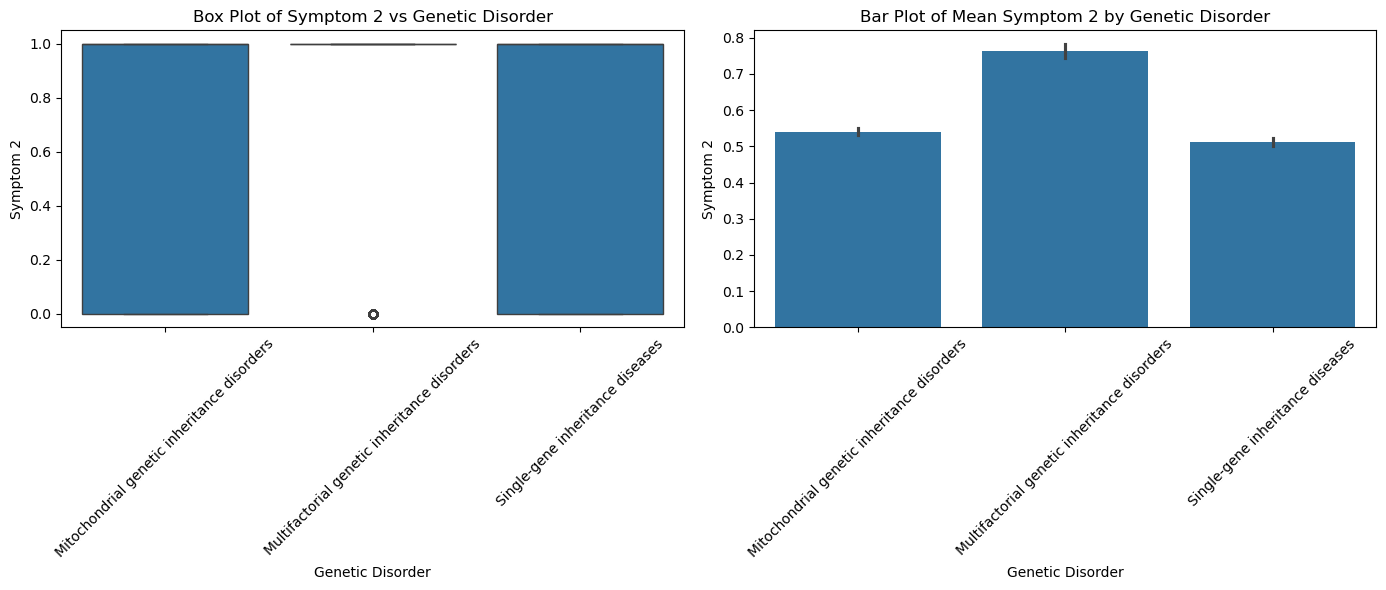

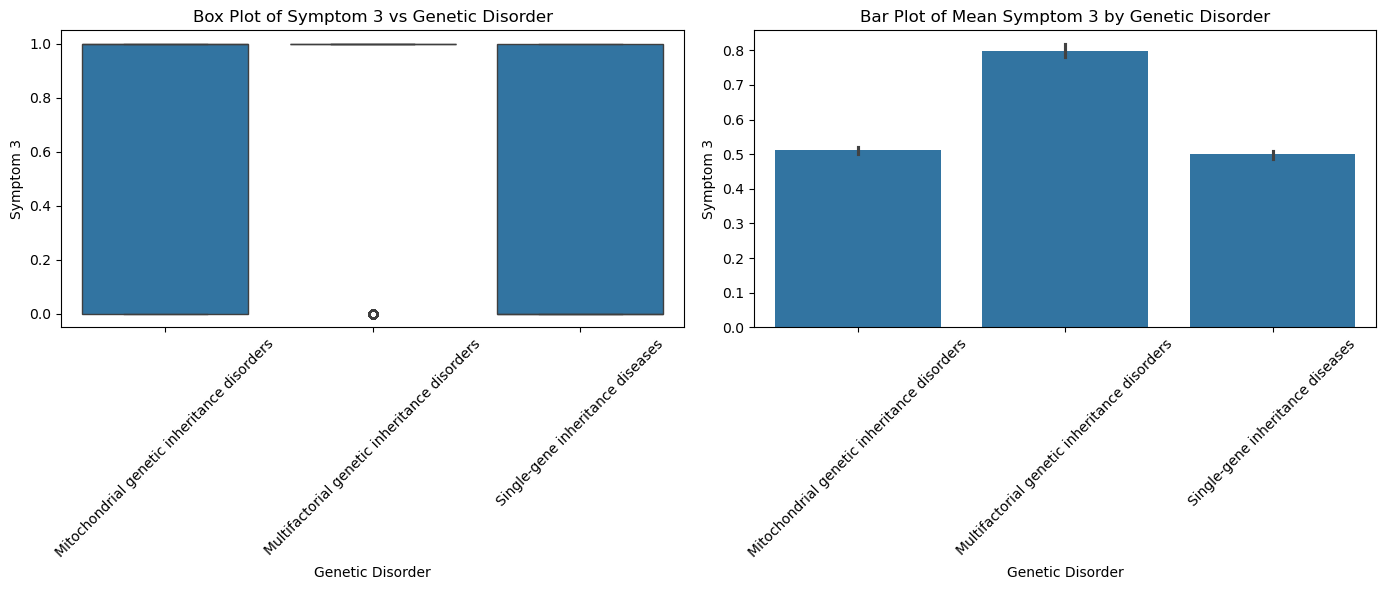

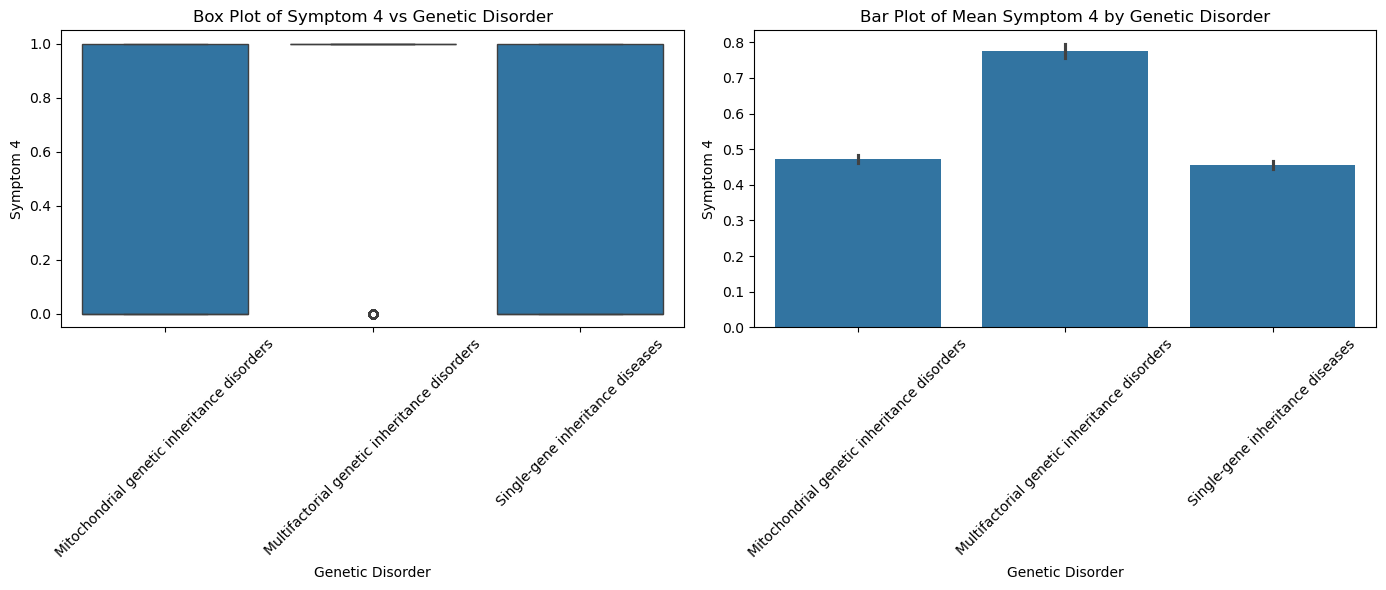

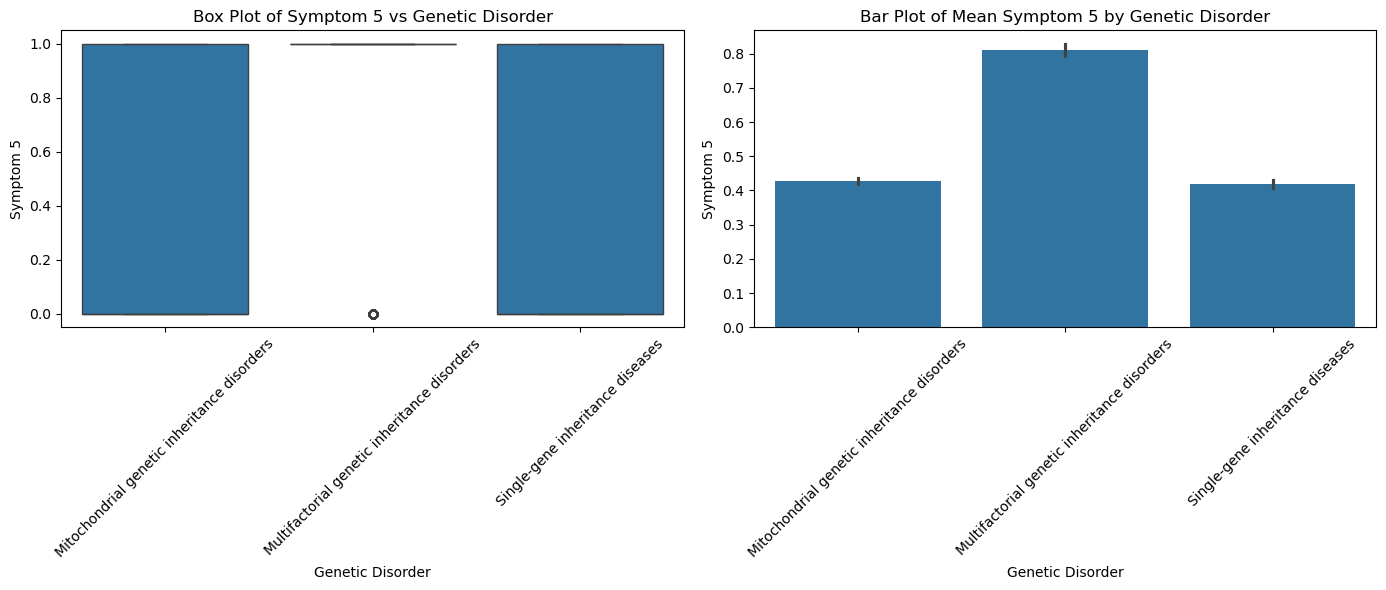

In [79]:
# Iterate over each numerical column and create the plots
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 grid for each numerical column
    
    # Box plot
    sns.boxplot(x='Genetic Disorder', y=col, data=gene, ax=axes[0])
    axes[0].set_title(f'Box Plot of {col} vs Genetic Disorder')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for the box plot
    
    # Bar plot showing the mean of each class
    sns.barplot(x='Genetic Disorder', y=col, data=gene, ax=axes[1], estimator=lambda x: x.mean())
    axes[1].set_title(f'Bar Plot of Mean {col} by Genetic Disorder')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for the bar plot
    
    plt.tight_layout()
    plt.show()

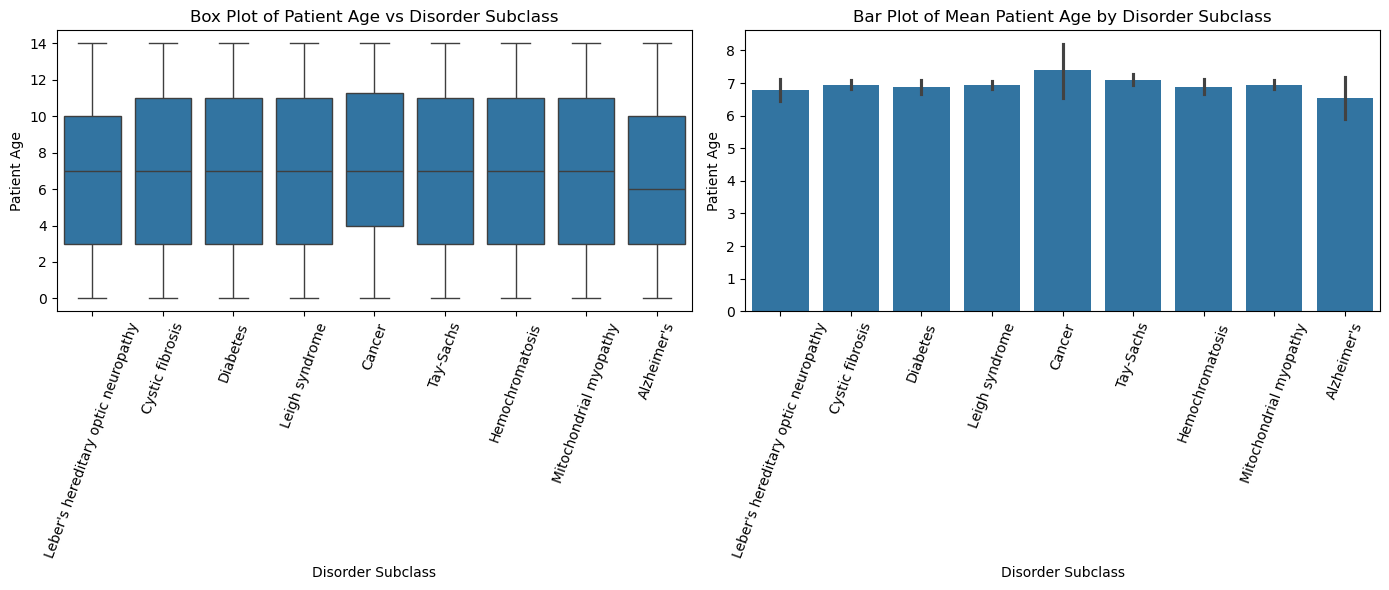

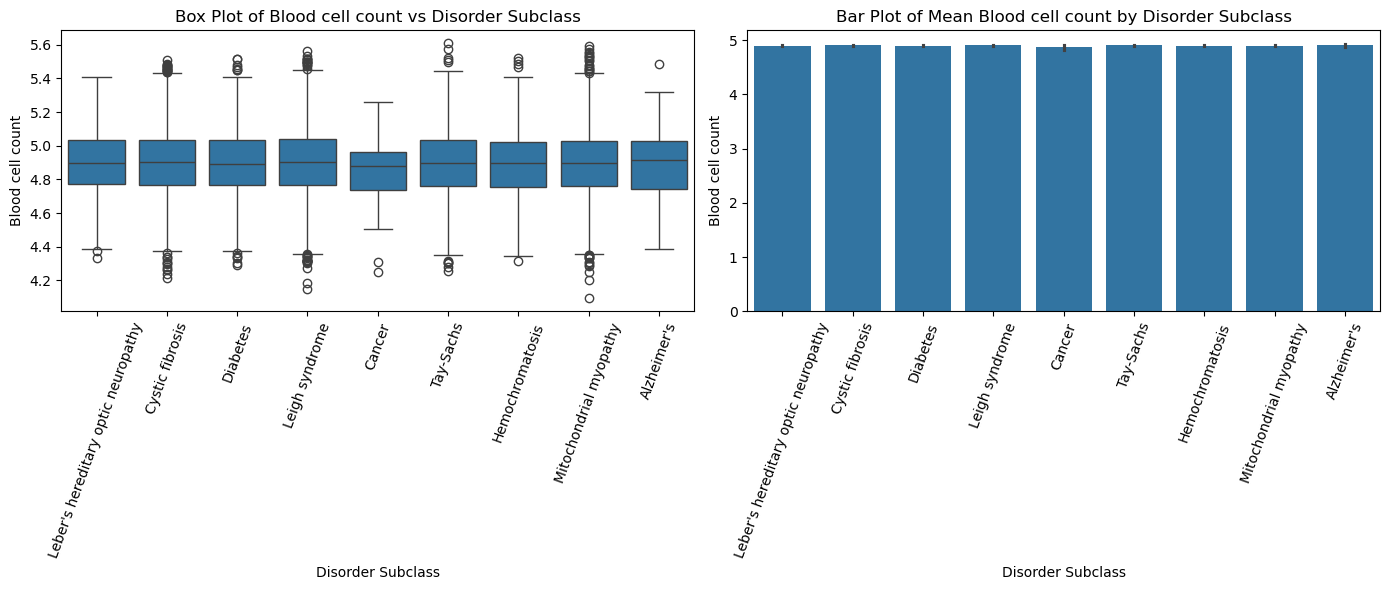

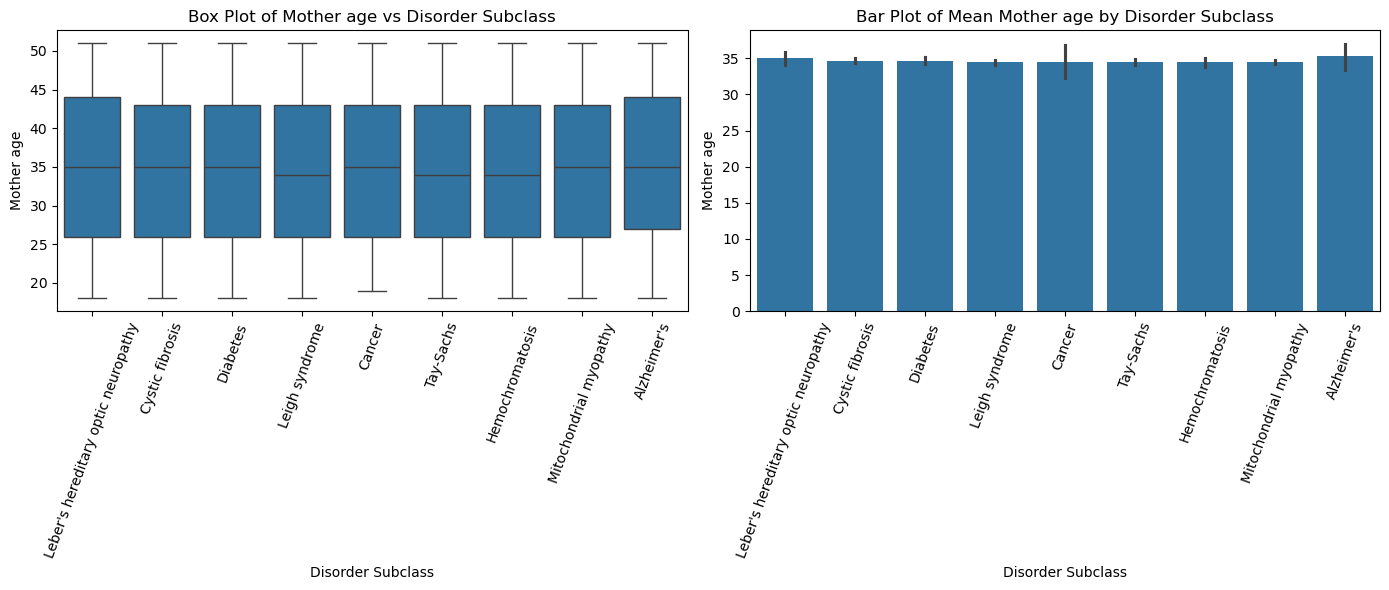

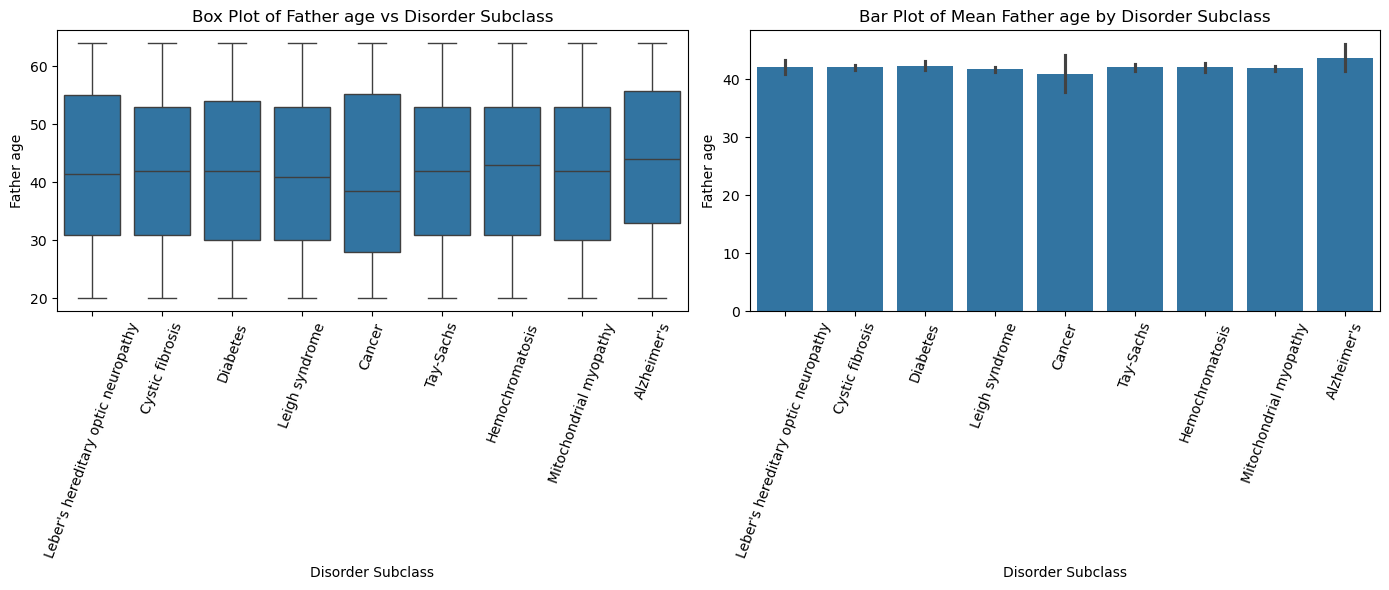

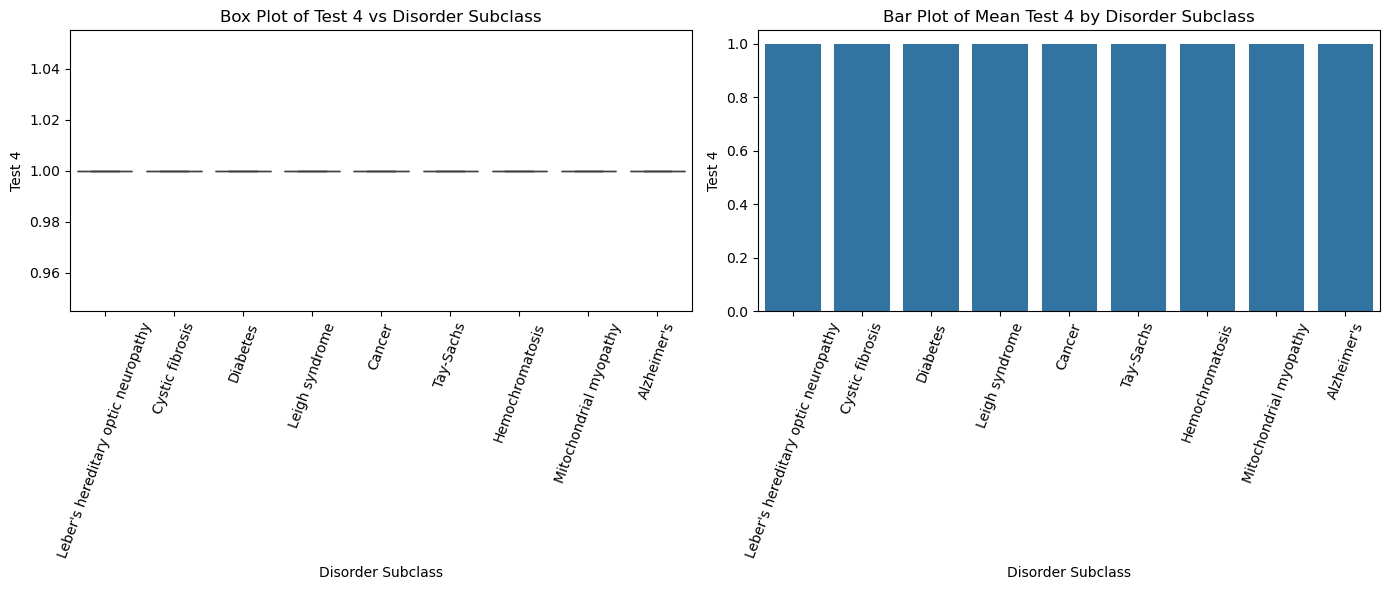

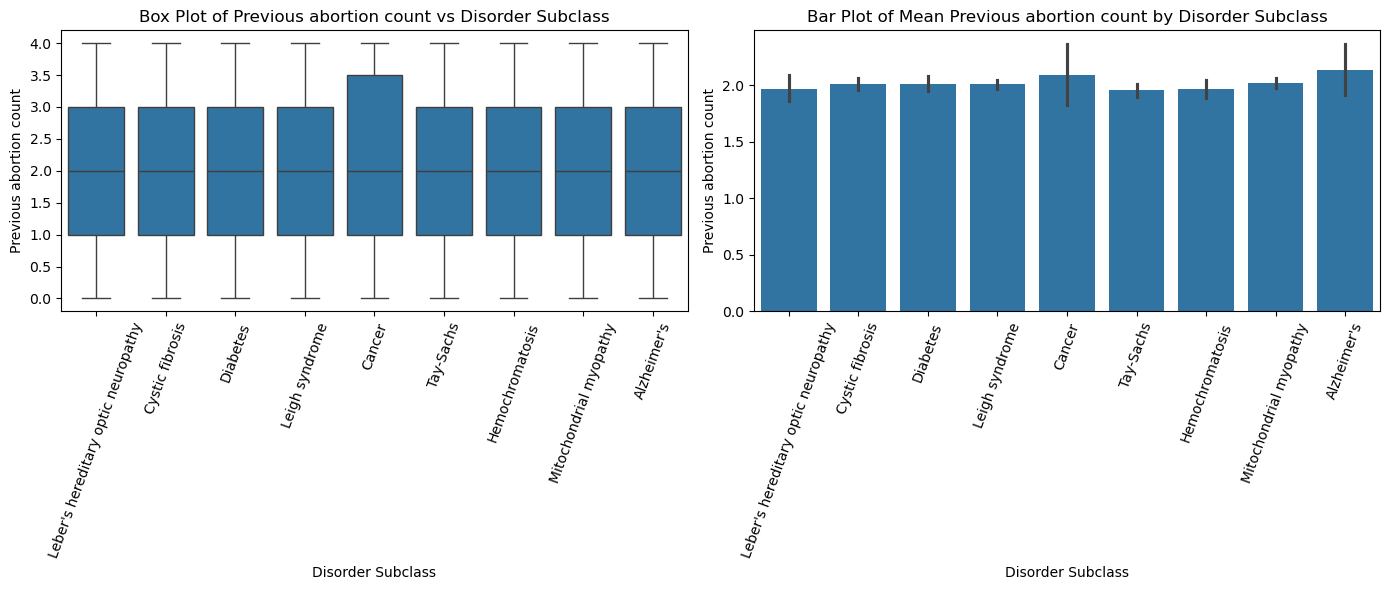

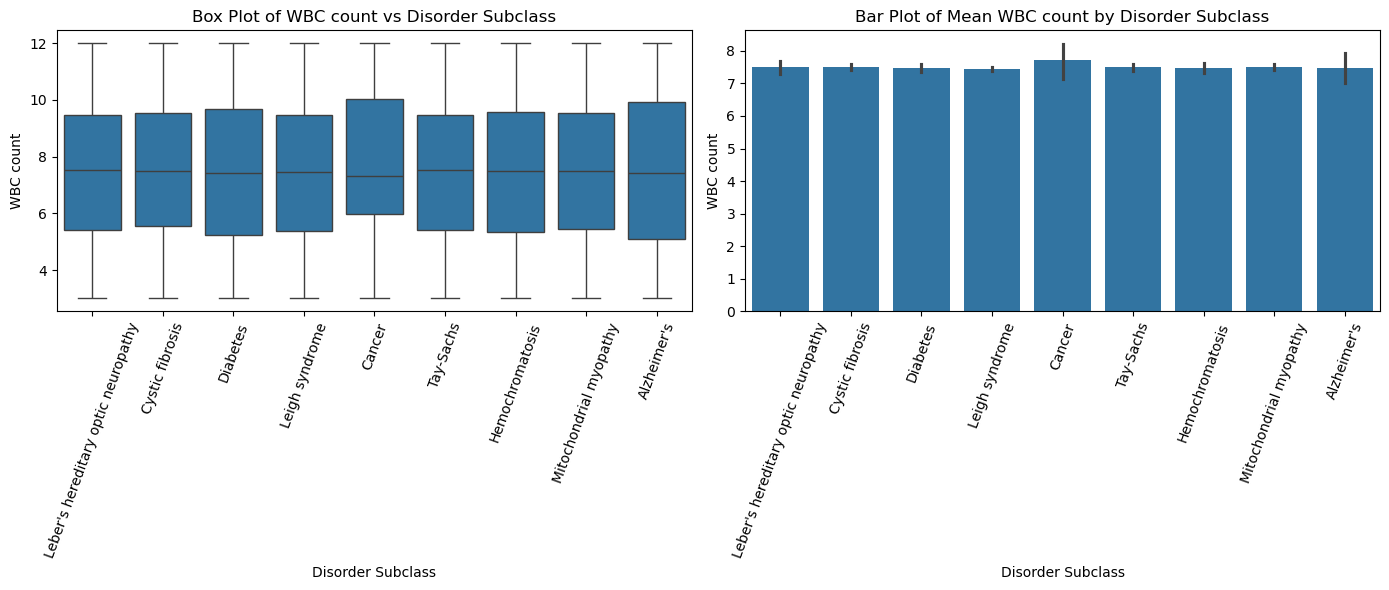

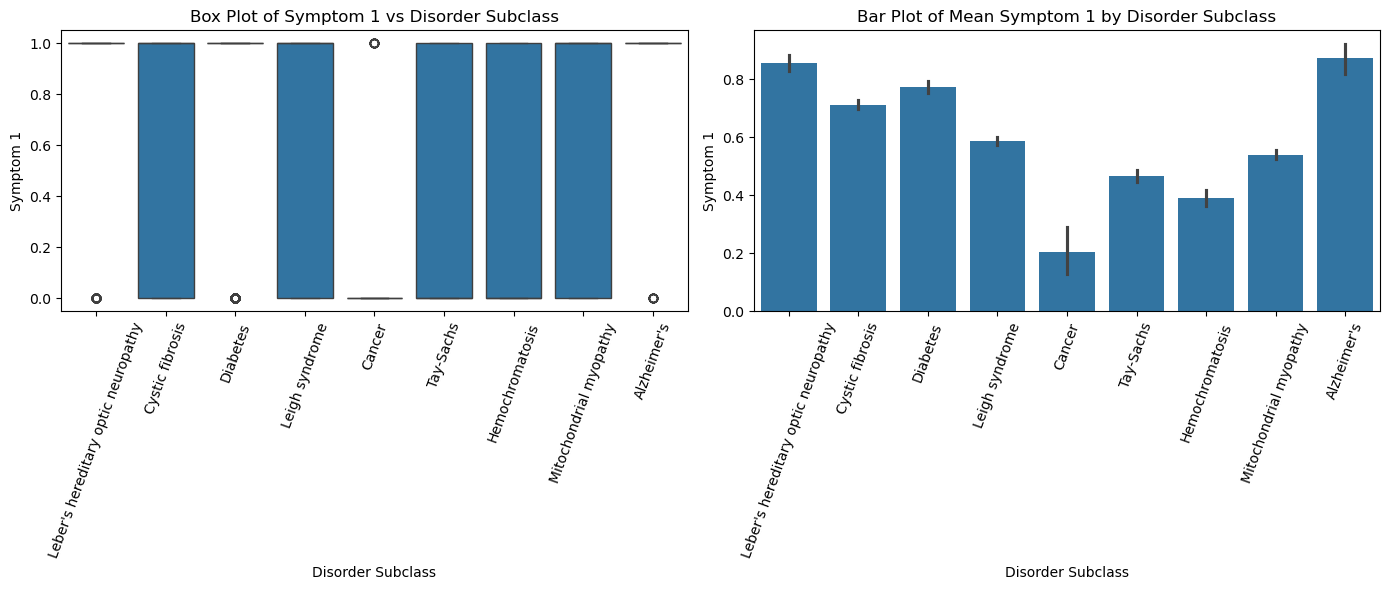

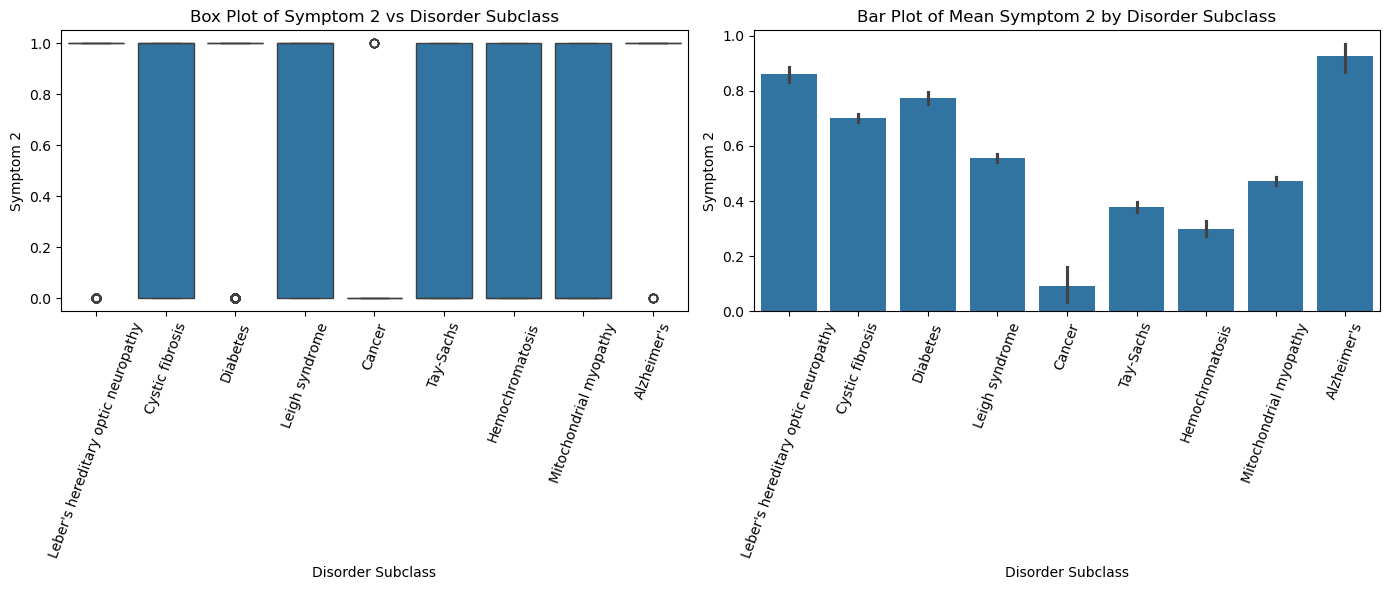

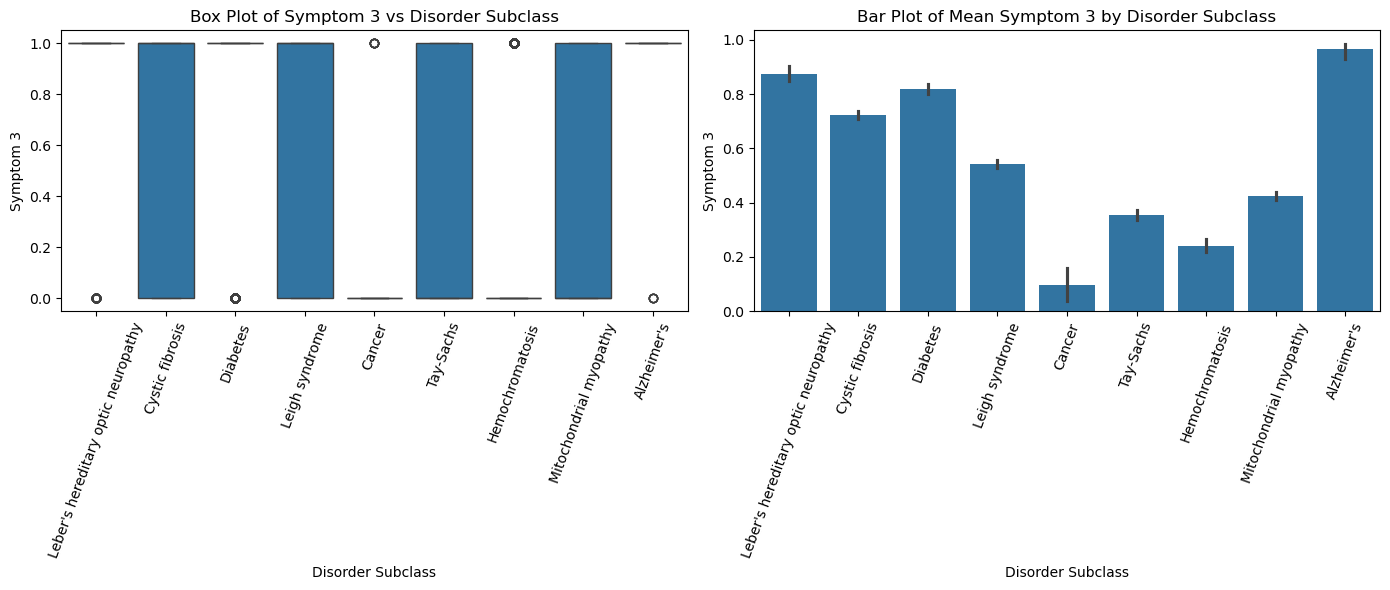

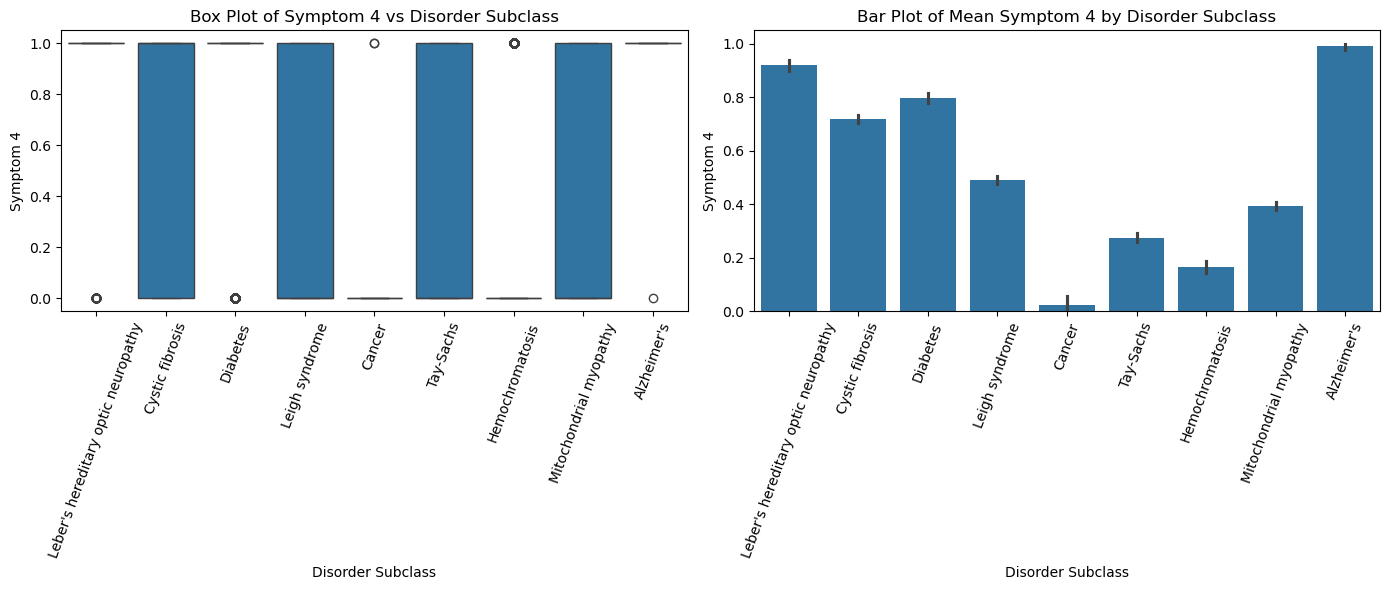

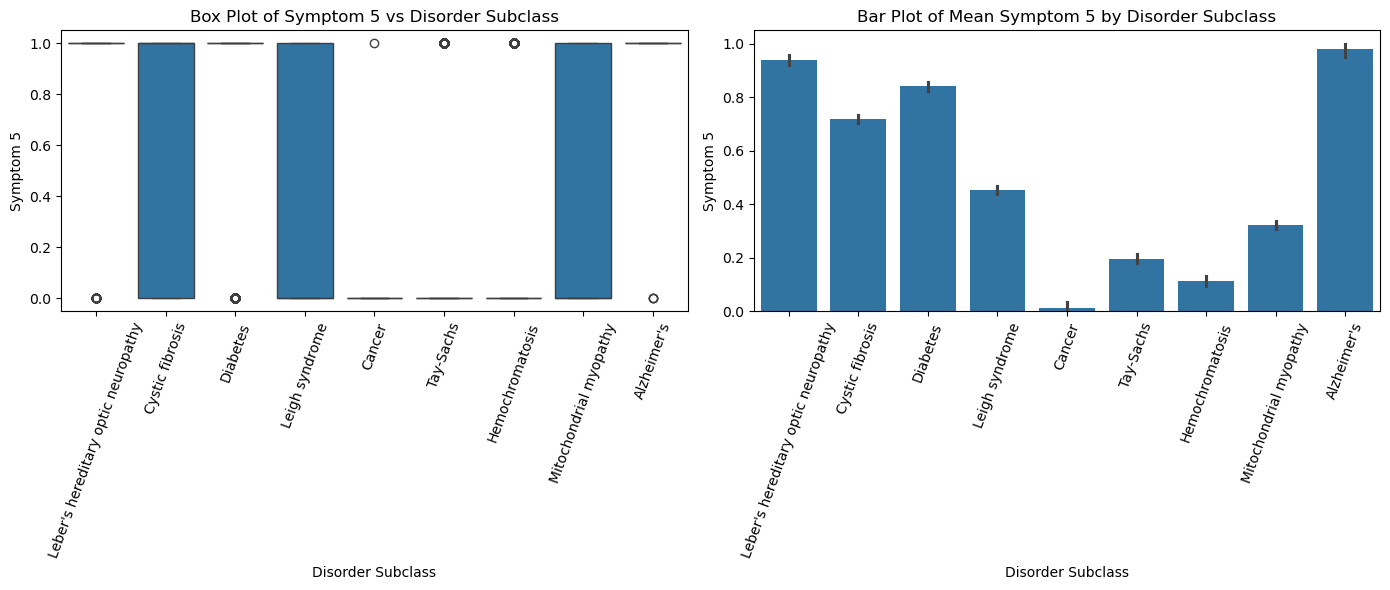

In [80]:
# Iterate over each numerical column and create the plots
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 grid for each numerical column
    
    # Box plot
    sns.boxplot(x='Disorder Subclass', y=col, data=gene, ax=axes[0])
    axes[0].set_title(f'Box Plot of {col} vs Disorder Subclass')
    axes[0].tick_params(axis='x', rotation=70)  # Rotate x-tick labels for the box plot
    
    # Bar plot showing the mean of each class
    sns.barplot(x='Disorder Subclass', y=col, data=gene, ax=axes[1], estimator=lambda x: x.mean())
    axes[1].set_title(f'Bar Plot of Mean {col} by Disorder Subclass')
    axes[1].tick_params(axis='x', rotation=70)  # Rotate x-tick labels for the bar plot
    
    plt.tight_layout()
    plt.show()

### Data Pre-processing
- Handling Missing Values
- Handling Outliers (if required)

####  Handling Missing Values
Missing values can significantly affect the performance of machine learning models. We need to address them appropriately.

- **Numerical Columns**:
    - Binary Columns like `Symptom 1 - 5` and `Test 4`, we can fill Nan values with 0.
    - For columns like 'Patient Age', 'Blood cell count', 'Mother age', 'Father age', 'Previous abortion count', 'WBC count', we can fill missing values with the median of the column to avoid the influence of outliers.

- **Categorical Columns**: For columns like `Inherited from father`, `Maternal gene`, `Respiratory Rate`, `Heart Rate`, `Parental consent`, `Follow-up`, `Gender`, `Birth asphyxia`, `Birth defect`, `Place of birth`, `Folic acid`, `Serious maternal illness`, `Radiation exposure`, `Substance abuse`, `Assisted conception`, `Anomalies in previous pregnancies`, `Birth defects`, `Blood test result`, we can fill missing values with `'Not Available'` for each column.

- **Target Columns**: First, the missing values in the `Genetic Disorder` column are filled based on the `Disorder Subclass`. After that, the missing values in the `Disorder Subclass` are filled with the mode for each `Genetic Disorder` category.olumn.

In [88]:
# Identify columns with missing values
columns_with_missing = gene.columns[gene.isnull().any()]

# Calculate percentage of missing values for each column
missing_percentage = (gene[columns_with_missing].isnull().mean() * 100)
print("Percentage of missing values in each column:")

for col, percentage in missing_percentage.items():
    print(f"{col}: {percentage:.2f}%")

Percentage of missing values in each column:
Patient Age: 6.46%
Inherited from father: 1.39%
Maternal gene: 12.72%
Mother age: 27.33%
Father age: 27.11%
Respiratory Rate: 9.73%
Heart Rate: 9.57%
Test 4: 9.69%
Parental consent: 9.62%
Follow-up: 9.81%
Gender: 9.84%
Birth asphyxia: 9.69%
Birth defect: 19.89%
Place of birth: 9.62%
Folic acid: 9.59%
Serious maternal illness: 9.75%
Radiation exposure: 9.75%
Substance abuse: 9.94%
Assisted conception: 9.61%
Anomalies in previous pregnancies: 9.84%
Previous abortion count: 9.79%
Birth defects: 9.75%
WBC count: 9.73%
Blood test result: 9.71%
Symptom 1: 9.76%
Symptom 2: 10.06%
Symptom 3: 9.51%
Symptom 4: 9.57%
Symptom 5: 9.75%
Genetic Disorder: 9.72%
Disorder Subclass: 9.82%


In [90]:
# List of symtoms and test cols to fill with 0 where Nan
symptom_test_columns = ['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5', 'Test 4']

# Replace null values with 0 in above columns
gene[symptom_test_columns] = gene[symptom_test_columns].fillna(0)

In [92]:
# Replace Nan for following Numerical cols with mean
median_cols = ['Patient Age', 'Blood cell count', 'Mother age', 'Father age', 'Previous abortion count', 'WBC count']

for col in median_cols:
    gene[col] = gene[col].fillna(gene[col].median())

In [94]:
# Replace Nan for following categorical cols with 'No Available', except target cols
mode_cols = ['Inherited from father', 'Maternal gene', 'Respiratory Rate',
       'Heart Rate', 'Parental consent', 'Follow-up', 'Gender',
       'Birth asphyxia', 'Birth defect', 'Place of birth', 'Folic acid',
       'Serious maternal illness', 'Radiation exposure', 'Substance abuse',
       'Assisted conception', 'Anomalies in previous pregnancies',
       'Birth defects', 'Blood test result']

for col in mode_cols:
    gene[col] = gene[col].fillna('Not Available')

In [96]:
# Identify columns with missing values
columns_with_missing = gene.columns[gene.isnull().any()]

# Calculate percentage of missing values for each column
missing_percentage = (gene[columns_with_missing].isnull().mean() * 100)
print("Percentage of missing values in each column:")

for col, percentage in missing_percentage.items():
    print(f"{col}: {percentage:.2f}%")

Percentage of missing values in each column:
Genetic Disorder: 9.72%
Disorder Subclass: 9.82%


#### Handling missing values for Target Variables

In [99]:
# Mapping Target variables
gene.groupby('Genetic Disorder')['Disorder Subclass'].value_counts()

Genetic Disorder                              Disorder Subclass                  
Mitochondrial genetic inheritance disorders   Leigh syndrome                         4683
                                              Mitochondrial myopathy                 3971
                                              Leber's hereditary optic neuropathy     587
Multifactorial genetic inheritance disorders  Diabetes                               1653
                                              Alzheimer's                             133
                                              Cancer                                   91
Single-gene inheritance diseases              Cystic fibrosis                        3145
                                              Tay-Sachs                              2556
                                              Hemochromatosis                        1228
Name: count, dtype: int64

In [101]:
disorder_subclass_map = {'Mitochondrial genetic inheritance disorders': ['Leigh syndrome',
                                                              'Mitochondrial myopathy',
                                                              "Leber's hereditary optic neuropathy"],
               'Multifactorial genetic inheritance disorders': ['Diabetes', "Alzheimer's", 'Cancer'],
              'Single-gene inheritance diseases': ['Cystic fibrosis', 'Tay-Sachs', 'Hemochromatosis']
              }

In [103]:
# Create reverse mapping for quick lookup for genetic_disorder
genetic_disorder_map = {subclass: genetic_disorder for genetic_disorder, subclasses in disorder_subclass_map.items() for subclass in subclasses}

In [105]:
genetic_disorder_map

{'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
 'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
 "Leber's hereditary optic neuropathy": 'Mitochondrial genetic inheritance disorders',
 'Diabetes': 'Multifactorial genetic inheritance disorders',
 "Alzheimer's": 'Multifactorial genetic inheritance disorders',
 'Cancer': 'Multifactorial genetic inheritance disorders',
 'Cystic fibrosis': 'Single-gene inheritance diseases',
 'Tay-Sachs': 'Single-gene inheritance diseases',
 'Hemochromatosis': 'Single-gene inheritance diseases'}

In [107]:
# Display rows where "Genetic Disorder" is NaN and "Disorder Subclass" is not
gene[gene['Genetic Disorder'].isna() & gene['Disorder Subclass'].notna()]

Patient Age Inherited from mother Inherited from father  Maternal gene  \
1              4.0                   Yes                   Yes             No   
13             0.0                   Yes                    No             No   
52             0.0                   Yes                    No            Yes   
68             8.0                   Yes                    No  Not Available   
75             2.0                   Yes                   Yes            Yes   
...            ...                   ...                   ...            ...   
22051          7.0                   Yes                   Yes             No   
22055          1.0                    No                    No  Not Available   
22070          3.0                   Yes                    No             No   
22073         13.0                   Yes                   Yes             No   
22081          7.0                   Yes                    No            Yes   

      Paternal gene  Blood cell count  Mother age  Father age    Status  \
1                No          4.910669        35.0        23.0  Deceased   
13              Yes          4.807778        28.0        42.0  Deceased   
52               No          4.921015        24.0        42.0  Deceased   
68              Yes          5.259736        35.0        42.0     Alive   
75              Yes          4.927532        40.0        49.0  Deceased   
...             ...               ...         ...         ...       ...   
22051           Yes          4.664764        42.0        30.0  Deceased   
22055            No          4.516767        35.0        42.0  Deceased   
22070            No          4.671013        40.0        39.0  Deceased   
22073           Yes          4.874635        44.0        62.0     Alive   
22081           Yes          4.858543        19.0        42.0     Alive   

      Respiratory Rate  ...  Birth defects  WBC count  Blood test result  \
1            Tachypnea  ...       Multiple   5.522560             normal   
13       Not Available  ...       Multiple   8.440593           abnormal   
52       Not Available  ...       Singular   7.477132  slightly abnormal   
68           Tachypnea  ...  Not Available   9.719873  slightly abnormal   
75      Normal (30-60)  ...       Singular   5.169576           abnormal   
...                ...  ...            ...        ...                ...   
22051   Normal (30-60)  ...       Singular   7.477132             normal   
22055   Normal (30-60)  ...       Multiple   7.477132  slightly abnormal   
22070   Normal (30-60)  ...       Multiple   4.967410       inconclusive   
22073        Tachypnea  ...  Not Available   7.477132             normal   
22081        Tachypnea  ...       Multiple   8.437670           abnormal   

      Symptom 1 Symptom 2 Symptom 3 Symptom 4 Symptom 5 Genetic Disorder  \
1           1.0       0.0       1.0       1.0       0.0              NaN   
13          0.0       1.0       1.0       0.0       0.0              NaN   
52          0.0       0.0       0.0       0.0       0.0              NaN   
68          1.0       0.0       1.0       0.0       0.0              NaN   
75          1.0       1.0       0.0       0.0       1.0              NaN   
...         ...       ...       ...       ...       ...              ...   
22051       0.0       0.0       0.0       0.0       0.0              NaN   
22055       0.0       1.0       0.0       0.0       1.0              NaN   
22070       0.0       1.0       1.0       1.0       1.0              NaN   
22073       0.0       0.0       0.0       1.0       1.0              NaN   
22081       1.0       1.0       1.0       0.0       0.0              NaN   

            Disorder Subclass  
1             Cystic fibrosis  
13             Leigh syndrome  
52                  Tay-Sachs  
68     Mitochondrial myopathy  
75            Cystic fibrosis  
...                       ...  
22051               Tay-Sachs  
22055               Tay-Sachs  
22070              

In [109]:
# condition for rows where "Genetic Disorder" is NaN and "Disorder Subclass" is not
condition_nan_genetic_disorder = gene['Genetic Disorder'].isna() & gene['Disorder Subclass'].notna()

# Updating missing "Genetic Disorder" based on "Disorder Subclass"
gene.loc[condition_nan_genetic_disorder, 'Genetic Disorder'] = gene.loc[condition_nan_genetic_disorder, 'Disorder Subclass'].map(genetic_disorder_map)

In [111]:
# Identify columns with missing values
columns_with_missing = gene.columns[gene.isnull().any()]

# Calculate percentage of missing values for each column
missing_percentage = (gene[columns_with_missing].isnull().mean() * 100)
print("Percentage of missing values in each column:")

for col, percentage in missing_percentage.items():
    print(f"{col}: {percentage:.2f}%")

Percentage of missing values in each column:
Genetic Disorder: 1.26%
Disorder Subclass: 9.82%


In [113]:
# check rows where "Genetic Disorder" is NaN and "Disorder Subclass" is not
gene[gene['Genetic Disorder'].isna() & gene['Disorder Subclass'].notna()]

Empty DataFrame
Columns: [Patient Age, Inherited from mother, Inherited from father, Maternal gene, Paternal gene, Blood cell count, Mother age, Father age, Status, Respiratory Rate, Heart Rate, Test 4, Parental consent, Follow-up, Gender, Birth asphyxia, Birth defect, Place of birth, Folic acid, Serious maternal illness, Radiation exposure, Substance abuse, Assisted conception, Anomalies in previous pregnancies, Previous abortion count, Birth defects, WBC count, Blood test result, Symptom 1, Symptom 2, Symptom 3, Symptom 4, Symptom 5, Genetic Disorder, Disorder Subclass]
Index: []

[0 rows x 35 columns]

In [115]:
# Fill NaN in Disorder Subclass with mode within a particular Genetic Disorder class
gene['Disorder Subclass'] = gene.groupby('Genetic Disorder')['Disorder Subclass'].transform(lambda x: x.fillna(x.mode()[0]))

In [117]:
gene.groupby('Genetic Disorder')['Disorder Subclass'].value_counts()

Genetic Disorder                              Disorder Subclass                  
Mitochondrial genetic inheritance disorders   Leigh syndrome                         6121
                                              Mitochondrial myopathy                 4405
                                              Leber's hereditary optic neuropathy     648
Multifactorial genetic inheritance disorders  Diabetes                               2011
                                              Alzheimer's                             152
                                              Cancer                                   97
Single-gene inheritance diseases              Cystic fibrosis                        4183
                                              Tay-Sachs                              2833
                                              Hemochromatosis                        1355
Name: count, dtype: int64

In [119]:
# Identify columns with missing values
columns_with_missing = gene.columns[gene.isnull().any()]

# Calculate percentage of missing values for each column
missing_percentage = (gene[columns_with_missing].isnull().mean() * 100)
print("Percentage of missing values in each column:")

for col, percentage in missing_percentage.items():
    print(f"{col}: {percentage:.2f}%")

Percentage of missing values in each column:
Genetic Disorder: 1.26%
Disorder Subclass: 1.26%


In [121]:
# Drop rows with any NaN values
gene = gene.dropna()

### Feature Selection: Filter Methods
- Chi-Sqaure Tests
- ANOVA Tests

**Contingency tables (cross-tabulation) and Chi-square tests**
- Measures the dependence between categorical features and the target categorical variable.

In [125]:
chi_selected_cols = []

for column in categorical_cols[:-2]:
    contingency_table = pd.crosstab(gene[column], gene['Genetic Disorder'])  # or 'Disorder Subclass'
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Feature: {column}, Chi-Square Statistic: {chi2}, p-value: {p}")
    if p < 0.05:
        print(f"Significant association between {column} and Genetic Disorder\n")
        chi_selected_cols.append(column) 
    else:
        print(f"No significant association between {column} and Genetic Disorder\n")

print("chi_selected_cols:", chi_selected_cols)

Feature: Inherited from mother, Chi-Square Statistic: 203.9319818762644, p-value: 5.2087413683027724e-45
Significant association between Inherited from mother and Genetic Disorder

Feature: Inherited from father, Chi-Square Statistic: 198.34796553331407, p-value: 8.512193296106588e-42
Significant association between Inherited from father and Genetic Disorder

Feature: Maternal gene, Chi-Square Statistic: 126.58563704687299, p-value: 2.0914170119228105e-26
Significant association between Maternal gene and Genetic Disorder

Feature: Paternal gene, Chi-Square Statistic: 115.47156493688333, p-value: 8.426908252491792e-26
Significant association between Paternal gene and Genetic Disorder

Feature: Status, Chi-Square Statistic: 0.2827717039947624, p-value: 0.868154268004841
No significant association between Status and Genetic Disorder

Feature: Respiratory Rate, Chi-Square Statistic: 4.251505637448067, p-value: 0.373037002234951
No significant association between Respiratory Rate and Geneti

**Summary of Chi-Square Tests for 'Genetic Disorder'**

The Chi-Square test results indicate significant associations between the following features and genetic disorders:

1. **Inherited from mother**: Chi-Square = 203.93, p-value = 5.21e-45
2. **Inherited from father**: Chi-Square = 198.35, p-value = 8.51e-42
3. **Maternal gene**: Chi-Square = 126.59, p-value = 2.09e-26
4. **Paternal gene**: Chi-Square = 115.47, p-value = 8.43e-26
5. **Blood test result**: Chi-Square = 21.40, p-value = 0.0062

These features show a significant relationship with the presence of a genetic disorder.

On the other hand, several features, such as **Status**, **Respiratory Rate**, **Heart Rate**, **Parental consent**, and others, do not show a significant association with genetic disorders based on their high p-values.

The **selected features** that are significantly associated with genetic disorders are:
- 'Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Blood test result'

In [128]:
chi_selected_cols_subclass = []

for column in categorical_cols[:-2]:
    contingency_table = pd.crosstab(gene[column], gene['Disorder Subclass'])  # or 'Disorder Subclass'
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Feature: {column}, Chi-Square Statistic: {chi2}, p-value: {p}")
    if p < 0.05:
        print(f"Significant association between {column} and Disorder Subclass\n")
        chi_selected_cols_subclass.append(column) 
    else:
        print(f"No significant association between {column} and Disorder Subclass\n")

print("chi_selected_cols_subclass:", chi_selected_cols_subclass)

Feature: Inherited from mother, Chi-Square Statistic: 761.3969718136086, p-value: 4.283189815538216e-159
Significant association between Inherited from mother and Disorder Subclass

Feature: Inherited from father, Chi-Square Statistic: 718.0889670492156, p-value: 1.8242974352670945e-142
Significant association between Inherited from father and Disorder Subclass

Feature: Maternal gene, Chi-Square Statistic: 620.8409193188065, p-value: 8.653699365063372e-122
Significant association between Maternal gene and Disorder Subclass

Feature: Paternal gene, Chi-Square Statistic: 545.3638219990885, p-value: 1.2863383135526704e-112
Significant association between Paternal gene and Disorder Subclass

Feature: Status, Chi-Square Statistic: 5.473722602292098, p-value: 0.7059495393212134
No significant association between Status and Disorder Subclass

Feature: Respiratory Rate, Chi-Square Statistic: 10.623568839216984, p-value: 0.8321030515524511
No significant association between Respiratory Rate an

**Summary of Chi-Square Tests for 'Disorder Subclass'**

The Chi-Square test results show significant associations between the following features and **Disorder Subclass**:

1. **Inherited from mother**: Chi-Square = 761.40, p-value = 4.28e-159
2. **Inherited from father**: Chi-Square = 718.09, p-value = 1.82e-142
3. **Maternal gene**: Chi-Square = 620.84, p-value = 8.65e-122
4. **Paternal gene**: Chi-Square = 545.36, p-value = 1.29e-112
5. **Blood test result**: Chi-Square = 46.72, p-value = 0.045

These features have a significant association with Disorder Subclass.

Other features, such as **Status**, **Respiratory Rate**, **Heart Rate**, **Parental consent**, and others, do not show a significant association with Disorder Subclass, as indicated by their high p-values.

The **selected features** significantly associated with Disorder Subclass are:
- 'Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Blood test result'

**ANOVA (Analysis of Variance) Tests** 
- The goal is to see if there is a significant difference in the mean of continuous features across the different categories of Genetic Disorder (target variable).

In [135]:
anova_selected_cols = []

# Group the data by 'Genetic Disorder'
groups = gene.groupby('Genetic Disorder')

for column in numerical_cols:
    anova = f_oneway(*(groups[column].get_group(disorder) for disorder in groups.groups))
    print(f"ANOVA result for {column}: F-statistic = {anova.statistic}, p-value = {anova.pvalue}")

    if anova.pvalue < 0.05:
        print(f"Significant association between {column} and Genetic Disorder\n")
        anova_selected_cols.append(column) 
    else:
        print(f"No significant association between {column} and Genetic Disorder\n")

print("anova_selected_cols:", anova_selected_cols)

ANOVA result for Patient Age: F-statistic = 0.7625038845288513, p-value = 0.46650934910502073
No significant association between Patient Age and Genetic Disorder

ANOVA result for Blood cell count: F-statistic = 0.5792209092895124, p-value = 0.5603433705378033
No significant association between Blood cell count and Genetic Disorder

ANOVA result for Mother age: F-statistic = 0.31123700565190665, p-value = 0.7325434938108497
No significant association between Mother age and Genetic Disorder

ANOVA result for Father age: F-statistic = 1.1185503633752945, p-value = 0.32677187545005815
No significant association between Father age and Genetic Disorder

ANOVA result for Test 4: F-statistic = 1.6470334618398508, p-value = 0.19264444382103646
No significant association between Test 4 and Genetic Disorder

ANOVA result for Previous abortion count: F-statistic = 1.4236035484409486, p-value = 0.24086694350487803
No significant association between Previous abortion count and Genetic Disorder

ANO

**Summary ANOVA tests for 'Genetic Disorder'**

The ANOVA results reveal significant associations between **Symptom 1**, **Symptom 2**, **Symptom 3**, **Symptom 4**, and **Symptom 5** with **Genetic Disorder**, as indicated by their low p-values:

1. **Symptom 1**: F-statistic = 107.55, p-value = 3.33e-47
2. **Symptom 2**: F-statistic = 185.16, p-value = 1.83e-80
3. **Symptom 3**: F-statistic = 307.47, p-value = 2.08e-132
4. **Symptom 4**: F-statistic = 341.09, p-value = 1.37e-146
5. **Symptom 5**: F-statistic = 521.79, p-value = 4.42e-222

These symptoms show a significant association with the presence of a genetic disorder.

Other variables, such as **Patient Age**, **Blood cell count**, **Mother age**, **Father age**, and **Previous abortion count**, do not show a significant association with Genetic Disorder, as indicated by their high p-values.

The **selected features** significantly associated with Genetic Disorder based on ANOVA are:
- 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'

In [138]:
anova_selected_cols_subclass = []

# Group the data by 'Disorder Subclass'
groups = gene.groupby('Disorder Subclass')

for column in numerical_cols:
    anova = f_oneway(*(groups[column].get_group(disorder) for disorder in groups.groups))
    print(f"ANOVA result for {column}: F-statistic = {anova.statistic}, p-value = {anova.pvalue}")

    if anova.pvalue < 0.05:
        print(f"Significant association between {column} and Disorder Subclass\n")
        anova_selected_cols_subclass.append(column) 
    else:
        print(f"No significant association between {column} and Disorder Subclass\n")

print("anova_selected_cols_subclass:", anova_selected_cols_subclass)

ANOVA result for Patient Age: F-statistic = 0.9505680256210506, p-value = 0.47304872337484205
No significant association between Patient Age and Disorder Subclass

ANOVA result for Blood cell count: F-statistic = 1.1041068616171585, p-value = 0.35664162284021944
No significant association between Blood cell count and Disorder Subclass

ANOVA result for Mother age: F-statistic = 0.35333359722918667, p-value = 0.9447477100717787
No significant association between Mother age and Disorder Subclass

ANOVA result for Father age: F-statistic = 0.5682097116534156, p-value = 0.8048307081233014
No significant association between Father age and Disorder Subclass

ANOVA result for Test 4: F-statistic = 0.6143826337826299, p-value = 0.7666018197757563
No significant association between Test 4 and Disorder Subclass

ANOVA result for Previous abortion count: F-statistic = 0.8562249116682807, p-value = 0.5529362260556614
No significant association between Previous abortion count and Disorder Subclass


**Summary ANOVA tests for 'Disorder Subclass'**

The ANOVA results for **Disorder Subclass** indicate significant associations with the following symptoms:

1. **Symptom 1**: F-statistic = 118.10, p-value = 2.27e-194
2. **Symptom 2**: F-statistic = 204.27, p-value = 0.0
3. **Symptom 3**: F-statistic = 295.72, p-value = 0.0
4. **Symptom 4**: F-statistic = 385.57, p-value = 0.0
5. **Symptom 5**: F-statistic = 556.77, p-value = 0.0

These symptoms are significantly associated with Disorder Subclass.

On the other hand, features such as **Patient Age**, **Blood cell count**, **Mother age**, **Father age**, **Test 4**, **Previous abortion count**, and **WBC count** do not show a significant association with Disorder Subclass, as their p-values are high.

The **selected features** significantly associated with Disorder Subclass based on ANOVA are:
- 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'

### Selected Featues from Chi-Square and ANOVA Methods:
- 'Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Blood test result'
- 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'

### Engineering Features

#### Encoding Categorical Variables and Scaling Numnerical Variables
Machine learning algorithms require numerical input. Hence, we need to convert categorical variables into numerical formats. Common techniques include:

- **Standard Scalar**: for numerical cols (not required as selected cols are binary 1,0)
- **Ordinal Encoding**: for categorical cols
- **Label Encoding**: for Target cols, two target variables will be predicted and evaluated separately:
    - Genetic Disorder
    - Disorder Subclass 

In [170]:
# Split data into features (X) and target (y) as a DataFrame
#X = gene.drop(columns=['Genetic Disorder', 'Disorder Subclass'])
X = gene[['Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Blood test result', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']]
y = gene[['Genetic Disorder', 'Disorder Subclass']]

In [172]:
y1 = gene['Genetic Disorder']
y2 = gene['Disorder Subclass']

In [174]:
# Identify Categorical and Numerical cols
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int','float']).columns.tolist()

In [176]:
print('categorical_cols and length:', len(categorical_cols), categorical_cols)
print('numerical_cols and length:', len(numerical_cols), numerical_cols)

categorical_cols and length: 5 ['Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Blood test result']
numerical_cols and length: 5 ['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']


In [178]:
X

Inherited from mother Inherited from father  Maternal gene  \
0                       Yes                    No            Yes   
1                       Yes                   Yes             No   
2                       Yes                    No             No   
3                       Yes                    No            Yes   
4                       Yes                    No  Not Available   
...                     ...                   ...            ...   
22078                   Yes                   Yes            Yes   
22079                    No                   Yes             No   
22080                   Yes                    No            Yes   
22081                   Yes                    No            Yes   
22082                   Yes                    No             No   

      Paternal gene Blood test result  Symptom 1  Symptom 2  Symptom 3  \
0                No     Not Available        1.0        1.0        1.0   
1                No            normal        1.0        0.0        1.0   
2                No            normal        0.0        1.0        1.0   
3                No      inconclusive        0.0        0.0        1.0   
4               Yes     Not Available        0.0        0.0        0.0   
...             ...               ...        ...        ...        ...   
22078            No      inconclusive        0.0        0.0        1.0   
22079           Yes      inconclusive        1.0        1.0        1.0   
22080            No            normal        0.0        0.0        0.0   
22081           Yes          abnormal        1.0        1.0        1.0   
22082            No            normal        1.0        0.0        1.0   

       Symptom 4  Symptom 5  
0            1.0        1.0  
1            1.0        0.0  
2            1.0        1.0  
3            0.0        0.0  
4            0.0        0.0  
...          ...        ...  
22078        0.0        0.0  
22079        1.0        0.0  
22080        1.0        0.0  
22081        0.0        0.0  
22082        1.0        1.0  

[21805 rows x 10 columns]

In [180]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [182]:
X_txd = preprocessor.fit_transform(X)

In [184]:
X_txd

array([[1., 0., 2., ..., 1., 1., 1.],
       [1., 2., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 0., 2., ..., 0., 1., 0.],
       [1., 0., 2., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 1.]])

In [196]:
X1 = pd.DataFrame(X_txd, columns=X.columns)
X1

Inherited from mother  Inherited from father  Maternal gene  \
0                        1.0                    0.0            2.0   
1                        1.0                    2.0            0.0   
2                        1.0                    0.0            0.0   
3                        1.0                    0.0            2.0   
4                        1.0                    0.0            1.0   
...                      ...                    ...            ...   
21800                    1.0                    2.0            2.0   
21801                    0.0                    2.0            0.0   
21802                    1.0                    0.0            2.0   
21803                    1.0                    0.0            2.0   
21804                    1.0                    0.0            0.0   

       Paternal gene  Blood test result  Symptom 1  Symptom 2  Symptom 3  \
0                0.0                0.0        1.0        1.0        1.0   
1                0.0                3.0        1.0        0.0        1.0   
2                0.0                3.0        0.0        1.0        1.0   
3                0.0                2.0        0.0        0.0        1.0   
4                1.0                0.0        0.0        0.0        0.0   
...              ...                ...        ...        ...        ...   
21800            0.0                2.0        0.0        0.0        1.0   
21801            1.0                2.0        1.0        1.0        1.0   
21802            0.0                3.0        0.0        0.0        0.0   
21803            1.0                1.0        1.0        1.0        1.0   
21804            0.0                3.0        1.0        0.0        1.0   

       Symptom 4  Symptom 5  
0            1.0        1.0  
1            1.0        0.0  
2            1.0        1.0  
3            0.0        0.0  
4            0.0        0.0  
...          ...        ...  
21800        0.0        0.0  
21801        1.0        0.0  
21802        1.0        0.0  
21803        0.0        0.0  
21804        1.0        1.0  

[21805 rows x 10 columns]

In [200]:
# Extract the OrdinalEncoder instance
ordinal_encoder = preprocessor.named_transformers_['cat']

# Retrieve the categories (ordinal encoding mapping)
ordinal_encoding_mapping = {col: dict(enumerate(cat)) for col, cat in zip(categorical_cols, ordinal_encoder.categories_)}

print(ordinal_encoding_mapping)

{'Inherited from mother': {0: 'No', 1: 'Yes'}, 'Inherited from father': {0: 'No', 1: 'Not Available', 2: 'Yes'}, 'Maternal gene': {0: 'No', 1: 'Not Available', 2: 'Yes'}, 'Paternal gene': {0: 'No', 1: 'Yes'}, 'Blood test result': {0: 'Not Available', 1: 'abnormal', 2: 'inconclusive', 3: 'normal', 4: 'slightly abnormal'}}


In [202]:
# Encode target variable
le1 = LabelEncoder()
le2 = LabelEncoder()
y1_txd = le1.fit_transform(y1)
y2_txd = le2.fit_transform(y2)

In [204]:
y1_txd

array([0, 2, 1, ..., 0, 0, 1])

In [206]:
dict(zip(le1.classes_, range(len(le1.classes_))))

{'Mitochondrial genetic inheritance disorders': 0,
 'Multifactorial genetic inheritance disorders': 1,
 'Single-gene inheritance diseases': 2}

In [208]:
y2_txd

array([5, 2, 3, ..., 7, 6, 3])

In [210]:
dict(zip(le2.classes_, range(len(le2.classes_))))

{"Alzheimer's": 0,
 'Cancer': 1,
 'Cystic fibrosis': 2,
 'Diabetes': 3,
 'Hemochromatosis': 4,
 "Leber's hereditary optic neuropathy": 5,
 'Leigh syndrome': 6,
 'Mitochondrial myopathy': 7,
 'Tay-Sachs': 8}

### Train/Test Split

#### Predicting Genetic Disorder

In [214]:
# Split data into training and testing sets for Logistic, KNN, SVM
X_train, X_test, y_train, y_test = train_test_split(X_txd, y1_txd, test_size=0.2, random_state=42, stratify=y)

In [216]:
X_train.shape, X_test.shape

((17444, 10), (4361, 10))

In [218]:
y_train.shape, y_test.shape

((17444,), (4361,))

In [238]:
y1.value_counts(normalize=True)

Genetic Disorder
Mitochondrial genetic inheritance disorders     0.512451
Single-gene inheritance diseases                0.383903
Multifactorial genetic inheritance disorders    0.103646
Name: proportion, dtype: float64

In [240]:
y2.value_counts(normalize=True)

Disorder Subclass
Leigh syndrome                         0.280715
Mitochondrial myopathy                 0.202018
Cystic fibrosis                        0.191837
Tay-Sachs                              0.129924
Diabetes                               0.092227
Hemochromatosis                        0.062142
Leber's hereditary optic neuropathy    0.029718
Alzheimer's                            0.006971
Cancer                                 0.004449
Name: proportion, dtype: float64

### Using SMOTE for balancing the target variables

In [247]:
# Print original class distribution
print("Original class distribution:", Counter(y_train))

Original class distribution: Counter({0: 8939, 2: 6696, 1: 1809})


In [249]:
# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')  # 'auto' means balance all classes
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [251]:
# Print new class distribution
print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({0: 8939, 2: 8939, 1: 8939})


## Modeling

In the Modeling Phase, focused on developing and evaluating seven different machine learning models to predict the target variable. The primary goal was to build models that can accurately classify instances based on the input features. 

Utilized the following seven models for evaluation:

1. **K-Nearest Neighbors (KNN)** - `OneVsRestClassifier(KNeighborsClassifier())`
2. **Logistic Regression (LogReg)** - `LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)`
3. **Decision Tree Classifier (dTree)** - `DecisionTreeClassifier(random_state=42)`
4. **Support Vector Machine (SVM)** - `SVC(probability=True, random_state=42)`
5. **Random Forest Classifier (RFC)** - `RandomForestClassifier(n_estimators=100, random_state=42)`
6. **Gradient Boosting Machine (GBM)** - `GradientBoostingClassifier(n_estimators=100, random_state=42)`
7. **XGBoost Classifier (XGB)** - `XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss')`

In [347]:
# Initialize models
models = {
    'KNN': OneVsRestClassifier(KNeighborsClassifier()),
    'LogReg': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    'dTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42), 
    'RFC': RandomForestClassifier(n_estimators=100, random_state=42),
    'GBM': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss')
}

In [349]:
# Train and evaluate models
results = {}

for name, model in models.items():

    print(f"Evaluating {model}")
    
    start_time = time.time()
    model.fit(X_resampled, y_resampled)
    end_time = time.time()
    train_time = round(end_time - start_time, 4)

    y_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = round(model.score(X_resampled, y_resampled),2)
    test_accuracy = round(accuracy_score(y_test, y_pred),2)
    precision_macro = round(precision_score(y_test, y_pred, average='macro', zero_division=0.0), 2)
    recall_macro = round(recall_score(y_test, y_pred, average='macro'), 2)
    f1_macro = round(f1_score(y_test, y_pred, average='macro'), 2)
    
    precision = precision_score(y_test, y_pred, average=None, zero_division=0.0)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    precision_rounded = [round(p, 2) for p in precision]
    recall_rounded = [round(r, 2) for r in recall]
    f1_rounded = [round(f, 2) for f in f1]

    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0.0))

    y_prob = model.predict_proba(X_test)
    y_prob = np.nan_to_num(y_prob, nan=0.0)

    # Calculate AUC
    n_classes = y_prob.shape[1]

    # Binarize the true labels (one-hot encoding)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    # Initialize lists to store results
    fpr = [None] * n_classes
    tpr = [None] * n_classes
    thresholds = [None] * n_classes
    auc_score = [0] * n_classes
    
    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_bin[:, i], y_prob[:, i])
        auc_score[i] = round(roc_auc_score(y_test_bin[:, i], y_prob[:, i]),2)

    # Calculate ROC curve and AUC for micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc_micro = round(roc_auc_score(y_test_bin, y_prob, average='micro'),2)
    
    # Calculate ROC curve and AUC for macro-average
    # Macro-average does not have its own fpr and tpr; it's an aggregate of individual class curves
    roc_auc_macro = round(roc_auc_score(y_test_bin, y_prob, average='macro'),2)

    results[name] = {
        'Model': name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'precision_macro':precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision':precision_rounded,
        'recall': recall_rounded,
        'f1': f1_rounded,
        'AUC': auc_score,
        'fpr':fpr,
        'tpr':tpr,
        'thresholds':thresholds,
        'fpr_micro':fpr_micro,
        'tpr_micro':tpr_micro,
        'roc_auc_micro':roc_auc_micro,
        'roc_auc_macro':roc_auc_macro,
        'y pred': y_pred,
        'y_prob': y_prob
    }

Evaluating OneVsRestClassifier(estimator=KNeighborsClassifier())
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.60      0.62      2235
           1       0.35      0.42      0.38       451
           2       0.47      0.48      0.48      1675

    accuracy                           0.54      4361
   macro avg       0.49      0.50      0.49      4361
weighted avg       0.54      0.54      0.54      4361

Evaluating LogisticRegression(max_iter=1000, multi_class='multinomial')
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.36      0.47      2235
           1       0.30      0.80      0.43       451
           2       0.43      0.50      0.46      1675

    accuracy                           0.46      4361
   macro avg       0.47      0.55      0.46      4361
weighted avg       0.54      0.46      0.46      4361

Evaluating DecisionTreeClassifier(random_state=42)
Cl

**ROC-AUC**

**Micro-averaging** aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics.
In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. 

Obtaining the **Macro-average** requires computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priority. We first aggregate the true/false positive rates per class.

In [362]:
results_df = pd.DataFrame(results).transpose().reset_index(drop=True)
results_df

Model Train Time Train Accuracy Test Accuracy precision_macro  \
0     KNN     0.0664           0.69          0.54            0.49   
1  LogReg     0.0914           0.58          0.46            0.47   
2   dTree     0.0496           0.78          0.56            0.51   
3     SVM   152.7262           0.64          0.58            0.54   
4     RFC     1.4494           0.78          0.56            0.51   
5     GBM     3.9473           0.66          0.58            0.53   
6     XGB     0.5177           0.72          0.59            0.54   

  recall_macro f1_macro           precision              recall  \
0          0.5     0.49  [0.64, 0.35, 0.47]   [0.6, 0.42, 0.48]   
1         0.55     0.46   [0.68, 0.3, 0.43]    [0.36, 0.8, 0.5]   
2         0.53     0.51   [0.64, 0.38, 0.5]  [0.68, 0.48, 0.42]   
3          0.6     0.51  [0.66, 0.34, 0.62]  [0.79, 0.76, 0.24]   
4         0.54     0.52   [0.65, 0.4, 0.49]  [0.63, 0.51, 0.48]   
5         0.59     0.53  [0.65, 0.37, 0.58]  [0.77, 0.68, 0.31]   
6         0.58     0.54  [0.66, 0.39, 0.56]  [0.74, 0.63, 0.38]   

                   f1                 AUC  \
0  [0.62, 0.38, 0.48]  [0.66, 0.78, 0.59]   
1  [0.47, 0.43, 0.46]  [0.57, 0.84, 0.58]   
2  [0.66, 0.42, 0.46]  [0.66, 0.78, 0.59]   
3  [0.72, 0.47, 0.35]  [0.72, 0.87, 0.59]   
4  [0.64, 0.45, 0.48]   [0.68, 0.82, 0.6]   
5  [0.71, 0.48, 0.41]   [0.7, 0.84, 0.57]   
6   [0.7, 0.48, 0.45]  [0.72, 0.86, 0.63]   

                                                 fpr  \
0  [[0.0, 0.05268109125117592, 0.1740357478833490...   
1  [[0.0, 0.00047036688617121356, 0.0009407337723...   
2  [[0.0, 0.08936970837253057, 0.0903104421448730...   
3  [[0.0, 0.00047036688617121356, 0.0009407337723...   
4  [[0.0, 0.01599247412982126, 0.0164628410159924...   
5  [[0.0, 0.0009407337723424271, 0.00141110065851...   
6  [[0.0, 0.0, 0.0009407337723424271, 0.000940733...   

                                                 tpr  \
0  [[0.0, 0.10559284116331097, 0.3619686800894854...   
1  [[0.0, 0.0, 0.0, 0.00044742729306487697, 0.002...   
2  [[0.0, 0.1436241610738255, 0.14407158836689038...   
3  [[0.0, 0.0, 0.00044742729306487697, 0.00089485...   
4  [[0.0, 0.031767337807606266, 0.031767337807606...   
5  [[0.0, 0.0, 0.00044742729306487697, 0.00134228...   
6  [[0.0, 0.00044742729306487697, 0.0008948545861...   

                                          thresholds  \
0  [[inf, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0], [inf, 1....   
1  [[inf, 0.49681895083077926, 0.4939518468090108...   
2  [[inf, 1.0, 0.9333333333333333, 0.923076923076...   
3  [[inf, 0.6564918326450823, 0.6504060156906514,...   
4  [[inf, 1.0, 0.9993333333333334, 0.999000000000...   
5  [[inf, 0.6714155617853524, 0.662722135282031, ...   
6  [[inf, 0.88828707, 0.86340755, 0.84112924, 0.8...   

                                           fpr_micro  \
0  [0.0, 0.02040816326530612, 0.08312313689520752...   
1  [0.0, 0.000343957807842238, 0.0003439578078422...   
2  [0.0, 0.04184819995413896, 0.04196285255675304...   
3  [0.0, 0.0, 0.0, 0.00011465260261407934, 0.0002...   
4  [0.0, 0.006191240541160285, 0.0063058931437743...   
5  [0.0, 0.00022930520522815867, 0.00057326301307...   
6  [0.0, 0.0, 0.00011465260261407934, 0.000229305...   

                                           tpr_micro roc_auc_micro  \
0  [0.0, 0.0710846136207292, 0.2664526484751204, ...          0.73   
1  [0.0, 0.0, 0.00045861041045631735, 0.000458610...          0.69   
2  [0.0, 0.10181151112130245, 0.10249942673698693...          0.73   
3  [0.0, 0.00022930520522815867, 0.00045861041045...          0.76   
4  [0.0, 0.022242604907131393, 0.0222426049071313...          0.75   
5  [0.0, 0.0009172208209126347, 0.000917220820912...          0.77   
6  [0.0, 0.00045861041045631735, 0.00137583123136...          0.79   

  roc_auc_macro                                             y pred  \
0          0.68  [2, 2, 0, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2, 2, ...   
1          0.66  [2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 2,

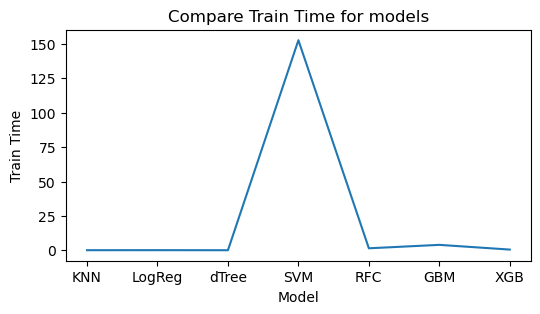

In [364]:
# Compare train time for models
plt.figure(figsize=(6,3))
sns.lineplot(results_df, x='Model', y='Train Time')
plt.title('Compare Train Time for models')
plt.show()

**SVC is computationally most expensive**

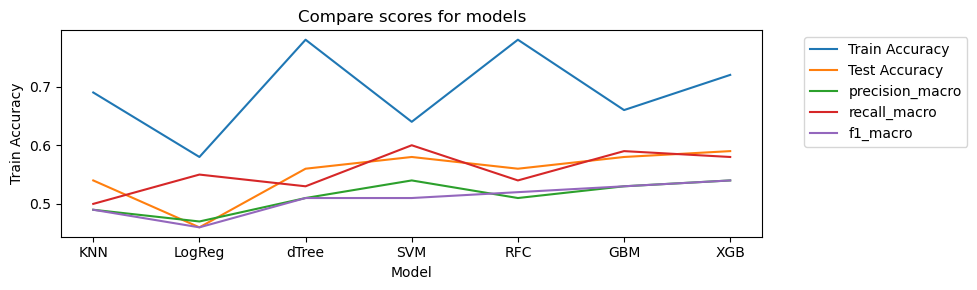

In [367]:
# Define the metrics to plot
metrics = ['Train Accuracy', 'Test Accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
plt.figure(figsize=(10,3))
# Plot each metric
for metric in metrics:
    sns.lineplot(data=results_df, x='Model', y=metric, label=metric)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Compare scores for models')
plt.tight_layout()
plt.show()

**XGB seems to have better results than others**

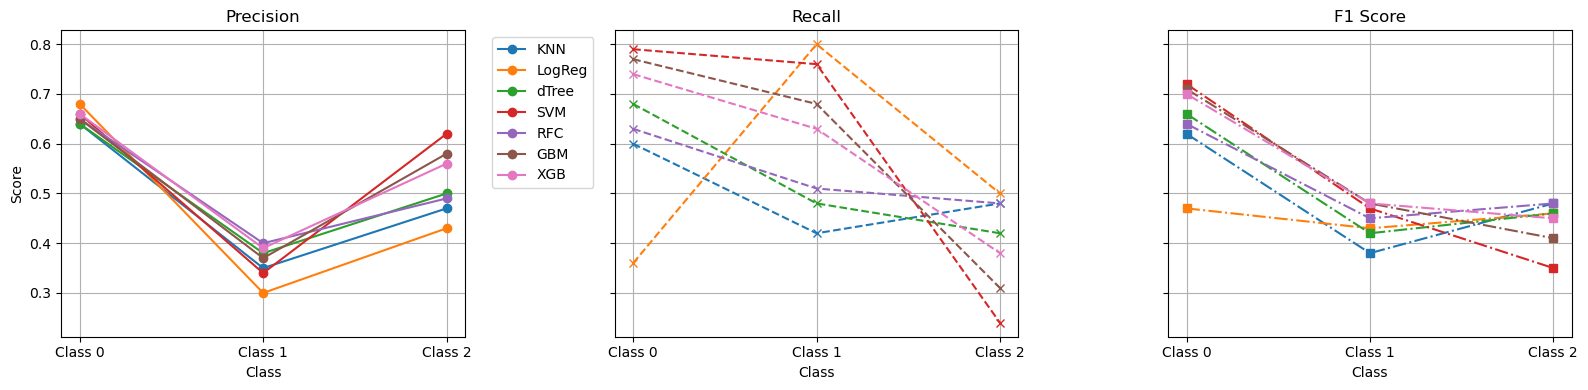

In [370]:
# Extract classes
n_classes = len(results_df['precision'][0])

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

# Plot Precision
for _, row in results_df.iterrows():
    axs[0].plot(range(n_classes), row['precision'], marker='o', label=row["Model"])
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Score')
axs[0].set_title('Precision')
axs[0].set_xticks(range(n_classes))
axs[0].set_xticklabels([f'Class {i}' for i in range(n_classes)])
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True)

# Plot Recall
for _, row in results_df.iterrows():
    axs[1].plot(range(n_classes), row['recall'], marker='x', linestyle='--', label=row["Model"])
axs[1].set_xlabel('Class')
axs[1].set_title('Recall')
axs[1].set_xticks(range(n_classes))
axs[1].set_xticklabels([f'Class {i}' for i in range(n_classes)])
axs[1].grid(True)

# Plot F1 Score
for _, row in results_df.iterrows():
    axs[2].plot(range(n_classes), row['f1'], marker='s', linestyle='-.', label=row["Model"])
axs[2].set_xlabel('Class')
axs[2].set_title('F1 Score')
axs[2].set_xticks(range(n_classes))
axs[2].set_xticklabels([f'Class {i}' for i in range(n_classes)])
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

**Based on F1 Score: XGB, RFC, dtree seems to be performing better than other models**

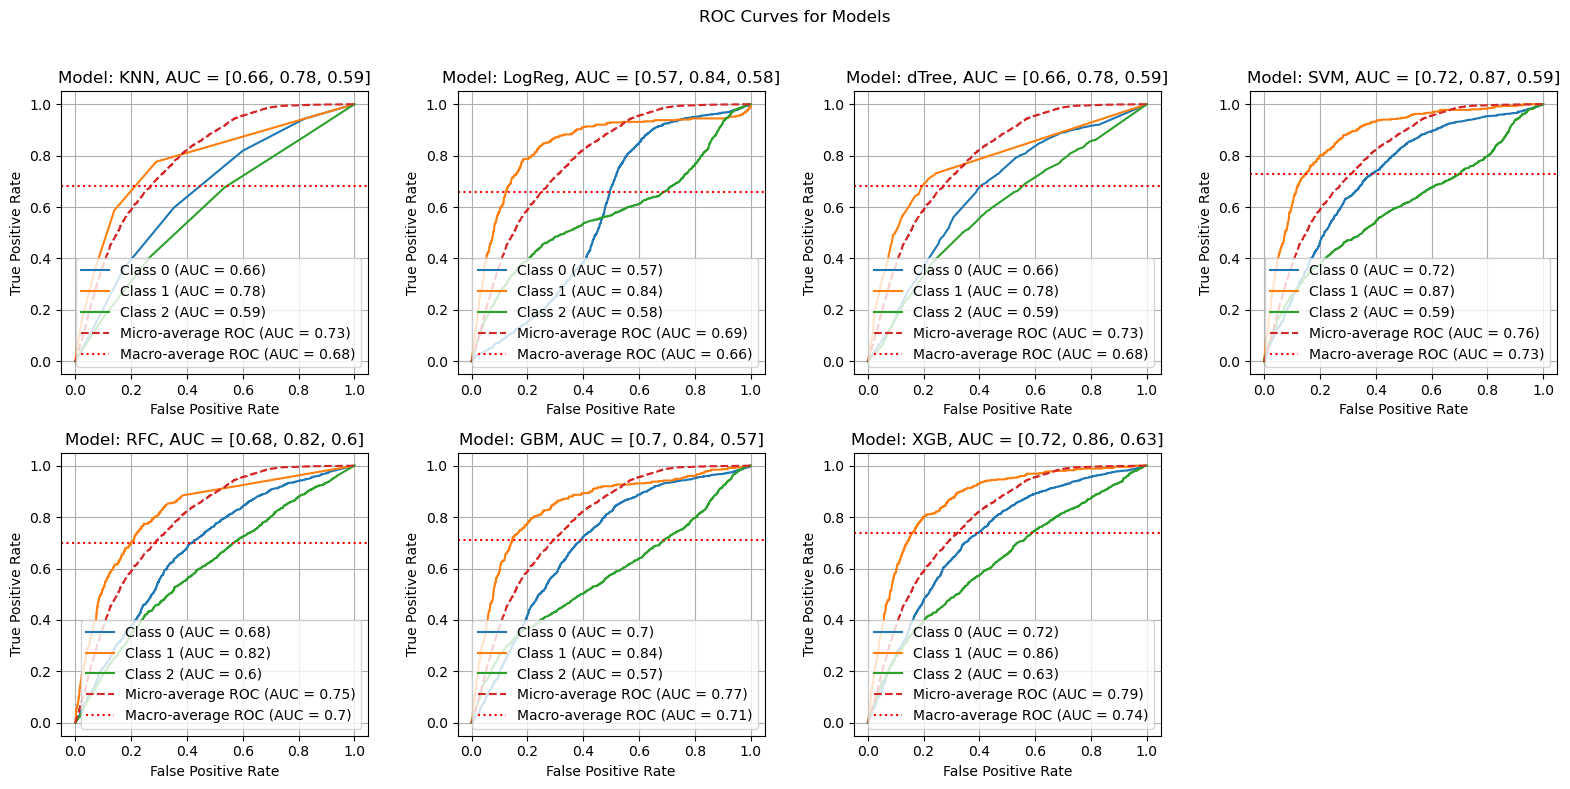

In [373]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a grid of subplots
fig.suptitle('ROC Curves for Models')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df.iterrows():
    model = row['Model']
    fpr = row['fpr']
    tpr = row['tpr']
    auc_score = row['AUC']
    roc_auc_micro = row['roc_auc_micro']
    roc_auc_macro = row['roc_auc_macro']

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access
    
    # Plot the ROC curves for each class
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc_score[i]})')
    
    # Plot ROC curve for micro-average
    ax.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro})', linestyle='--')
    
    # Plot ROC curve for macro-average
    ax.axhline(y=roc_auc_macro, color='r', linestyle=':', label=f'Macro-average ROC (AUC = {roc_auc_macro})')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Model: {model}, AUC = {auc_score}")
    ax.legend()
    ax.grid(True)

    plot_count += 1

# Hide the 8th subplot if there are more than 7 plots
if plot_count < len(axes.flat):
    axes.flat[plot_count].axis('off')

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to accommodate suptitle

plt.show()

**Based on ROC-AUC scores: XGB and GBM have best AUC scores, followed by SVM, RFC which are comparable**

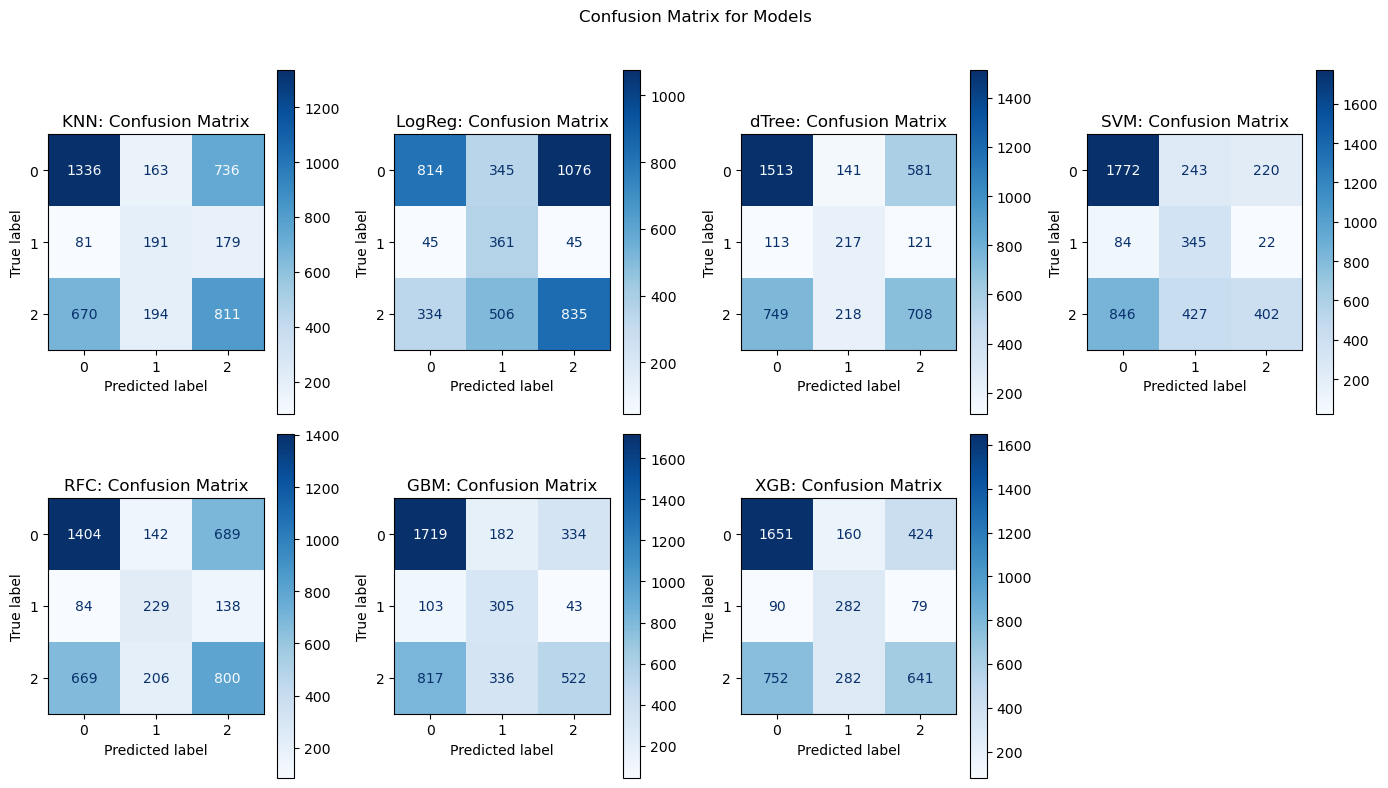

In [375]:
fig, axes = plt.subplots(2, 4, figsize=(14, 8))  # Create a grid of subplots
fig.suptitle('Confusion Matrix for Models')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df.iterrows():
    model = row['Model']
    y_pred = row['y pred']  # Use lowercase 'd' for predicted labels

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access

    # Visualizing Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
    ax.set_title(f"{model}: Confusion Matrix")

    plot_count += 1

# Hide the 8th subplot if there are more than 7 plots
if plot_count < len(axes.flat):
    axes.flat[plot_count].axis('off')

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to accommodate suptitle

plt.show()

### Initial Findings

1. **SVC is computationally most expensive**: 
   - **SVC** took the longest time to train, indicating it is the most computationally intensive model, with a train time of **152.73 seconds** compared to much faster models like **KNN (0.0664 seconds)** and **XGB (0.5177 seconds)**.

2. **XGB seems to have better results than others**: 
   - **XGBoost (XGB)** consistently outperformed most models with the best **Test Accuracy (0.59)** and **ROC-AUC (Micro: 0.79, Macro: 0.74)**, making it the top-performing model overall.

3. **Based on F1 Score**: 
   - **XGB**, **Random Forest Classifier (RFC)**, and **Decision Tree (dTree)** showed better performance compared to other models, with strong F1 Scores:
     - **XGB**: F1 Macro of **0.54**
     - **RFC**: F1 Macro of **0.52**
     - **dTree**: F1 Macro of **0.51**

4. **Based on ROC-AUC Scores**: 
   - **XGB** and **Gradient Boosting Machine (GBM)** have the best AUC scores:
     - **XGB**: **ROC-AUC Micro: 0.79**, **Macro: 0.74**
     - **GBM**: **ROC-AUC Micro: 0.77**, **Macro: 0.71**
   - They are followed by **SVM** and **RFC**, which have comparable ROC-AUC scores:
     - **SVM**: **ROC-AUC Micro: 0.76**, **Macro: 0.73**
     - **RFC**: **ROC-AUC Micro: 0.75**, **Macro: 0.70**

These findings indicate that **XGB** and **GBM** offer the best performance across the majority of metrics, making them the top choices for further model refinement or deployment.

## Improving the Models

### Hyperparameter tuning using Grid Search and Cross Validation

In [382]:
cols = X.columns.tolist()
print(cols)

['Inherited from mother', 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Blood test result', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']


#### 'KNN': OneVsRestClassifier(KNeighborsClassifier())

In [418]:
param_grid_knn = {
    'estimator__n_neighbors': [3, 5, 7, 9],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__metric': ['euclidean', 'manhattan', 'minkowski'],
}

In [420]:
%%time
knn = OneVsRestClassifier(KNeighborsClassifier())
knn_grid = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')

start_time = time.time()
knn_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 1min 18s, sys: 585 ms, total: 1min 19s
Wall time: 1min 20s


In [421]:
knn_execution_time = end_time - start_time
knn_grid_best_params = knn_grid.best_params_
knn_grid_train_score = knn_grid.score(X_resampled, y_resampled)
knn_grid_test_score = knn_grid.score(X_test, y_test)
print('knn_grid_best_params: ', knn_grid_best_params)
print('knn_grid_train_score: ', round(knn_grid_train_score,2))
print('knn_grid_test_score: ', round(knn_grid_test_score,2))
print('knn_execution_time: ', round(knn_execution_time,2), 's')

y_pred_knn = knn_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_knn, zero_division=0.0))

knn_grid_best_params:  {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 9, 'estimator__weights': 'distance'}
knn_grid_train_score:  0.76
knn_grid_test_score:  0.55
knn_execution_time:  80.23 s
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63      2235
           1       0.39      0.37      0.38       451
           2       0.47      0.51      0.49      1675

    accuracy                           0.55      4361
   macro avg       0.50      0.50      0.50      4361
weighted avg       0.55      0.55      0.55      4361



In [557]:
# Save the trained model
joblib.dump(knn_grid, "../deployment/KNeighborsClassifier.model")

['../deployment/KNeighborsClassifier.model']

#### 'LogReg': LogisticRegression(multi_class='multinomial', max_iter=1000)

In [424]:
%%time
logreg = LogisticRegression(multi_class='multinomial', max_iter=1000)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # Only l2 is supported with 'lbfgs'
    'solver': ['lbfgs', 'saga'],
}

logreg_grid = GridSearchCV(logreg, param_grid=param_grid_logreg, cv=5, scoring='accuracy')

start_time = time.time()
logreg_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 7.35 s, sys: 1.15 s, total: 8.5 s
Wall time: 3.51 s


In [425]:
logreg_execution_time = end_time - start_time

logreg_grid_best_params = logreg_grid.best_params_
logreg_grid_train_score = logreg_grid.score(X_resampled, y_resampled)
logreg_grid_test_score = logreg_grid.score(X_test, y_test)

print('logreg_grid_best_params: ', logreg_grid_best_params)
print('logreg_grid_train_score: ', round(logreg_grid_train_score,2))
print('logreg_grid_test_score: ', round(logreg_grid_test_score,2))
print('logreg_execution_time: ', round(logreg_execution_time,2), 's')

y_pred_logreg = logreg_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_logreg, zero_division=0.0))

logreg_grid_best_params:  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
logreg_grid_train_score:  0.58
logreg_grid_test_score:  0.46
logreg_execution_time:  3.51 s
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.37      0.48      2235
           1       0.30      0.80      0.43       451
           2       0.43      0.50      0.46      1675

    accuracy                           0.46      4361
   macro avg       0.47      0.55      0.46      4361
weighted avg       0.54      0.46      0.47      4361



In [555]:
# Save the trained model
joblib.dump(logreg_grid, "../deployment/LogisticRegression.model")

['../deployment/LogisticRegression.model']

#### 'dTree': DecisionTreeClassifier()

In [428]:
param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [429]:
%%time
dtree = DecisionTreeClassifier()

dtree_grid = GridSearchCV(dtree, param_grid=param_grid_dtree, cv=5, scoring='accuracy')

start_time = time.time()
dtree_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 11 s, sys: 119 ms, total: 11.1 s
Wall time: 11 s


In [430]:
dtree_execution_time = end_time - start_time
dtree_grid_best_params = dtree_grid.best_params_
dtree_grid_train_score = dtree_grid.score(X_resampled, y_resampled)
dtree_grid_test_score = dtree_grid.score(X_test, y_test)
print('dtree_grid_best_params: ', dtree_grid_best_params)
print('dtree_grid_train_score: ', round(dtree_grid_train_score,2))
print('dtree_grid_test_score: ', round(dtree_grid_test_score,2))
print('dtree_execution_time: ', round(dtree_execution_time,2), 's')

y_pred_dtree = dtree_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_dtree, zero_division=0.0))

dtree_grid_best_params:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
dtree_grid_train_score:  0.76
dtree_grid_test_score:  0.56
dtree_execution_time:  10.98 s
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66      2235
           1       0.36      0.50      0.42       451
           2       0.50      0.43      0.46      1675

    accuracy                           0.56      4361
   macro avg       0.50      0.53      0.51      4361
weighted avg       0.56      0.56      0.56      4361



In [553]:
# Save the trained model
joblib.dump(dtree_grid, "../deployment/DecisionTreeClassifier.model")

['../deployment/DecisionTreeClassifier.model']

#### 'SVM': SVC(probability=True)

In [433]:
%%time
kernels = ['linear', 'poly', 'rbf']
cv_scores = []
for k in kernels:
    svc = SVC(kernel=k)
    scores = cross_val_score(svc, X_resampled, y_resampled, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernel is {optimal_kernel} with cross-validation score of {max(cv_scores)}")

Optimal kernel is rbf with cross-validation score of 0.6226274378192937
CPU times: user 2min 19s, sys: 3.79 s, total: 2min 23s
Wall time: 2min 23s


In [456]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': [optimal_kernel],
    'gamma': ['scale', 'auto'],
}

In [458]:
%%time

svm = SVC(probability=True)

svm_grid = GridSearchCV(svm, param_grid=param_grid_svc, cv=2, scoring='accuracy')

start_time = time.time()
svm_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 14min 16s, sys: 19.1 s, total: 14min 35s
Wall time: 14min 49s


In [459]:
svm_execution_time = end_time - start_time
svm_grid_best_params = svm_grid.best_params_
svm_grid_train_score = svm_grid.score(X_resampled, y_resampled)
svm_grid_test_score = svm_grid.score(X_test, y_test)
print('svm_grid_best_params: ', svm_grid_best_params)
print('svm_grid_train_score: ', round(svm_grid_train_score,2))
print('svm_grid_test_score: ', round(svm_grid_test_score,2))
print('svm_execution_time: ', round(svm_execution_time,2), 's')

y_pred_svm = svm_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=0.0))

svm_grid_best_params:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
svm_grid_train_score:  0.67
svm_grid_test_score:  0.58
svm_execution_time:  889.73 s
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70      2235
           1       0.35      0.73      0.48       451
           2       0.56      0.32      0.40      1675

    accuracy                           0.58      4361
   macro avg       0.53      0.60      0.53      4361
weighted avg       0.59      0.58      0.56      4361



In [551]:
# Save the trained model
joblib.dump(svm_grid, "../deployment/SVC.model")

['../deployment/SVC.model']

#### 'RFC': RandomForestClassifier()

In [496]:
param_grid_rfc = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

In [498]:
%%time
rfc = RandomForestClassifier()

rfc_grid = GridSearchCV(rfc, param_grid=param_grid_rfc, cv=2, scoring='accuracy')

start_time = time.time()
rfc_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 1min, sys: 1.98 s, total: 1min 2s
Wall time: 1min 2s


In [499]:
rfc_execution_time = end_time - start_time
rfc_grid_best_params = rfc_grid.best_params_
rfc_grid_train_score = rfc_grid.score(X_resampled, y_resampled)
rfc_grid_test_score = rfc_grid.score(X_test, y_test)
print('rfc_grid_best_params: ', rfc_grid_best_params)
print('rfc_grid_train_score: ', round(rfc_grid_train_score,2))
print('rfc_grid_test_score: ', round(rfc_grid_test_score,2))
print('rfc_execution_time: ', round(rfc_execution_time,2), 's')

y_pred_rfc = rfc_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_rfc, zero_division=0.0))

rfc_grid_best_params:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
rfc_grid_train_score:  0.76
rfc_grid_test_score:  0.58
rfc_execution_time:  62.72 s
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67      2235
           1       0.39      0.56      0.46       451
           2       0.52      0.48      0.50      1675

    accuracy                           0.58      4361
   macro avg       0.53      0.57      0.54      4361
weighted avg       0.59      0.58      0.58      4361



In [549]:
# Save the trained model
joblib.dump(rfc_grid, "../deployment/RandomForestClassifier.model")

['../deployment/RandomForestClassifier.model']

#### 'GBM': GradientBoostingClassifier()

In [502]:
param_grid_gbm = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
}

In [504]:
%%time
gbm = GradientBoostingClassifier()

gbm_grid = GridSearchCV(gbm, param_grid=param_grid_gbm, cv=2, scoring='accuracy')

start_time = time.time()
gbm_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 1min 57s, sys: 559 ms, total: 1min 58s
Wall time: 1min 58s


In [505]:
gbm_execution_time = end_time - start_time
gbm_grid_best_params = gbm_grid.best_params_
gbm_grid_train_score = gbm_grid.score(X_resampled, y_resampled)
gbm_grid_test_score = gbm_grid.score(X_test, y_test)
print('gbm_grid_best_params: ', gbm_grid_best_params)
print('gbm_grid_train_score: ', round(gbm_grid_train_score,2))
print('gbm_grid_test_score: ', round(gbm_grid_test_score,2))
print('gbm_execution_time: ', round(gbm_execution_time,2), 's')

y_pred_gbm = gbm_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_gbm, zero_division=0.0))

gbm_grid_best_params:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
gbm_grid_train_score:  0.69
gbm_grid_test_score:  0.59
gbm_execution_time:  118.62 s
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      2235
           1       0.40      0.63      0.49       451
           2       0.58      0.33      0.42      1675

    accuracy                           0.59      4361
   macro avg       0.54      0.58      0.54      4361
weighted avg       0.60      0.59      0.58      4361



In [547]:
# Save the trained model
joblib.dump(gbm_grid, "../deployment/GradientBoostingClassifier.model")

['../deployment/GradientBoostingClassifier.model']

#### 'XGB': XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss')

In [512]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
}

In [514]:
%%time
xgb = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='mlogloss')

xgb_grid = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')

start_time = time.time()
xgb_grid.fit(X_resampled, y_resampled)
end_time = time.time()

CPU times: user 55min 33s, sys: 1min 45s, total: 57min 19s
Wall time: 8min 5s


In [515]:
xgb_execution_time = end_time - start_time
xgb_grid_best_params = xgb_grid.best_params_
xgb_grid_train_score = xgb_grid.score(X_resampled, y_resampled)
xgb_grid_test_score = xgb_grid.score(X_test, y_test)
print('xgb_grid_best_params: ', xgb_grid_best_params)
print('xgb_grid_train_score: ', round(xgb_grid_train_score,2))
print('xgb_grid_test_score: ', round(xgb_grid_test_score,2))
print('xgb_execution_time: ', round(xgb_execution_time,2), 's')

y_pred_xgb = xgb_grid.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb, zero_division=0.0))

xgb_grid_best_params:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
xgb_grid_train_score:  0.72
xgb_grid_test_score:  0.59
xgb_execution_time:  485.58 s
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70      2235
           1       0.39      0.62      0.48       451
           2       0.57      0.37      0.45      1675

    accuracy                           0.59      4361
   macro avg       0.54      0.58      0.54      4361
weighted avg       0.60      0.59      0.58      4361



In [545]:
# Save the trained model
joblib.dump(xgb_grid, "../deployment/XGBClassifier.model")

['../deployment/XGBClassifier.model']

In [540]:
xgb_precision_score = precision_score(y_test, y_pred_xgb, average=None, zero_division=0.0)
xgb_recall_score = recall_score(y_test, y_pred_xgb, average=None)
xgb_f1_score = f1_score(y_test, y_pred_xgb, average=None)

xgb_precision_score_rounded = [round(p, 2) for p in xgb_precision_score]
xgb_recall_score_rounded = [round(r, 2) for r in xgb_recall_score]
xgb_f1_rounded = [round(f, 2) for f in xgb_f1_score]

print('xgb_precision_score_rounded: ', xgb_precision_score_rounded)
print('xgb_recall_score_rounded: ', xgb_recall_score_rounded)
print('xgb_f1_rounded: ', xgb_f1_rounded)

xgb_precision_score_rounded:  [0.66, 0.39, 0.57]
xgb_recall_score_rounded:  [0.75, 0.62, 0.37]
xgb_f1_rounded:  [0.7, 0.48, 0.45]


#### Results Summary

In [ ]:
results_df_improved = ''
res_dict = {
    'Model': ['KNN', 'Logreg', 'dTree', 'SVM', 'RFC', 'GBM', 'XGB'],
    'Train Time': [knn_execution_time, logreg_execution_time, dtree_execution_time, svm_execution_time, rfc_execution_time, gbm_execution_time, xgb_execution_time],
    'Train Accuracy': [knn_grid_train_score, logreg_grid_train_score, dtree_grid_train_score, svm_grid_train_score, rfc_grid_train_score, gbm_grid_train_score, xgb_grid_train_score],
    'Test Accuracy': [knn_grid_test_score, logreg_grid_test_score, dtree_grid_test_score, svm_grid_test_score, rfc_grid_test_score, gbm_grid_test_score, xgb_grid_test_score],
    'Precision': [knn_precision_score, logreg_precision_score, dtree_precision_score, svm_precision_score, rfc_precision_score, gbm_precision_score, xgb_precision_score],
    'Recall': [knn_recall_score, logreg_recall_score, dtree_recall_score, svm_recall_score, rfc_recall_score, gbm_recall_score, xgb_recall_score],
    'F1': [knn_f1_score, logreg_f1_score, dtree_f1_score, svm_f1_score, rfc_f1_score, gbm_f1_score, xgb_f1_score],
    'AUC': [auc_knn, auc_logreg, auc_dtree, auc_svm, auc_rfc, auc_gbm, auc_xgb],
    'y_pred': [y_pred_knn, y_pred_logreg, y_pred_dtree, y_pred_svm, y_pred_rfc, y_pred_gbm, y_pred_xgb],
    'y_prob': [y_prob_knn, y_prob_logreg, y_prob_dtree, y_prob_svm, y_prob_rfc, y_prob_gbm, y_prob_xgb]
}
results_df_improved = pd.DataFrame(res_dict)

### Feature Importances

In [ ]:
# load the saved model
xgb_model_loaded = joblib.load("../deployment/XGBClassifier.model")

## Model Evaluation:
- Each model was trained and evaluated using the resampled dataset (via SMOTE to handle class imbalance).
- Metrics such as **accuracy**, **precision**, **recall**, **F1-score**, and **AUC (Area Under the Curve)** were calculated to assess model performance.
- Both weighted and macro/micro-averaged versions of precision, recall, and F1-score were considered for a balanced evaluation across all classes.

#### Key Results

## Deployment

In the deployment phase, focused on saving the trained models for future use. This step ensures that the models can be easily loaded and reused without the need to retrain them, saving time and computational resources.

### Steps in Deployment:
1. **Model Selection for Deployment**:
   - Based on the evaluation of metrics like accuracy, F1 score, and ROC-AUC, the top-performing models (**XGB**, **GBM**, and **RFC**) were chosen for deployment.
   
2. **Model Serialization**:
   - Each trained model was serialized and saved using **`joblib.dump`**. This library efficiently saves large models, ensuring they can be reloaded for future predictions.

3. **Model Reloading**:
   - Reload a saved model using **`joblib.load`**

4. **Future Integration**:
   - These saved models are ready for integration into any application or system, where they can be utilized for real-time predictions or batch processing tasks.
   - The deployment ensures that the models can be reused across different environments without re-training, allowing seamless transition from experimentation to production.

5. **Scalability**:
   - Since the models are saved as standalone files, they can be shared across different platforms and systems, making it easier to scale the solution as needed.

By saving the models using `joblib`, ensured the longevity and reusability of the trained models, supporting efficient and scalable deployment.